In [1]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify
import numpy as np
import cv2
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.models import load_model
import os



In [2]:


# Path to the directory containing images
image_dir = r"D:\Holland_Year_2\Block_B\2024-25b-fai2-adsai-PetarPaskalev232725\datalab_tasks\Task8\Kaggle"

# Loop through all image files in the directory
processed_images = []
for filename in os.listdir(image_dir):
    if filename.endswith(('.png', '.jpg', '.jpeg', '.tif')):  # Add other formats if needed
        image_path = os.path.join(image_dir, filename)
        
        # Load the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Skipping {filename} - could not load image.")
            continue
        
        # Convert to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Resize the image if necessary
        target_size = (256, 256)  # Define desired size
        resized_image = cv2.resize(gray_image, target_size, interpolation=cv2.INTER_AREA)
        
        # Normalize pixel values
        normalized_image = resized_image / 255.0
        
        # Patchify the image
        patch_size = 256  # Example patch size
        step_size = 256   # Example step size
        patches = patchify(normalized_image, (patch_size, patch_size), step=step_size)
        
        # Store patches for later use or processing
        processed_images.append((filename, patches))

        # Optional: Print progress
        print(f"Processed {filename} - Patches shape: {patches.shape}")

# Check the number of processed images
print(f"Total processed images: {len(processed_images)}")


Processed test_image_1.png - Patches shape: (1, 1, 256, 256)
Processed test_image_10.png - Patches shape: (1, 1, 256, 256)
Processed test_image_11.png - Patches shape: (1, 1, 256, 256)
Processed test_image_12.png - Patches shape: (1, 1, 256, 256)
Processed test_image_13.png - Patches shape: (1, 1, 256, 256)
Processed test_image_14.png - Patches shape: (1, 1, 256, 256)
Processed test_image_15.png - Patches shape: (1, 1, 256, 256)
Processed test_image_16.png - Patches shape: (1, 1, 256, 256)
Processed test_image_17.png - Patches shape: (1, 1, 256, 256)
Processed test_image_18.png - Patches shape: (1, 1, 256, 256)
Processed test_image_2.png - Patches shape: (1, 1, 256, 256)
Processed test_image_3.png - Patches shape: (1, 1, 256, 256)
Processed test_image_4.png - Patches shape: (1, 1, 256, 256)
Processed test_image_5.png - Patches shape: (1, 1, 256, 256)
Processed test_image_6.png - Patches shape: (1, 1, 256, 256)
Processed test_image_7.png - Patches shape: (1, 1, 256, 256)
Processed test_

In [3]:


# **Load and preprocess all images in the dataset**
def load_images_from_directory(directory_path):
    """
    Load all images from a directory in grayscale mode.
    """
    images = []
    filenames = []
    for filename in os.listdir(directory_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.tif')):  # Supported formats
            image_path = os.path.join(directory_path, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                images.append(image)
                filenames.append(filename)
            else:
                print(f"Failed to load {filename}")
    return images, filenames

# **Detect edges to find the Petri dish**
def detect_edges(image, max_size=2800):
    """
    Detect edges and find the approximate square Petri dish.
    """
    blurred_image = cv2.GaussianBlur(image, (51, 51), 0)
    sobel_x = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=5)
    gradient_magnitude = cv2.magnitude(sobel_x, sobel_y)
    _, edges = cv2.threshold(gradient_magnitude, 50, 255, cv2.THRESH_BINARY)
    edges = edges.astype(np.uint8)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(max_contour)

    side_length = min(max(w, h), max_size)
    center_x, center_y = x + w // 2, y + h // 2
    half_side = side_length // 2
    new_x = max(center_x - half_side, 0)
    new_y = max(center_y - half_side, 0)
    new_w = new_h = min(side_length, min(image.shape[1] - new_x, image.shape[0] - new_y))
    return new_x, new_x + new_w, new_y, new_y + new_h

# **Crop the image based on detected edges**
def crop_image(image, edges, max_size=2800):
    """
    Crop the image based on detected edges and resize if necessary.
    """
    left, right, top, bottom = edges
    cropped = image[top:bottom, left:right]
    if cropped.shape[1] > max_size or cropped.shape[0] > max_size:
        cropped = cv2.resize(cropped, (min(cropped.shape[1], max_size), min(cropped.shape[0], max_size)))
    return cropped

# **Pad the image to make dimensions divisible by the patch size**
def padder(image, patch_size):
    """
    Add padding to make dimensions divisible by the patch size.
    """
    h, w = image.shape[:2]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w
    top_padding = int(height_padding / 2)
    bottom_padding = height_padding - top_padding
    left_padding = int(width_padding / 2)
    right_padding = width_padding - left_padding
    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=0)
    return padded_image

# **Patchify and normalize the image**
def preprocess_image(image, patch_size=256):
    """
    Preprocess the image: pad, patchify, and normalize.
    """
    patches = patchify(image, (patch_size, patch_size), step=patch_size)
    patches_reshaped = patches.reshape(-1, patch_size, patch_size, 1)  # Add channel dimension
    patches_normalized = patches_reshaped / 255.0
    return patches, patches_normalized

# **Run the preprocessing pipeline**
image_dir = r"D:\Holland_Year_2\Block_B\2024-25b-fai2-adsai-PetarPaskalev232725\datalab_tasks\Task8\Kaggle"

# Load all images from the directory
images, filenames = load_images_from_directory(image_dir)

# Preprocess each image
preprocessed_data = []
patch_size = 256
for image, filename in zip(images, filenames):
    edges = detect_edges(image)
    cropped_image = crop_image(image, edges)
    petri_dish_padded = padder(cropped_image, patch_size)
    patches, patches_normalized = preprocess_image(petri_dish_padded, patch_size)
    preprocessed_data.append((filename, patches_normalized))

    # Print progress
    print(f"Processed {filename}: Original shape {image.shape}, Padded shape {petri_dish_padded.shape}, Patches {patches.shape}")

# Verify results
print(f"Total images processed: {len(preprocessed_data)}")


Processed test_image_1.png: Original shape (3006, 4112), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_10.png: Original shape (3006, 4202), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_11.png: Original shape (3006, 4202), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_12.png: Original shape (3006, 4202), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_13.png: Original shape (2999, 4202), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_14.png: Original shape (3006, 4202), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_15.png: Original shape (3006, 4202), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_16.png: Original shape (3006, 4202), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_17.png: Original shape (3006, 4202), Padded shape (2816, 2816), Patches (11, 11, 256

In [4]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [5]:

# **Load the model**
model_path = "PetarPaskalev_232725_unet_model_4_256px_82F1.h5"
model = load_model(model_path, custom_objects={"f1": f1})

# **Run predictions**
predictions = []
for filename, patches_normalized in preprocessed_data:
    # Predict on patches
    predicted_patches = model.predict(patches_normalized, batch_size=16)
    
    # Reshape predictions back to original patch grid
    num_patches = int(np.sqrt(predicted_patches.shape[0]))  # Assuming square grid
    predicted_patches = predicted_patches.reshape(num_patches, num_patches, patch_size, patch_size)
    
    # Reconstruct the full image using unpatchify
    petri_dish_padded_shape = (patch_size * num_patches, patch_size * num_patches)
    reconstructed_prediction = unpatchify(predicted_patches, petri_dish_padded_shape)
    
    # Store the prediction
    predictions.append((filename, reconstructed_prediction))
    print(f"Prediction completed for {filename}")

# **Visualize predictions**
for filename, predicted_mask in predictions:
    plt.figure(dpi=100)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title(f"Prediction for {filename}")
    plt.axis('off')
    plt.show()


TypeError: weight_decay is not a valid argument, kwargs should be empty  for `optimizer_experimental.Optimizer`.

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Loop through predictions and convert each mask to binary
binary_predictions = []
for filename, predicted_mask in predictions:
    # Convert predicted mask to binary: thresholding at 0.5
    binary_mask = (predicted_mask > 0.5).astype(np.uint8) * 255
    
    # Store the binary mask
    binary_predictions.append((filename, binary_mask))

 

  


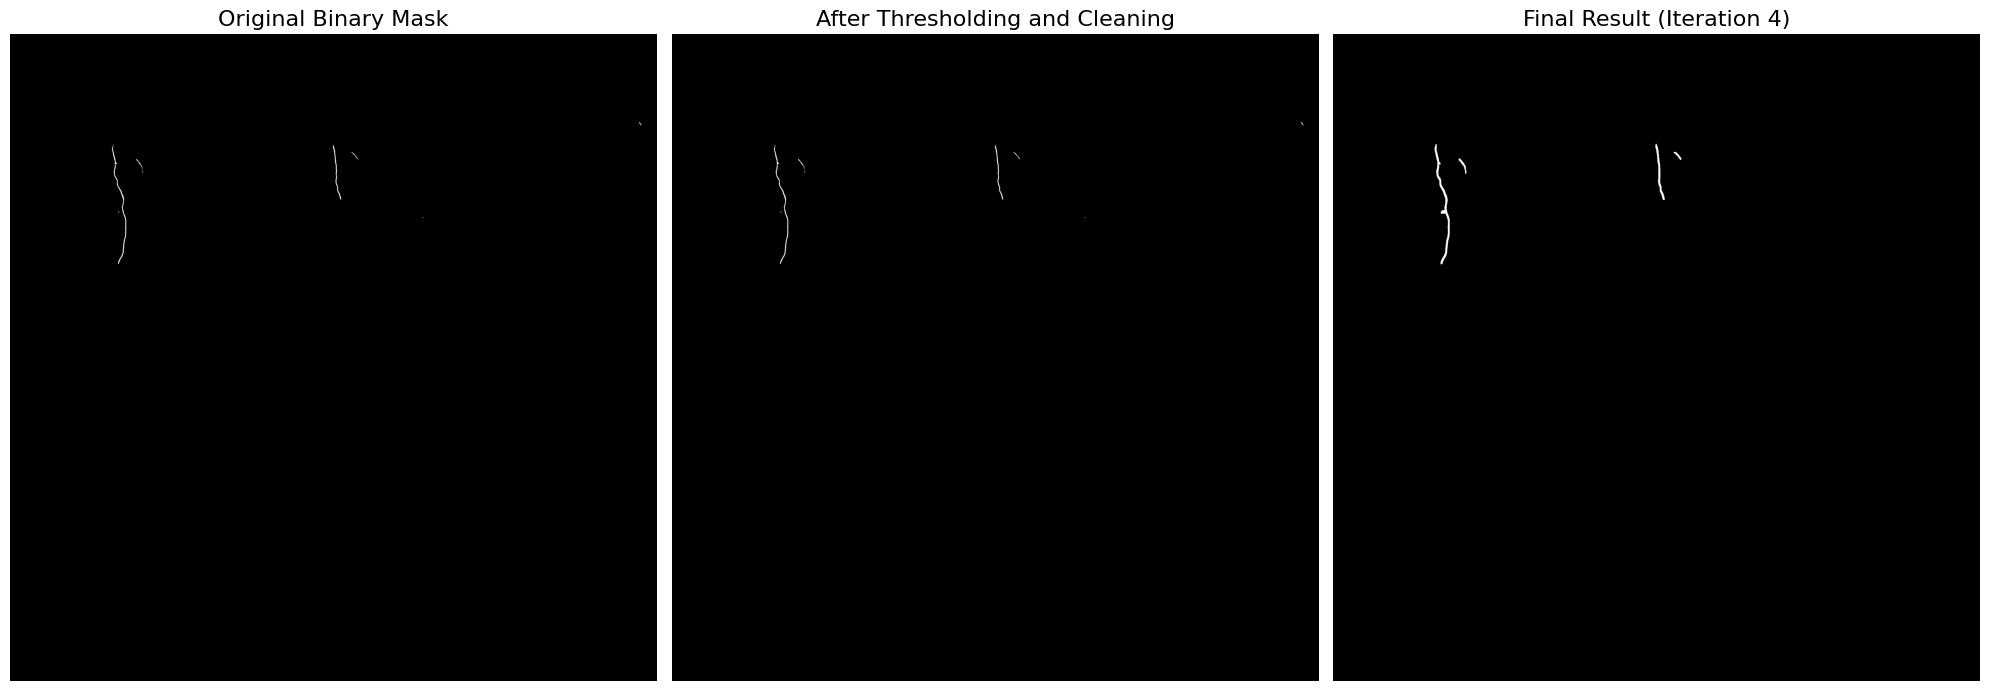

Processed test_image_1.png with Kernel Size = 5, Total Iterations = 4: Threshold = 0.5, Min Object Size = 200


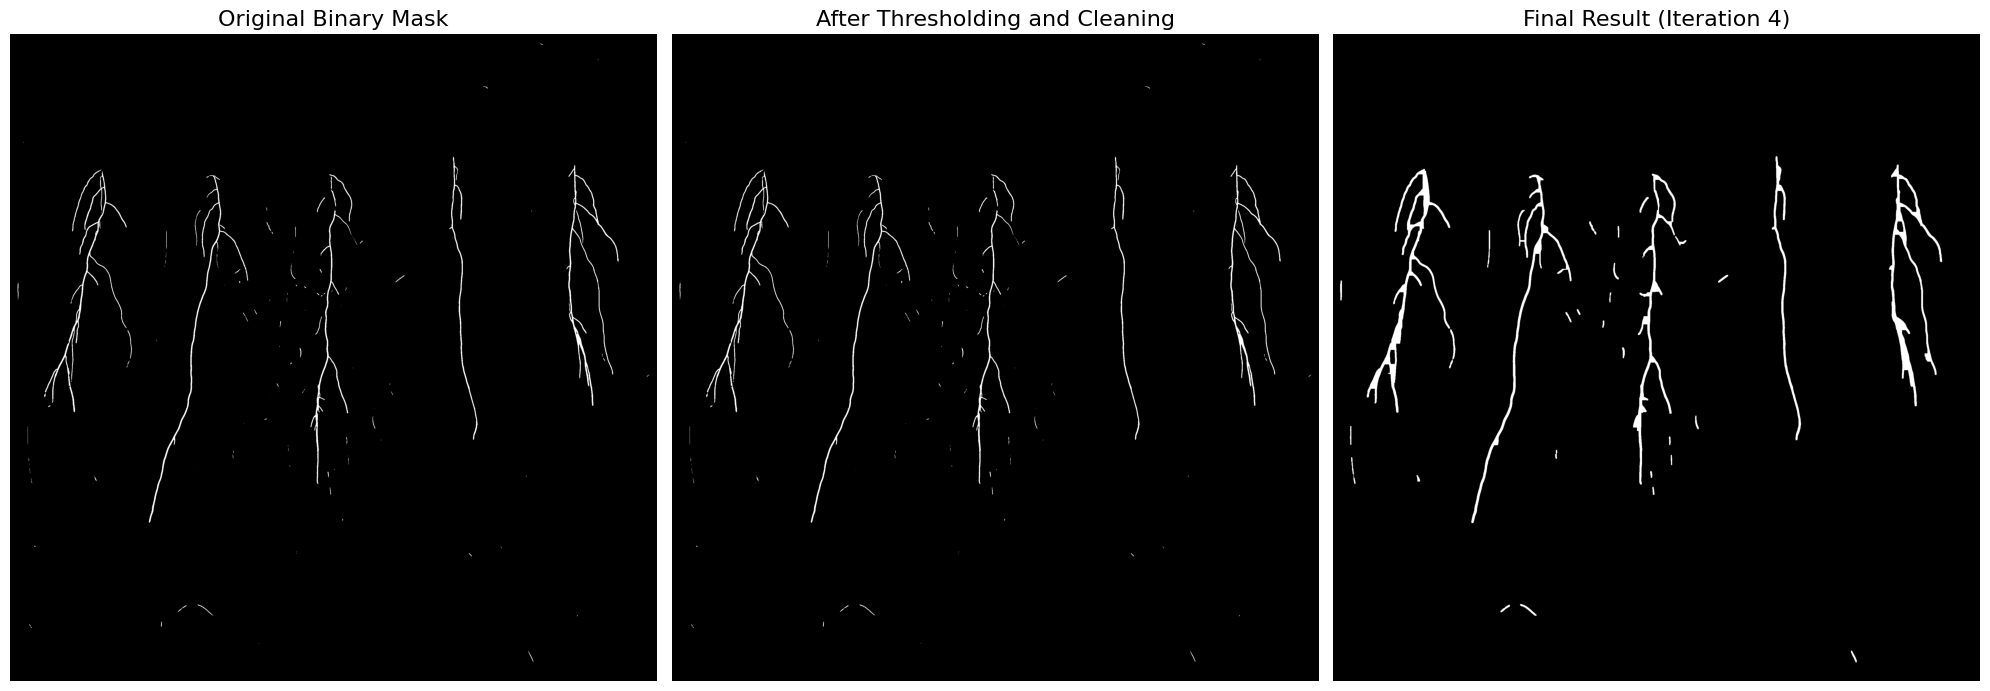

Processed test_image_10.png with Kernel Size = 5, Total Iterations = 4: Threshold = 0.5, Min Object Size = 200


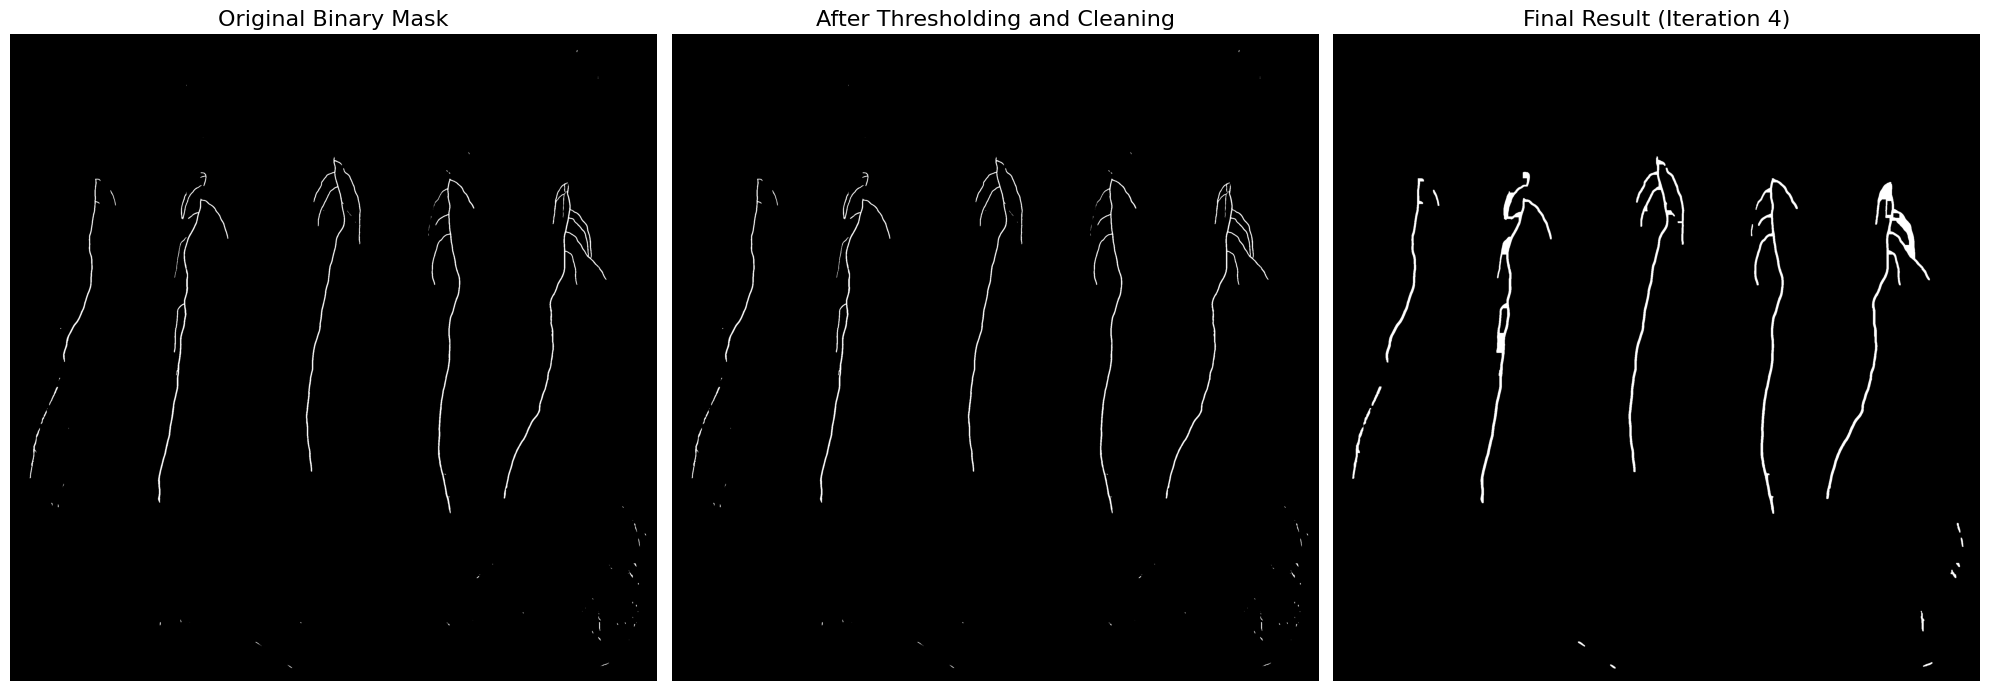

Processed test_image_11.png with Kernel Size = 5, Total Iterations = 4: Threshold = 0.5, Min Object Size = 200


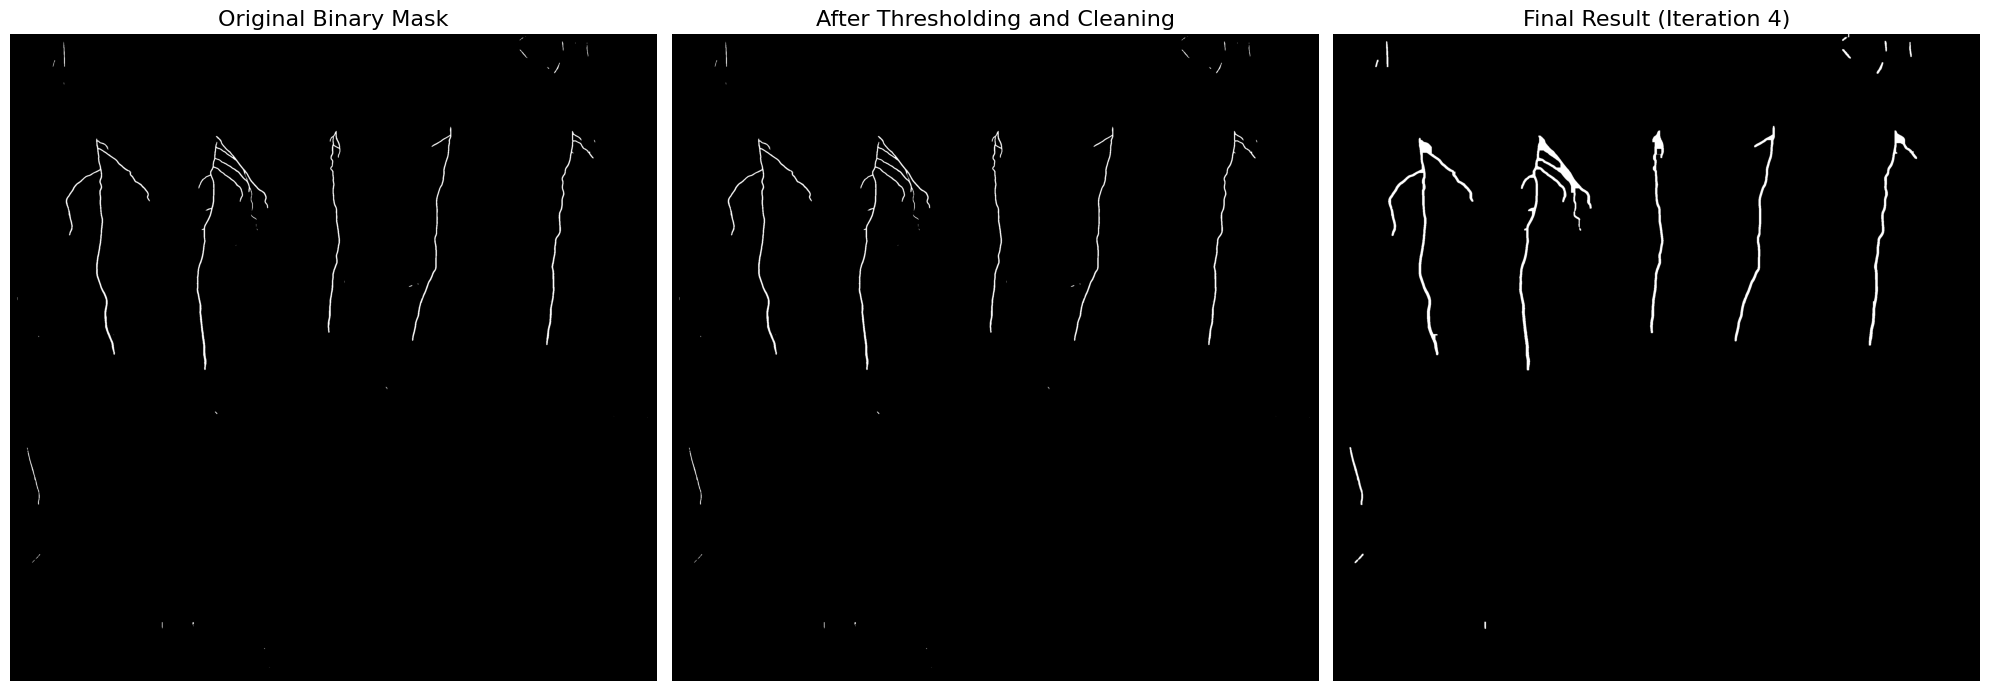

Processed test_image_12.png with Kernel Size = 5, Total Iterations = 4: Threshold = 0.5, Min Object Size = 200


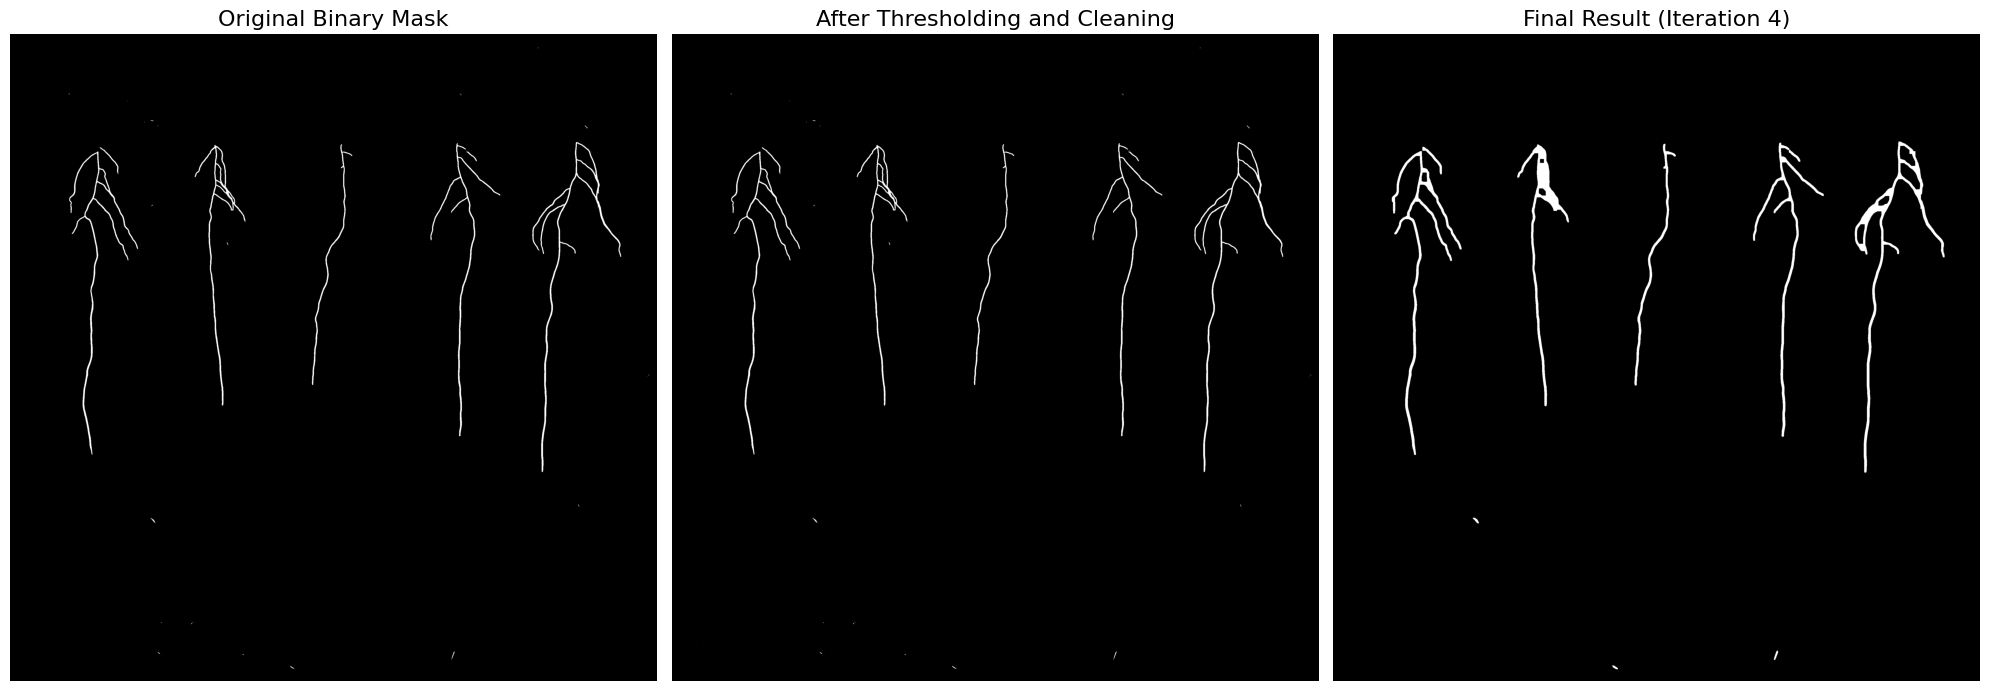

Processed test_image_13.png with Kernel Size = 5, Total Iterations = 4: Threshold = 0.5, Min Object Size = 200


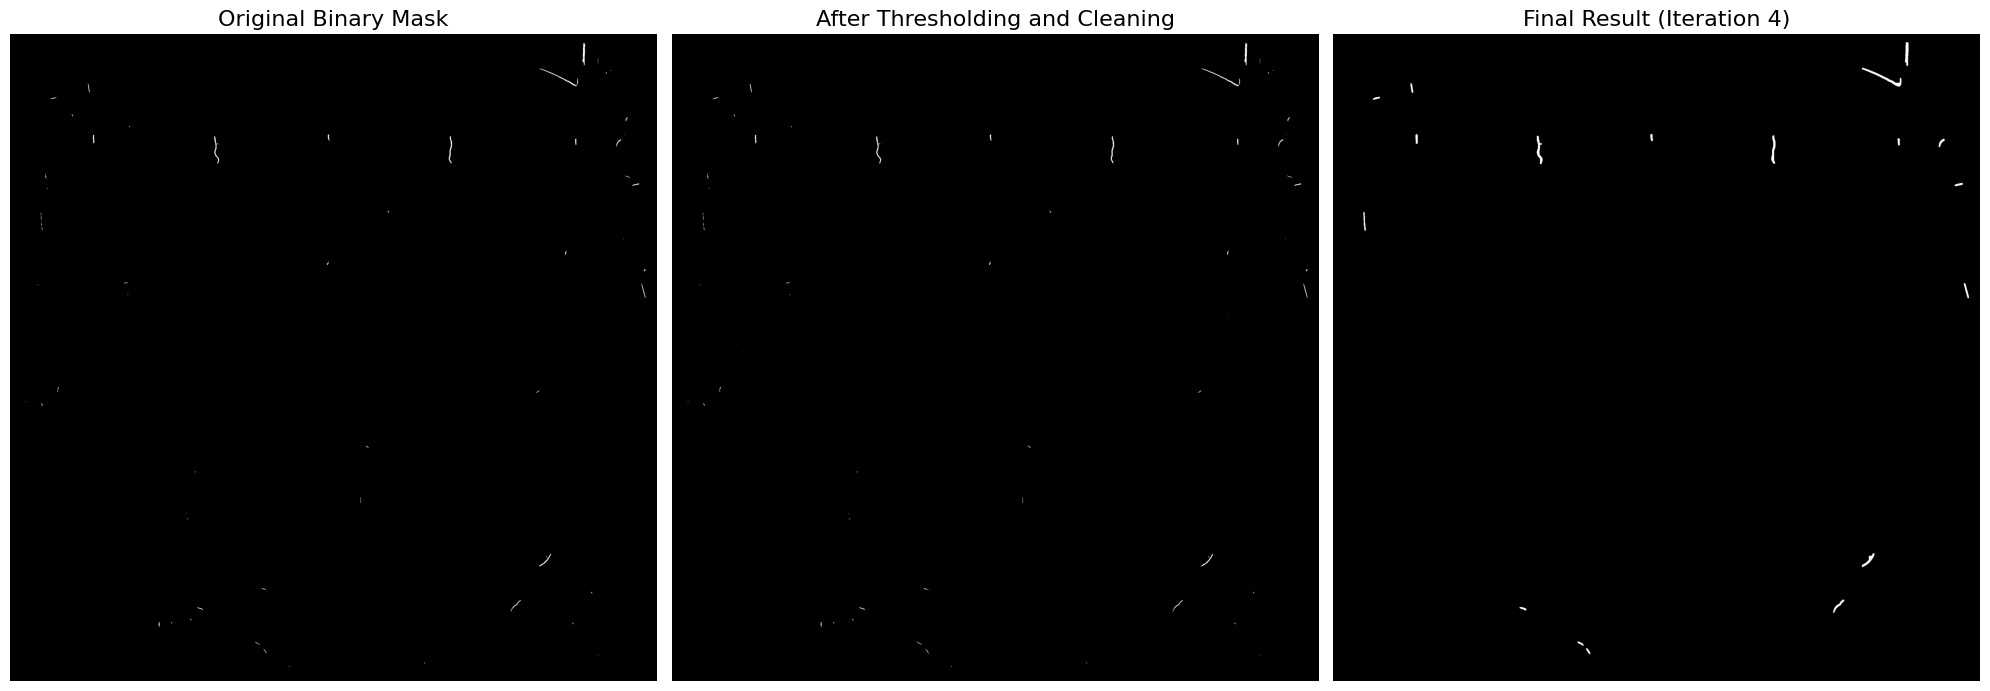

Processed test_image_14.png with Kernel Size = 5, Total Iterations = 4: Threshold = 0.5, Min Object Size = 200


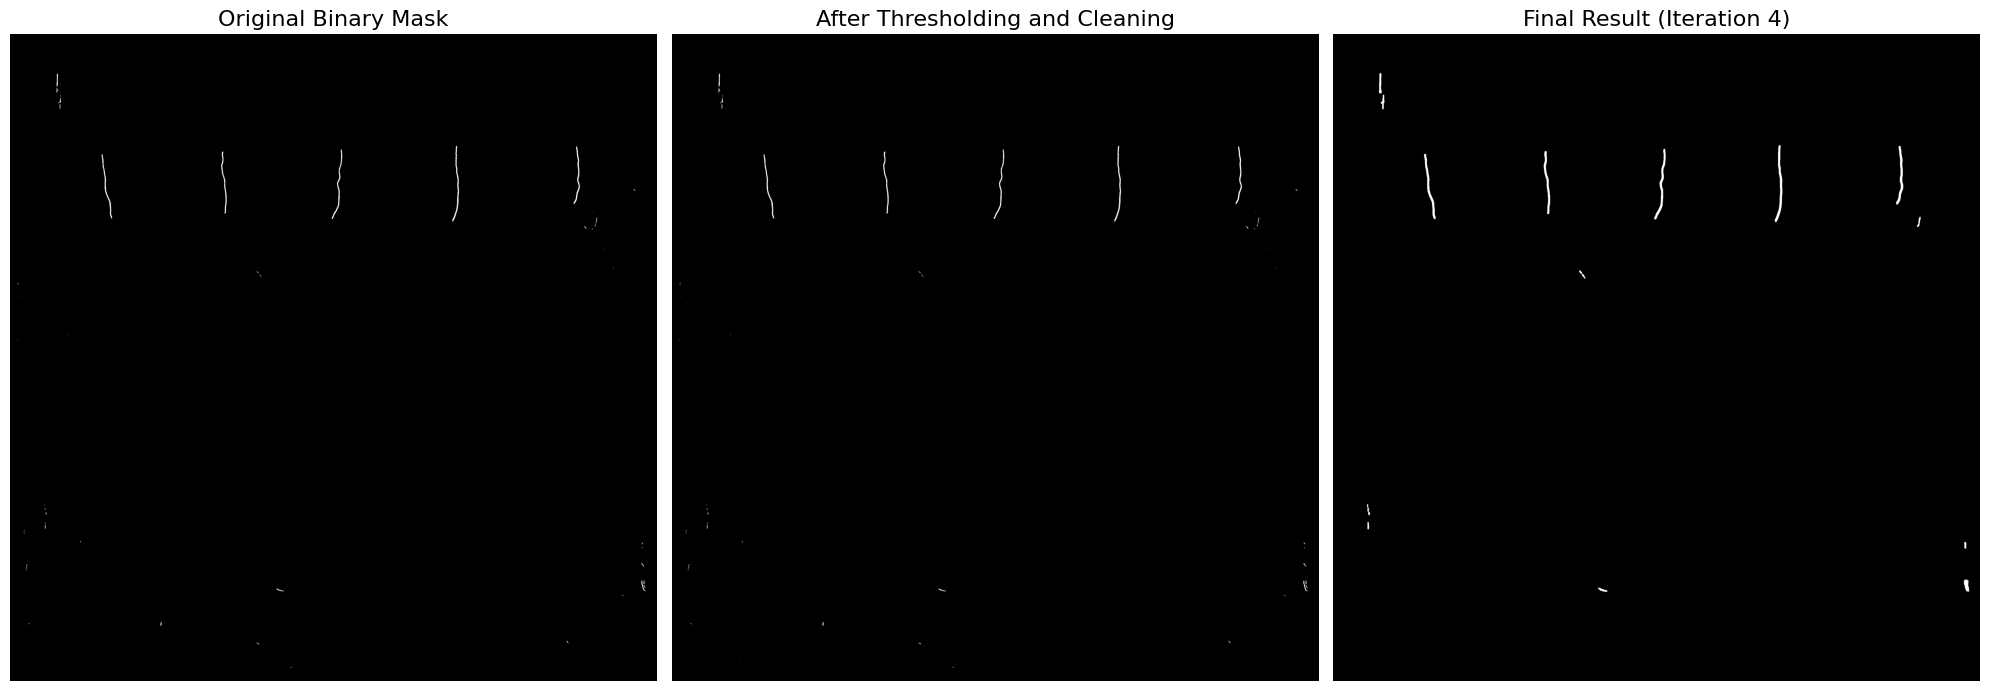

Processed test_image_15.png with Kernel Size = 5, Total Iterations = 4: Threshold = 0.5, Min Object Size = 200


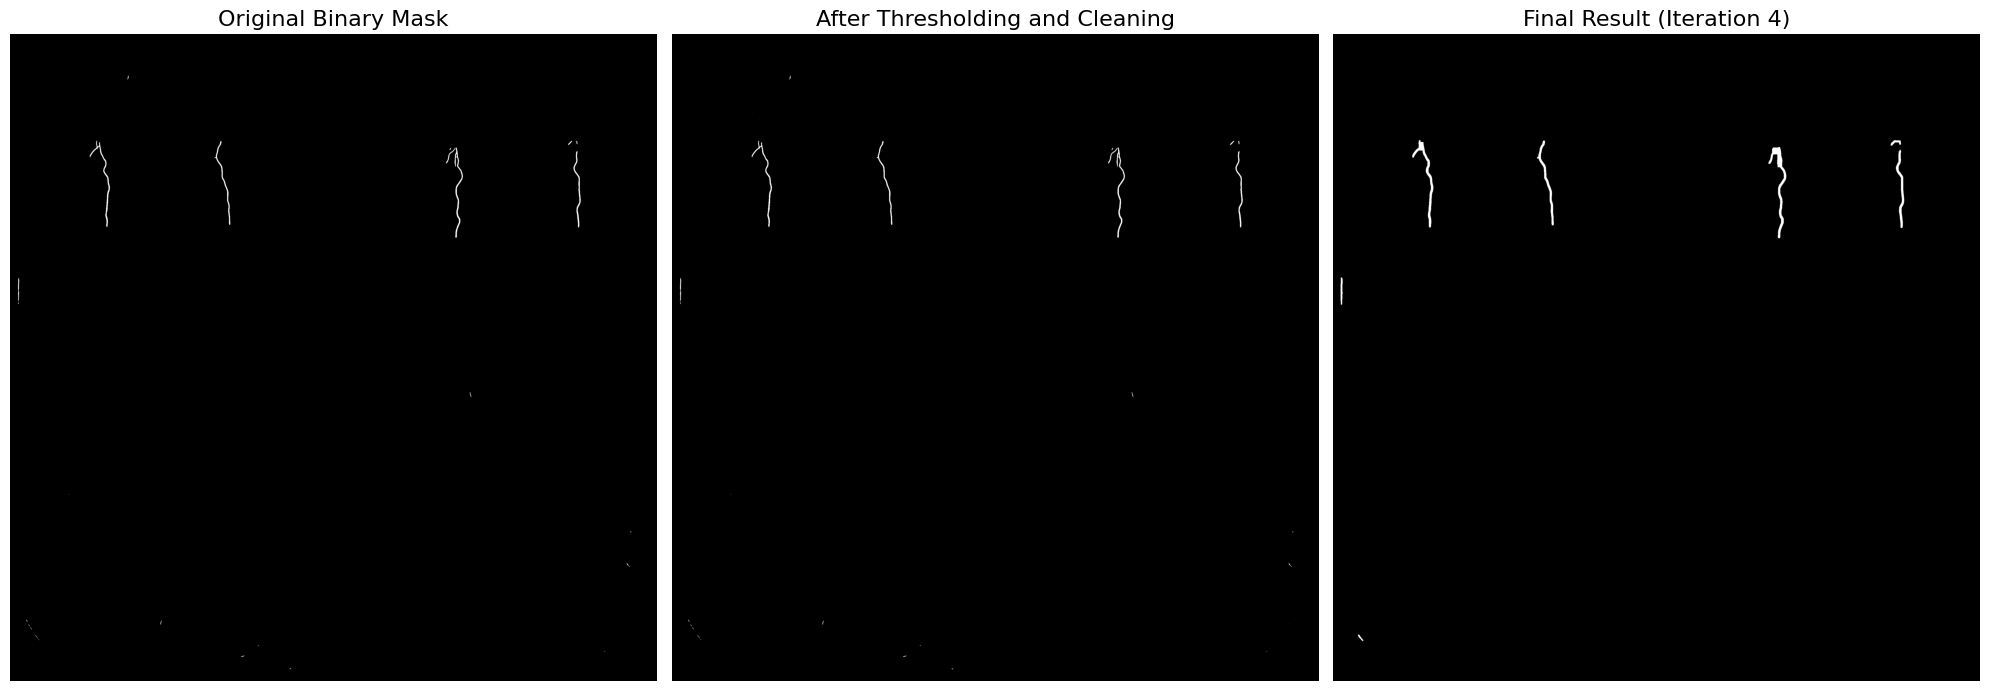

Processed test_image_16.png with Kernel Size = 5, Total Iterations = 4: Threshold = 0.5, Min Object Size = 200


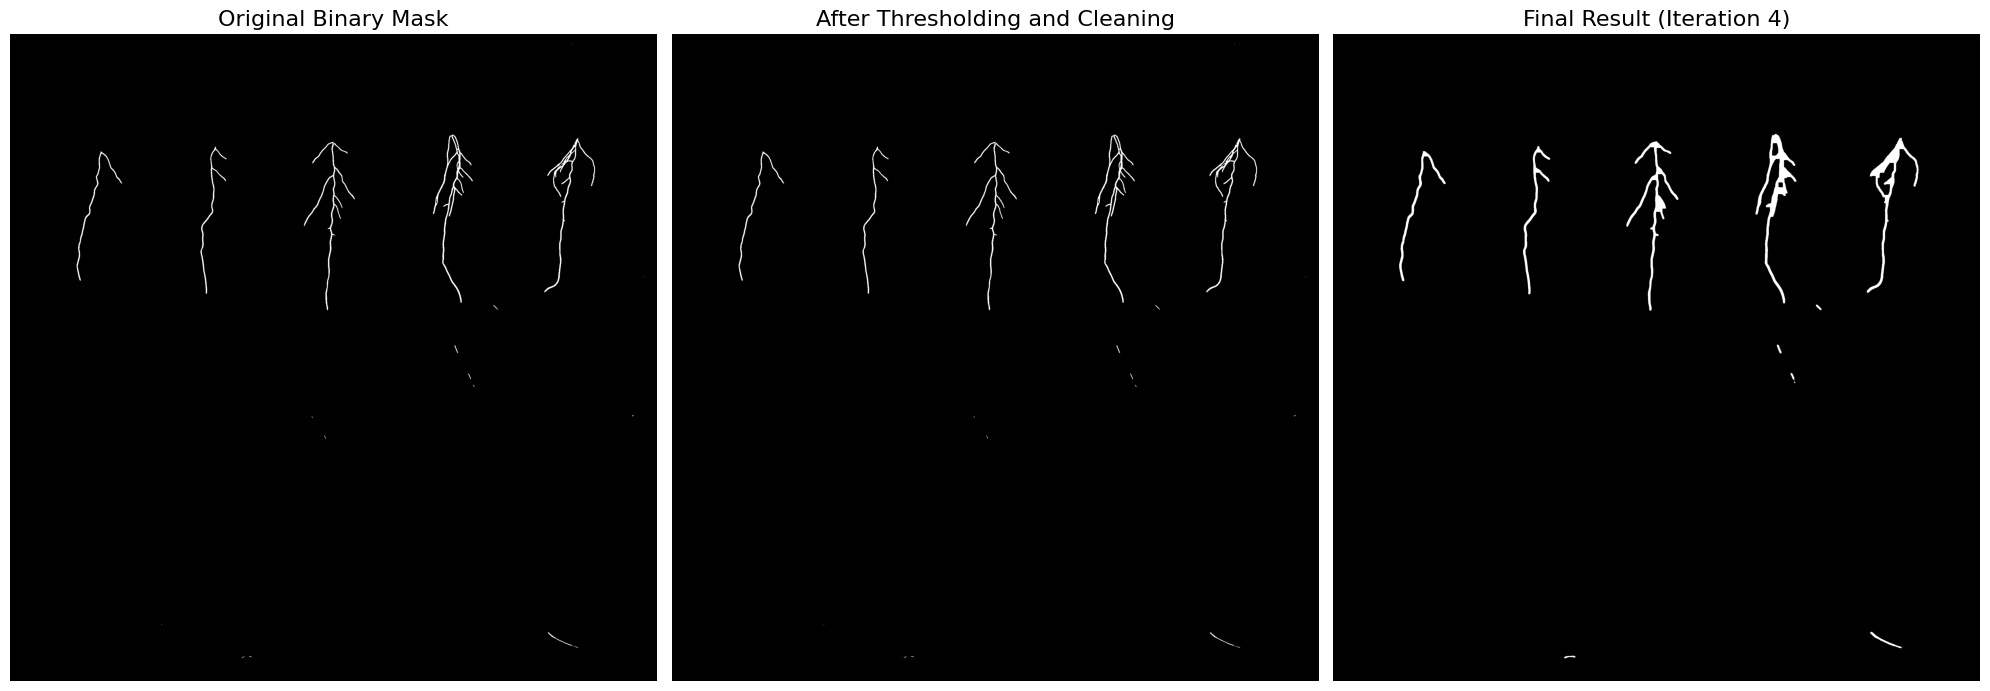

Processed test_image_17.png with Kernel Size = 5, Total Iterations = 4: Threshold = 0.5, Min Object Size = 200


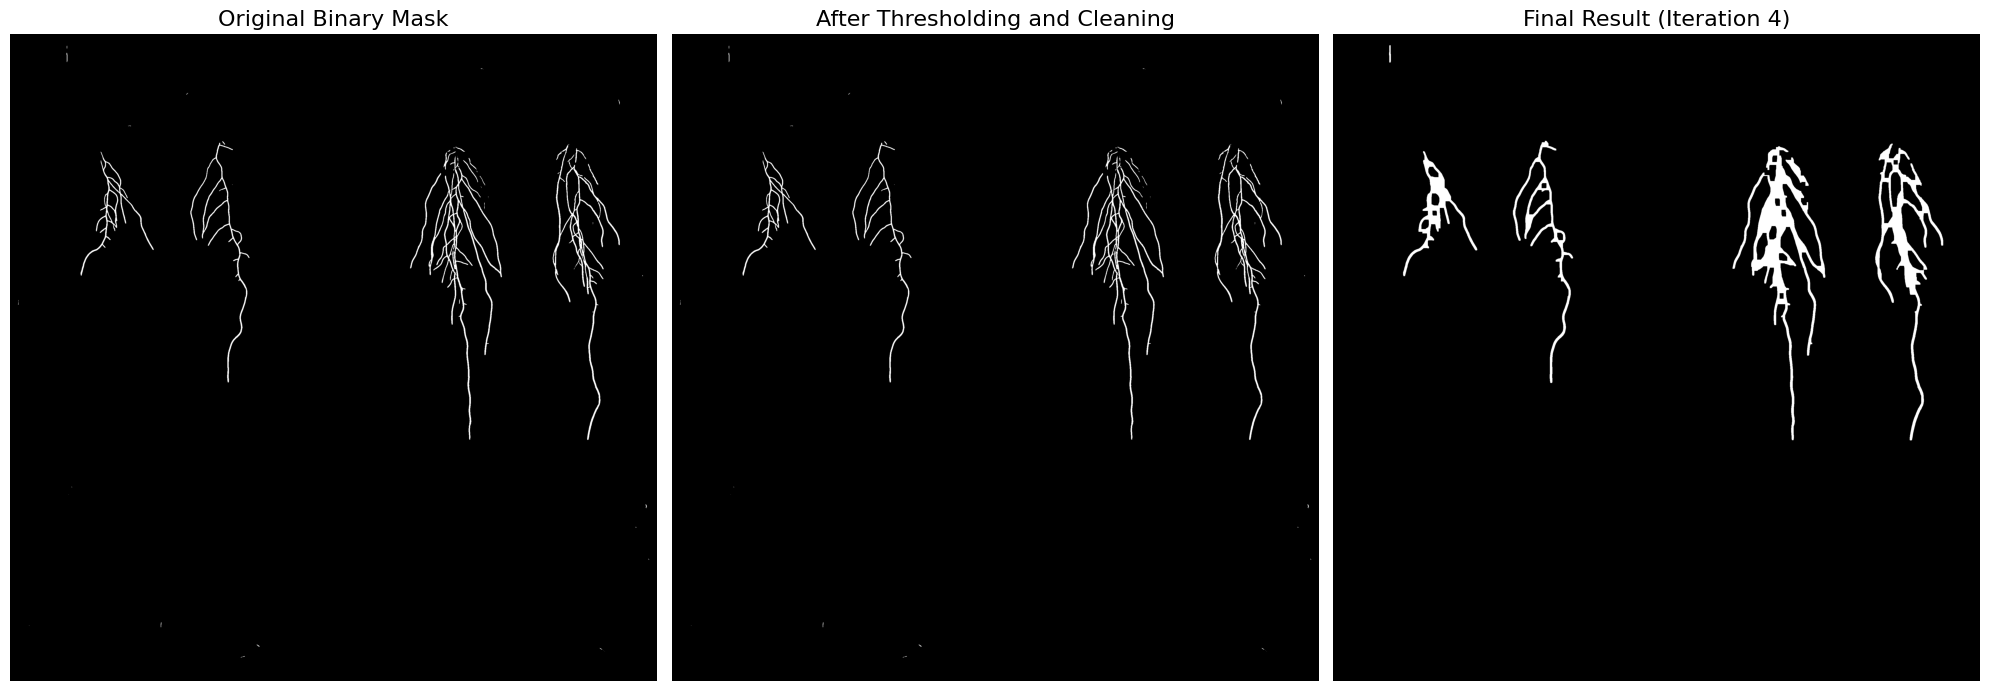

Processed test_image_18.png with Kernel Size = 5, Total Iterations = 4: Threshold = 0.5, Min Object Size = 200


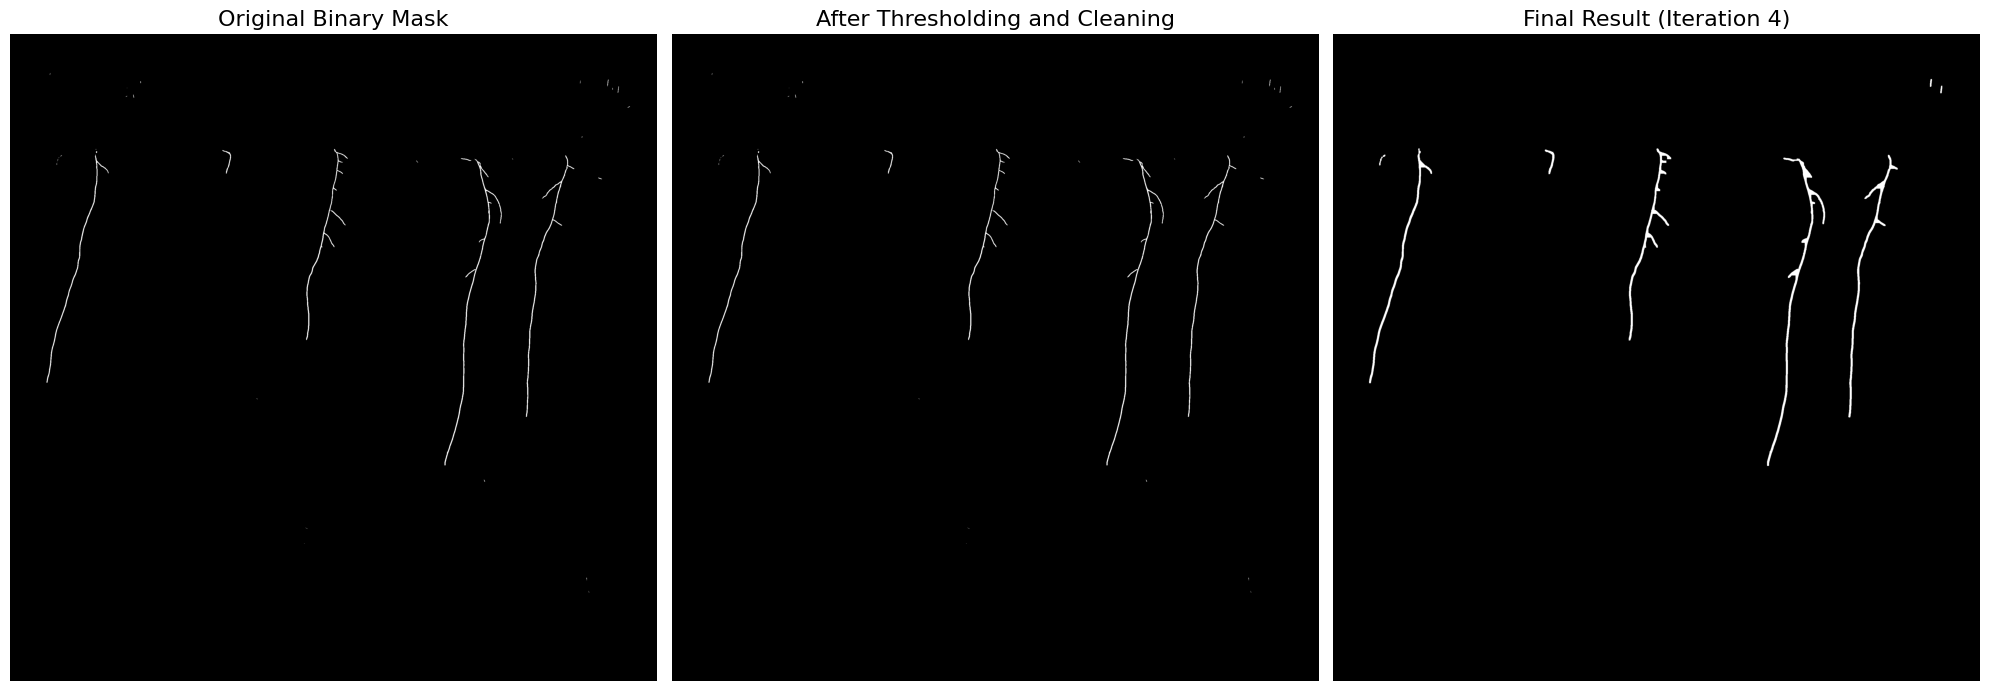

Processed test_image_2.png with Kernel Size = 5, Total Iterations = 4: Threshold = 0.5, Min Object Size = 200


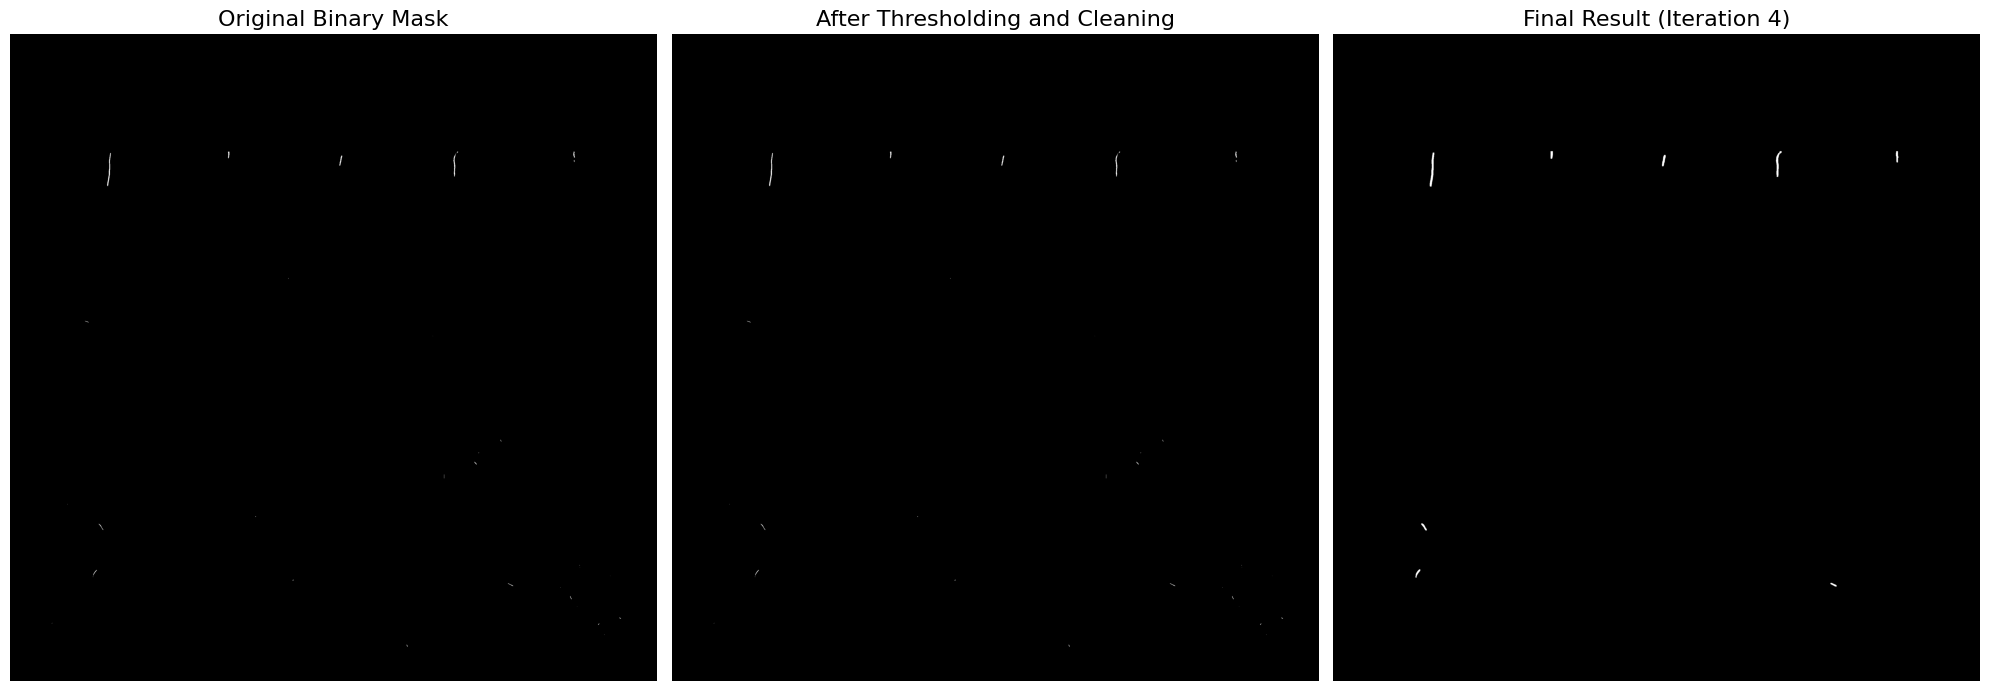

Processed test_image_3.png with Kernel Size = 5, Total Iterations = 4: Threshold = 0.5, Min Object Size = 200


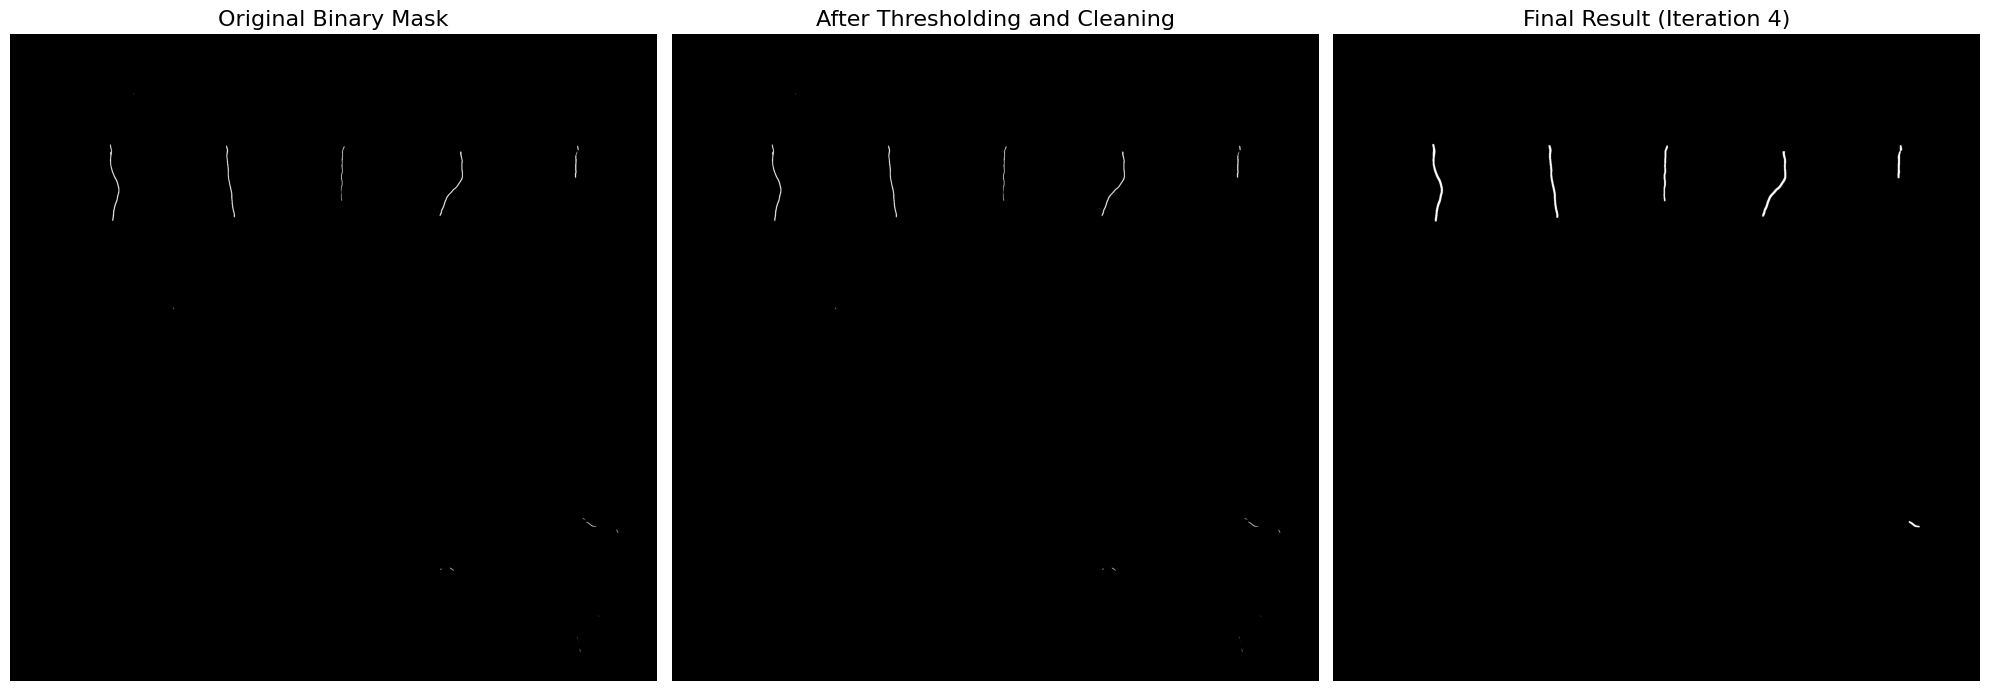

Processed test_image_4.png with Kernel Size = 5, Total Iterations = 4: Threshold = 0.5, Min Object Size = 200


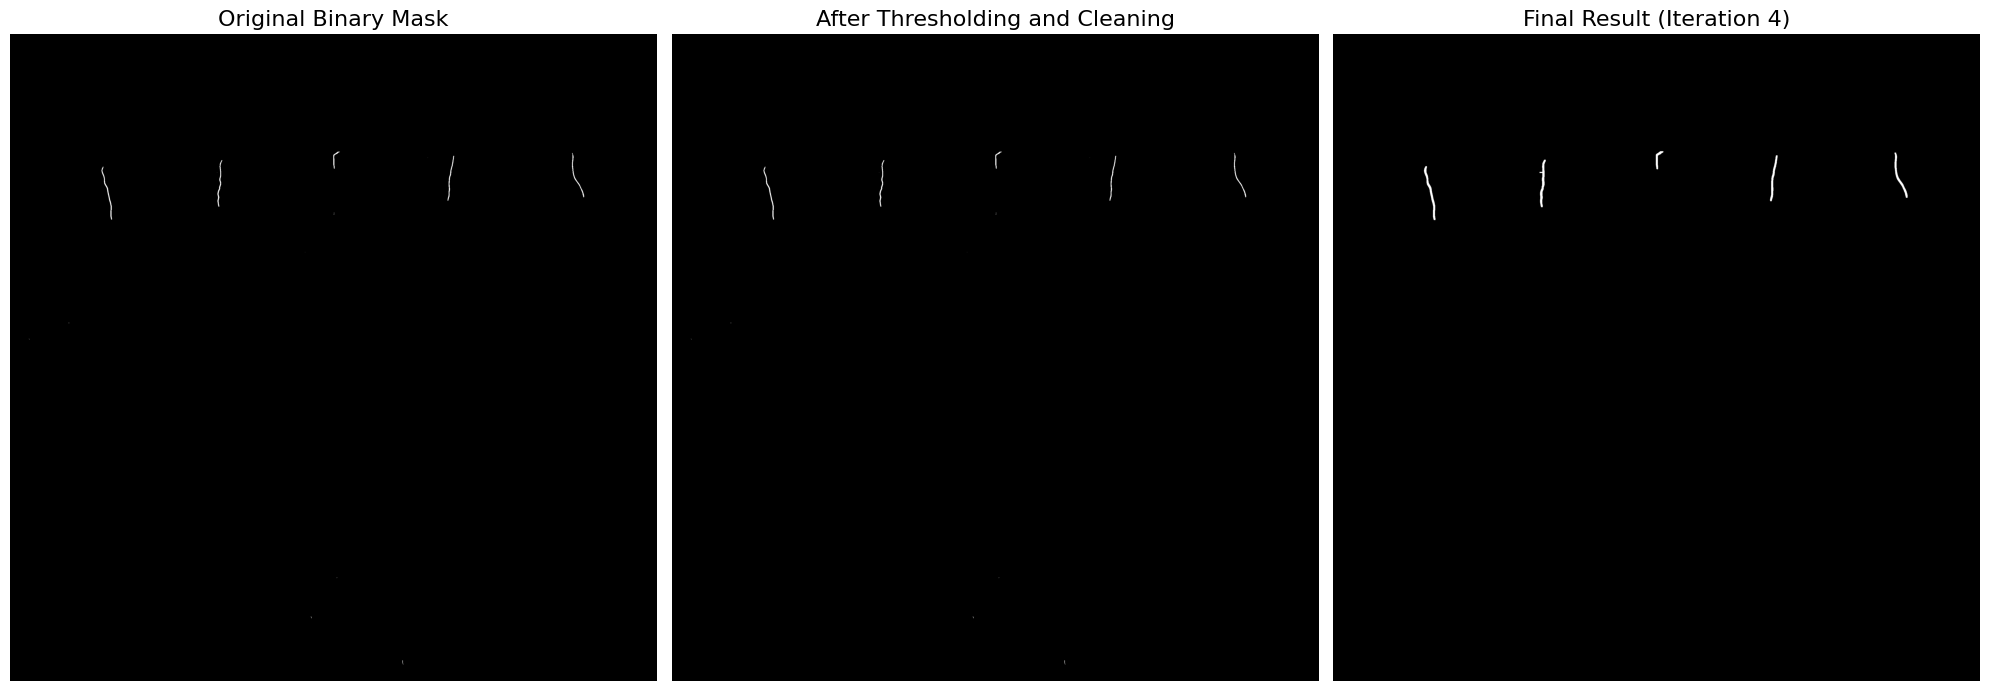

Processed test_image_5.png with Kernel Size = 5, Total Iterations = 4: Threshold = 0.5, Min Object Size = 200


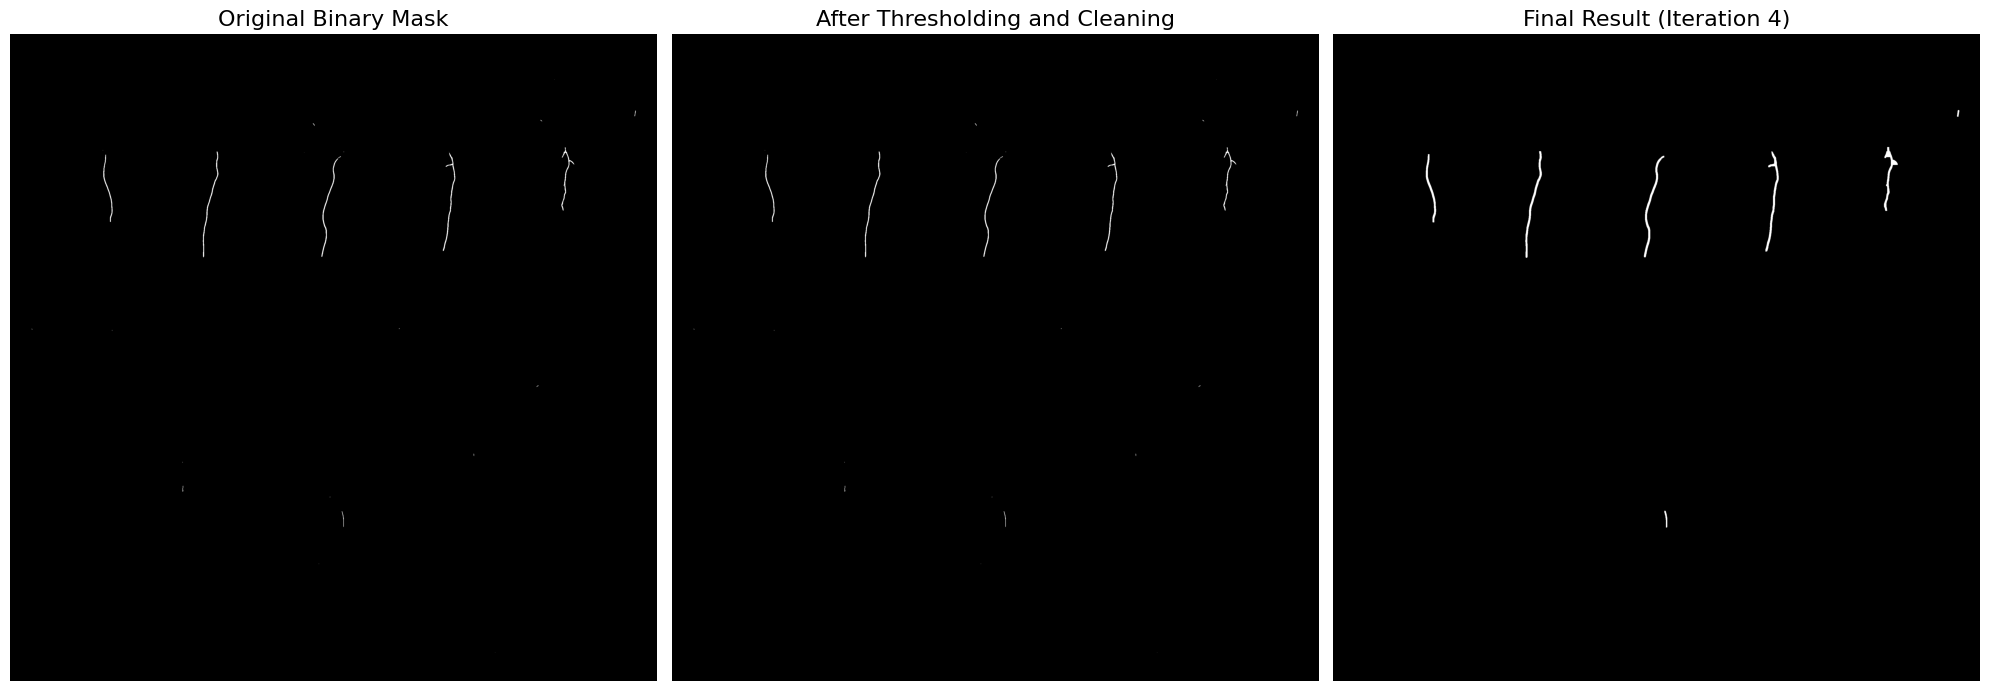

Processed test_image_6.png with Kernel Size = 5, Total Iterations = 4: Threshold = 0.5, Min Object Size = 200


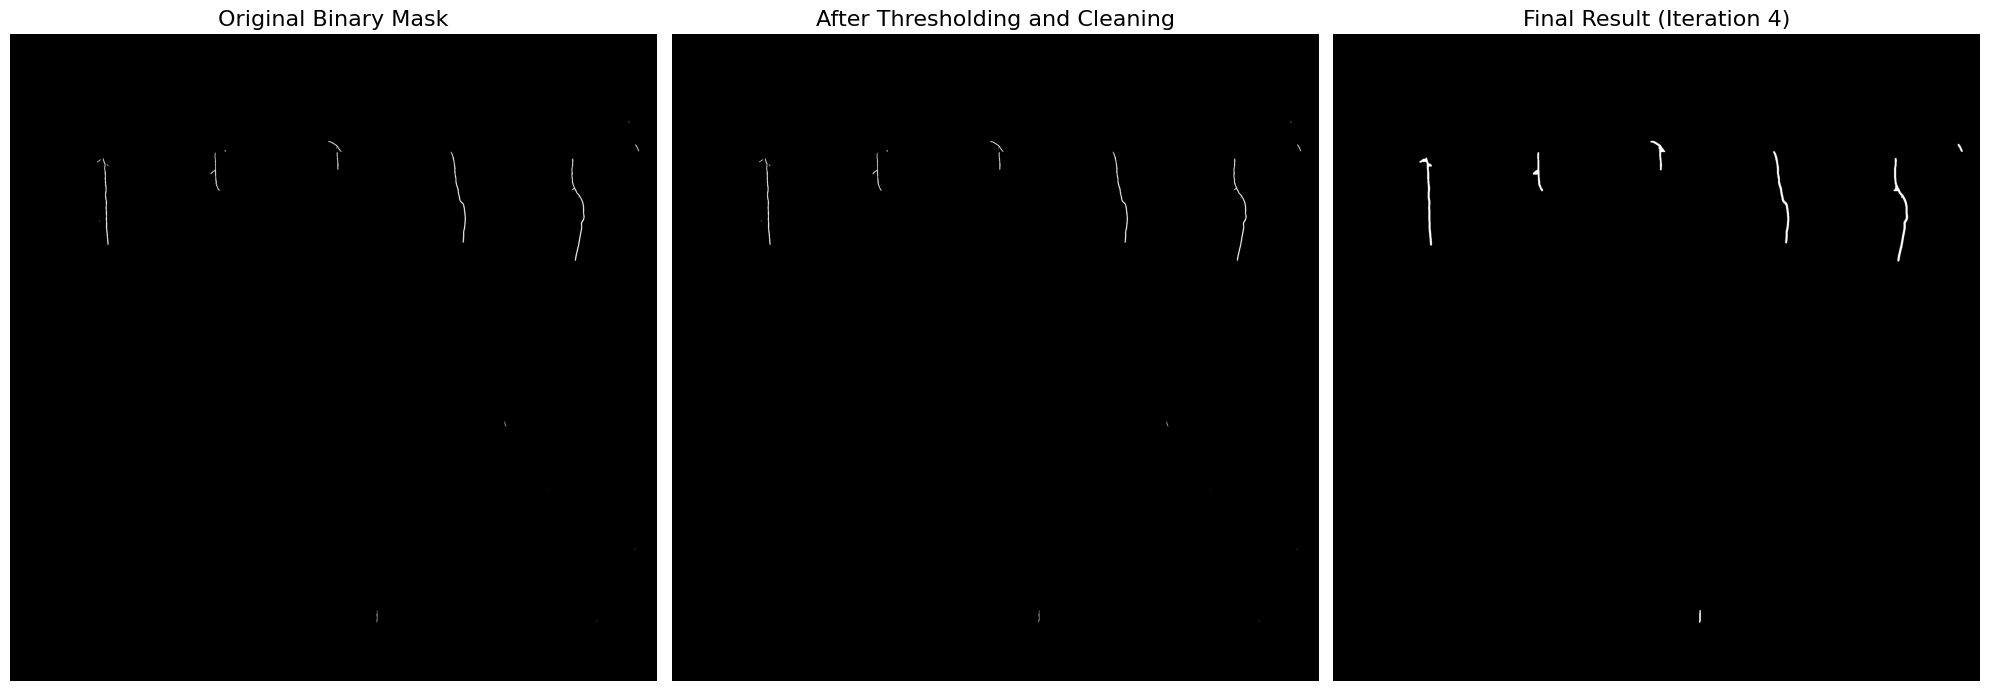

Processed test_image_7.png with Kernel Size = 5, Total Iterations = 4: Threshold = 0.5, Min Object Size = 200


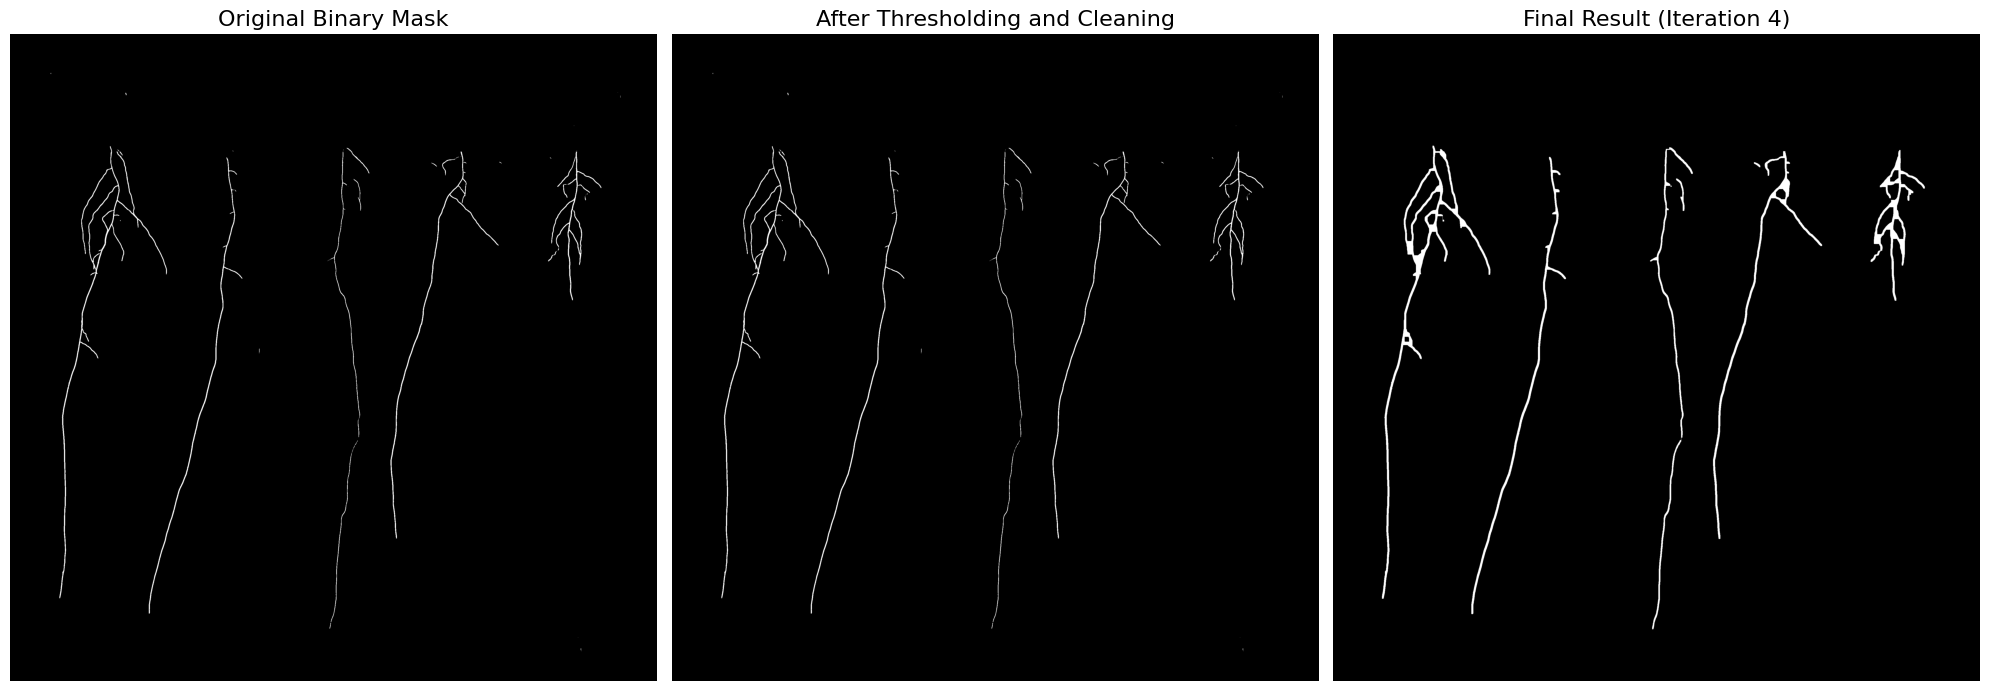

Processed test_image_8.png with Kernel Size = 5, Total Iterations = 4: Threshold = 0.5, Min Object Size = 200


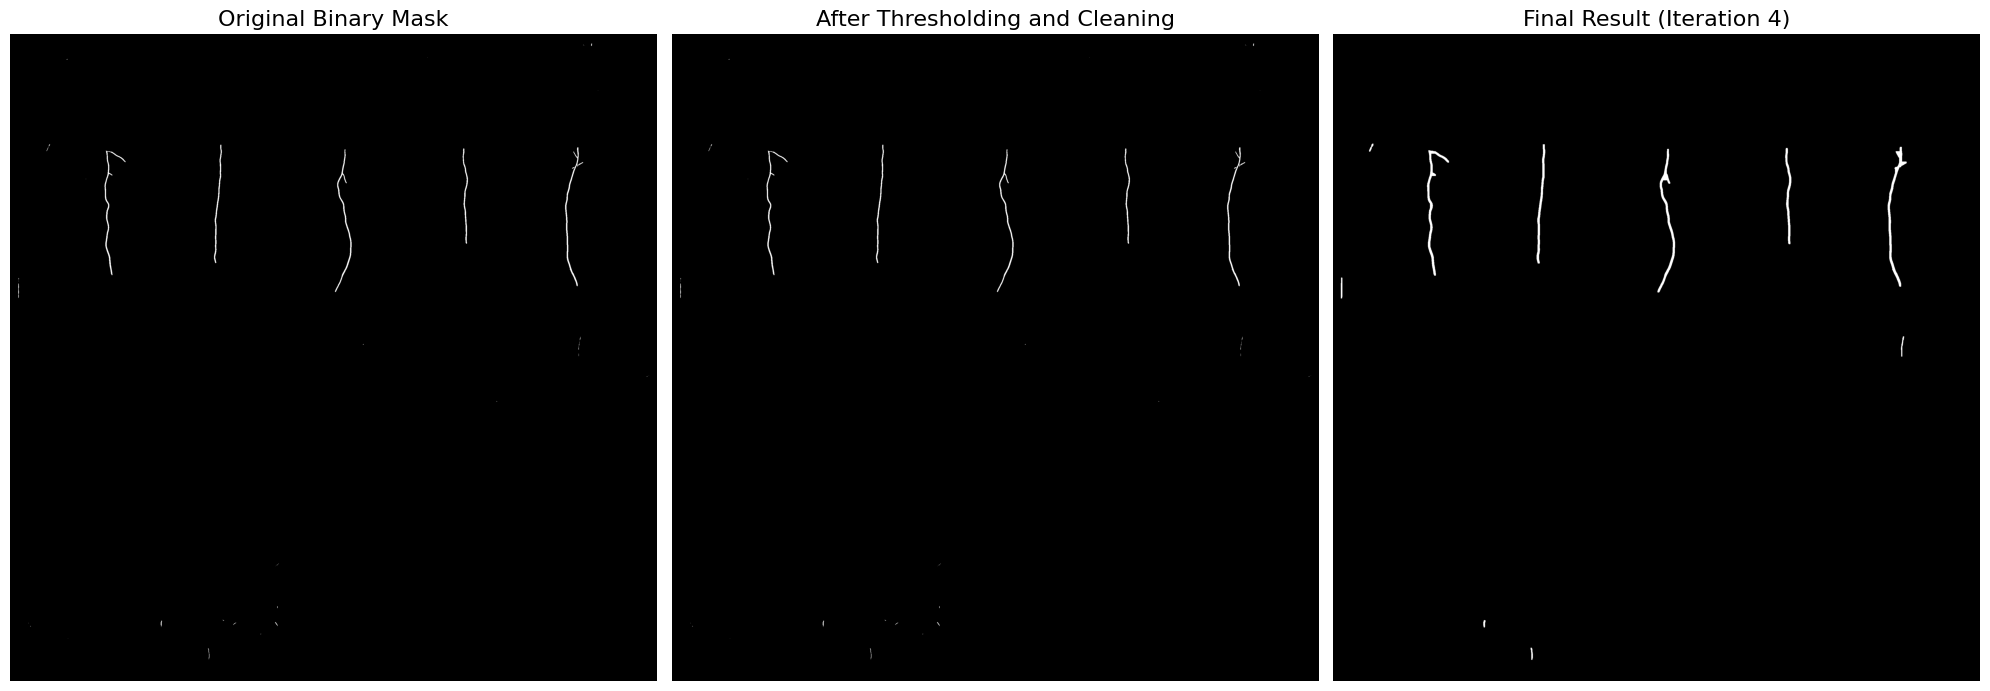

Processed test_image_9.png with Kernel Size = 5, Total Iterations = 4: Threshold = 0.5, Min Object Size = 200


In [50]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects

# Adjustable parameters
threshold_value = 0.5       # Adjust threshold value
kernel_size = 5           # Set kernel size for morphological closing
iterations = 4            # Number of iterations to apply morphological closing
min_object_size = 200      # Adjust minimum object size for small object removal

# Process each binary mask in binary_predictions
processed_masks = []
for filename, binary_mask in binary_predictions:
    # Step 1: Apply thresholding
    _, thresholded_mask = cv2.threshold(binary_mask, threshold_value, 255, cv2.THRESH_BINARY)

    # Step 2: Remove small objects immediately after thresholding
    binary_mask_boolean = thresholded_mask > 0  # Convert to boolean (True for object pixels)
    cleaned_mask_after_thresholding = (binary_mask_boolean * 255).astype(np.uint8)  # Convert back to uint8

    # Step 3: Apply dilation before morphological closing to connect components
    dilation_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    dilated_mask = cv2.dilate(cleaned_mask_after_thresholding, dilation_kernel, iterations=1)

    final_cleaned_mask = None
    for i in range(iterations):
        # Step 4: Apply morphological closing with the same kernel size for multiple iterations
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
        closed_mask = cv2.morphologyEx(dilated_mask, cv2.MORPH_CLOSE, kernel, iterations=i+1)

        # Step 5: Remove small objects after morphological closing
        binary_mask_boolean = closed_mask > 0  # Convert to boolean (True for object pixels)
        cleaned_mask = remove_small_objects(binary_mask_boolean, min_size=min_object_size)
        final_cleaned_mask = (cleaned_mask * 255).astype(np.uint8)  # Convert back to uint8

        # Store the result of the last iteration
        if i == iterations - 1:
            processed_masks.append((filename, final_cleaned_mask))

    # Step 6: Post-processing with dilation followed by erosion (opening)
    post_dilation_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    post_dilated_mask = cv2.dilate(final_cleaned_mask, post_dilation_kernel, iterations=1)
    post_eroded_mask = cv2.erode(post_dilated_mask, post_dilation_kernel, iterations=1)

    # Update the final cleaned mask after post-processing
    final_cleaned_mask = post_eroded_mask

    # Plot final result only
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 3, 1)
    plt.title("Original Binary Mask", fontsize=16)
    plt.imshow(binary_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("After Thresholding and Cleaning", fontsize=16)
    plt.imshow(cleaned_mask_after_thresholding, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title(f"Final Result (Iteration {iterations})", fontsize=16)
    plt.imshow(final_cleaned_mask, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print(f"Processed {filename} with Kernel Size = {kernel_size}, Total Iterations = {iterations}: Threshold = {threshold_value}, Min Object Size = {min_object_size}")


Filename: test_image_1.png | Number of connected components: 4


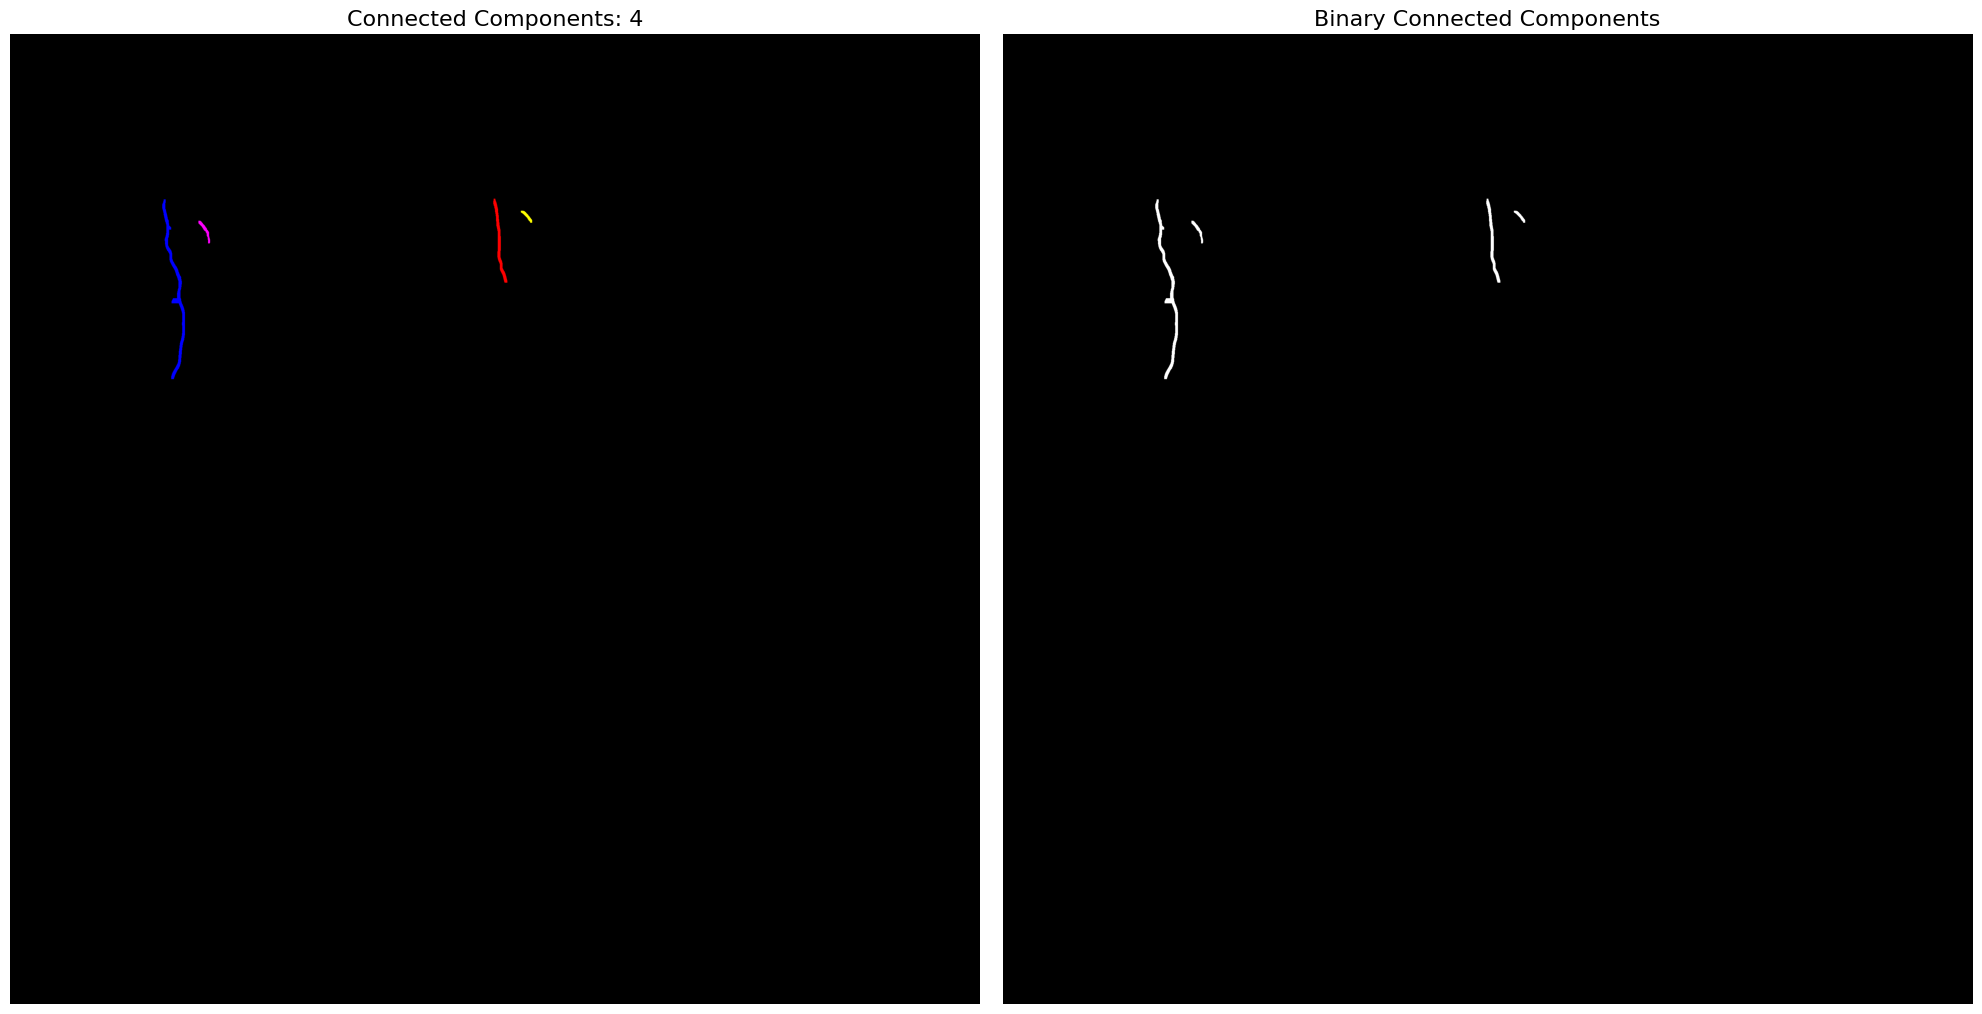

Filename: test_image_10.png | Number of connected components: 31


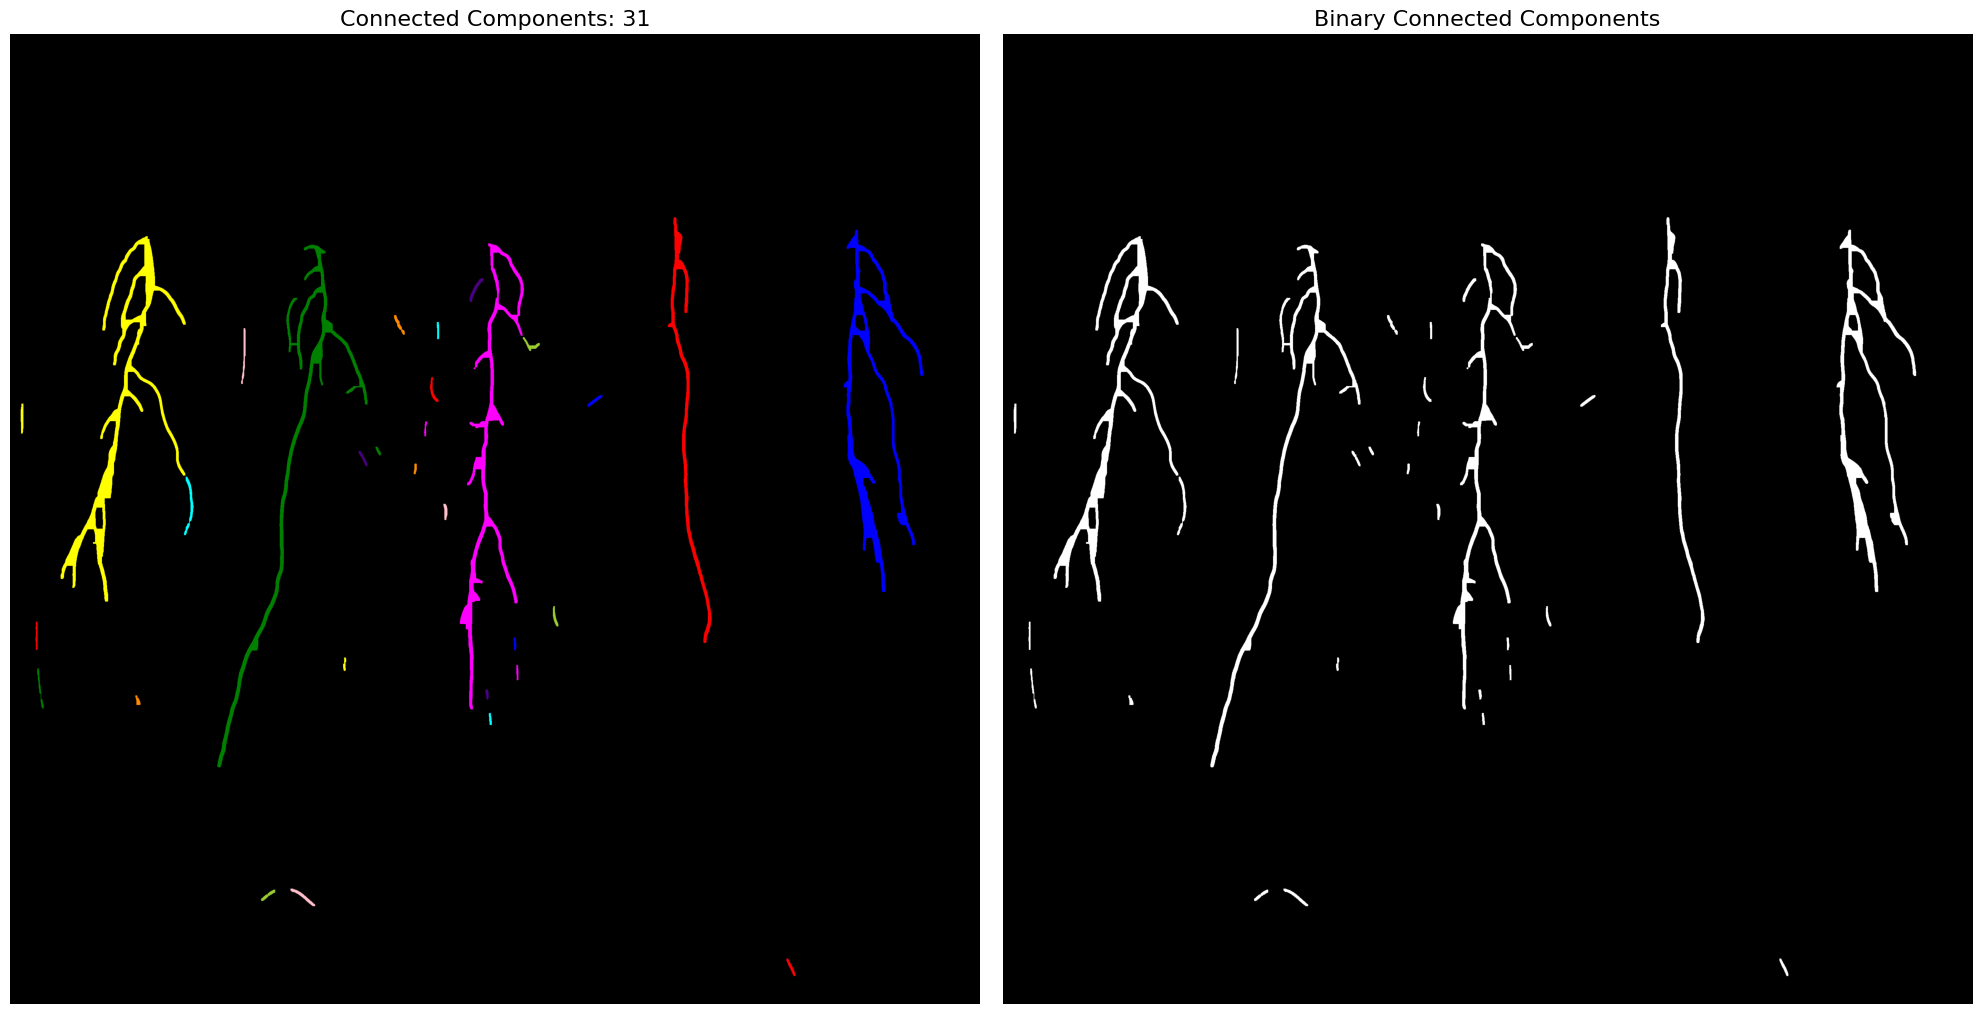

Filename: test_image_11.png | Number of connected components: 18


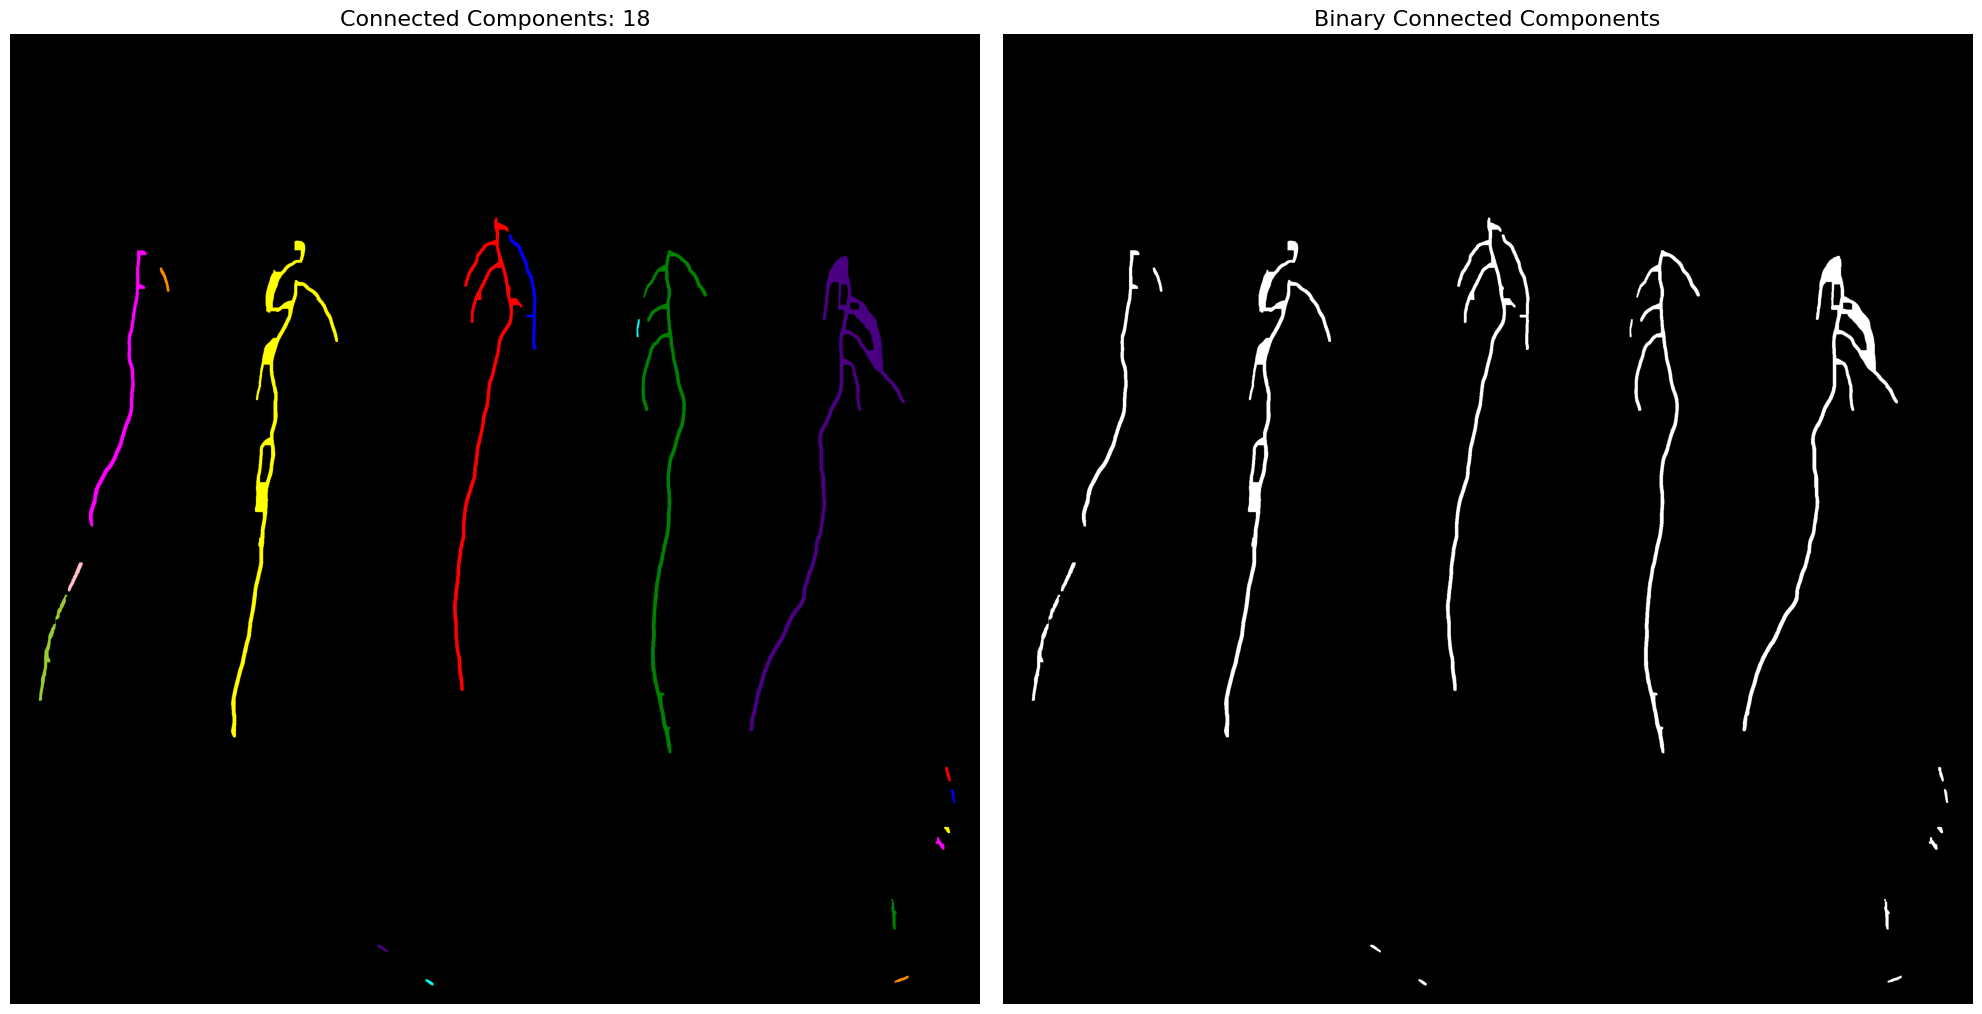

Filename: test_image_12.png | Number of connected components: 15


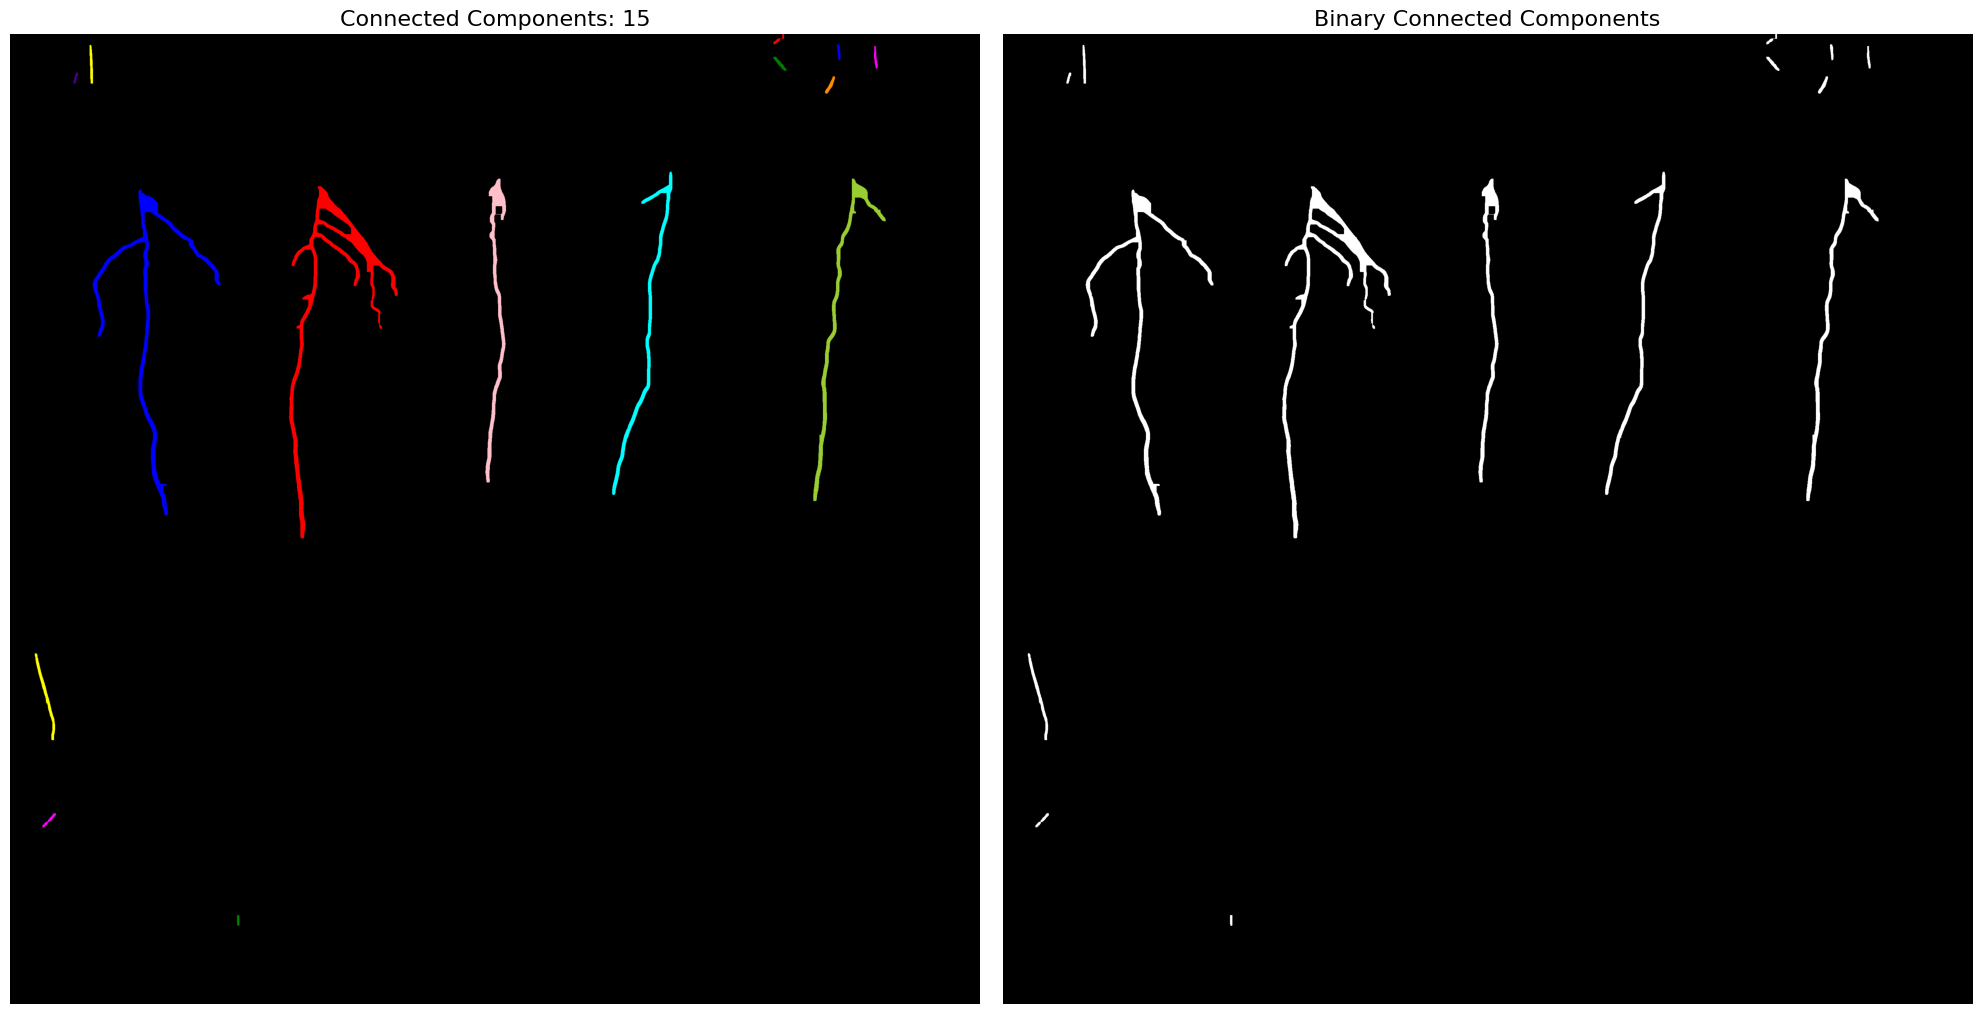

Filename: test_image_13.png | Number of connected components: 9


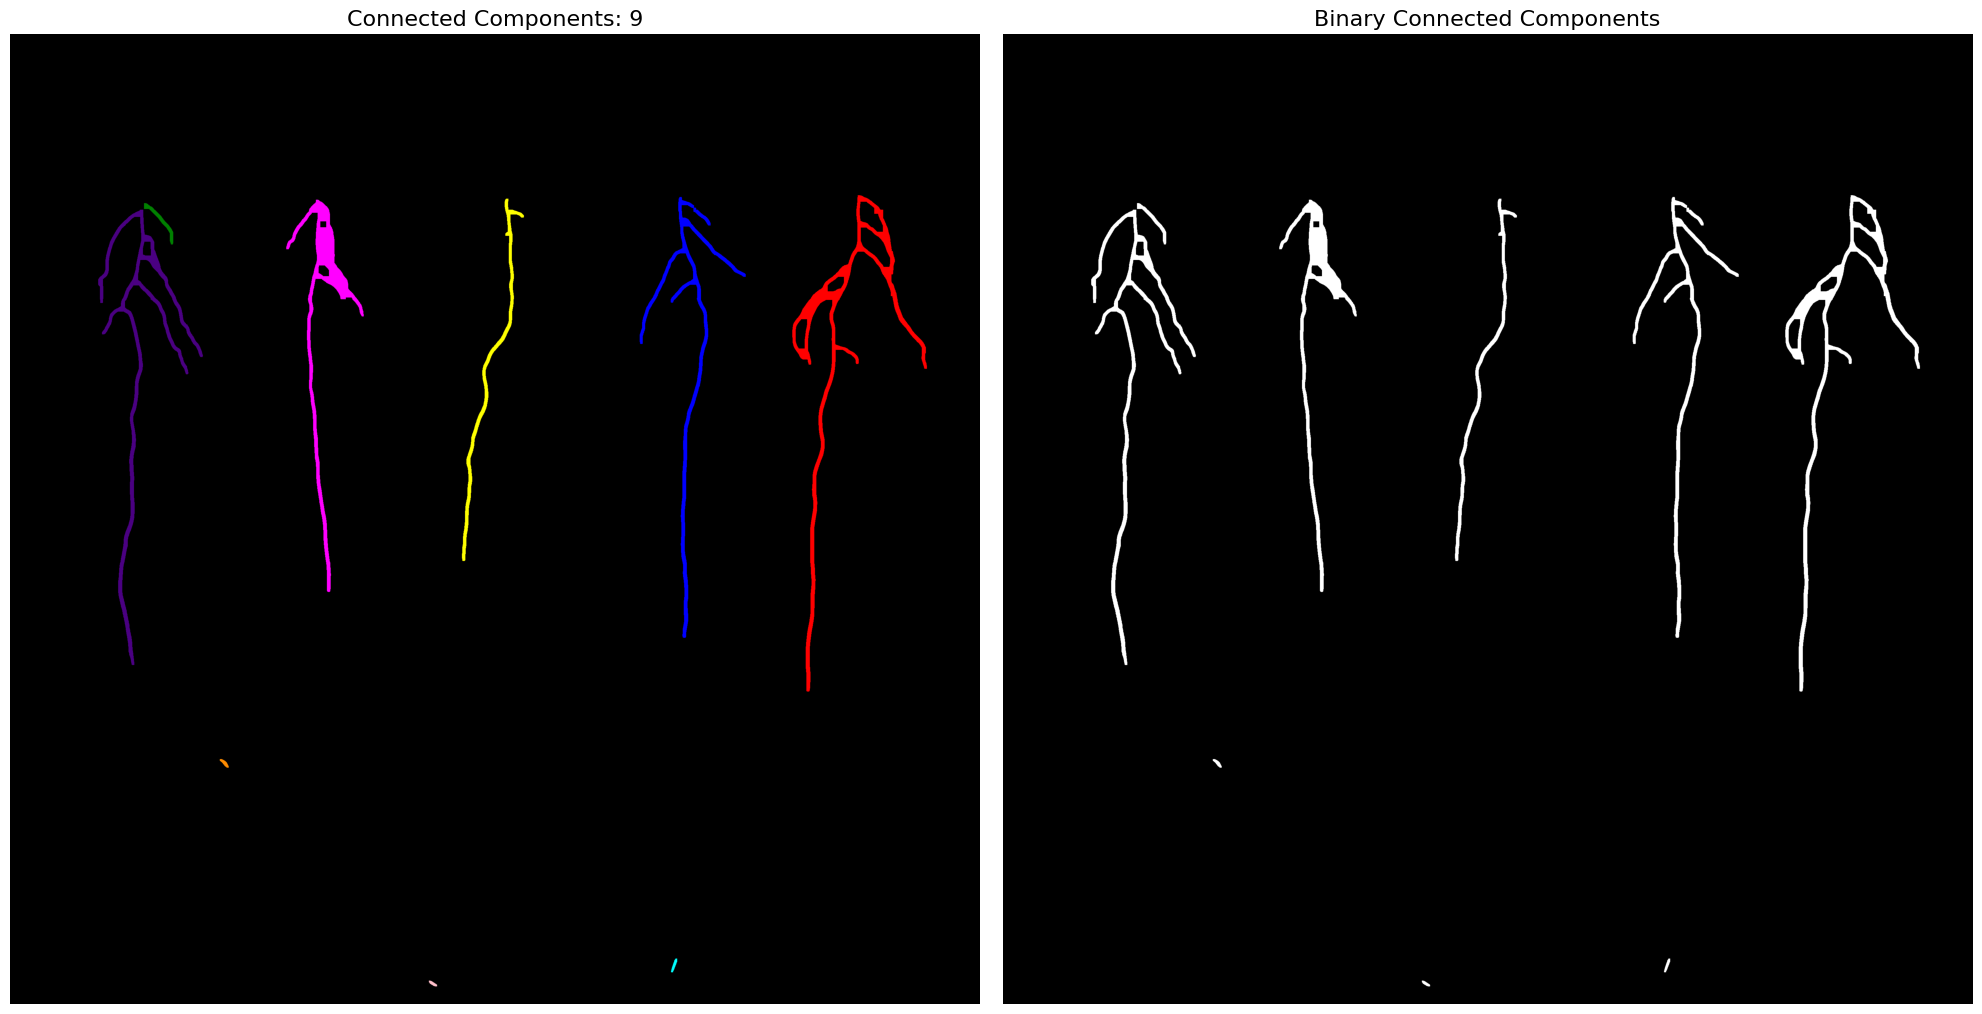

Filename: test_image_14.png | Number of connected components: 18


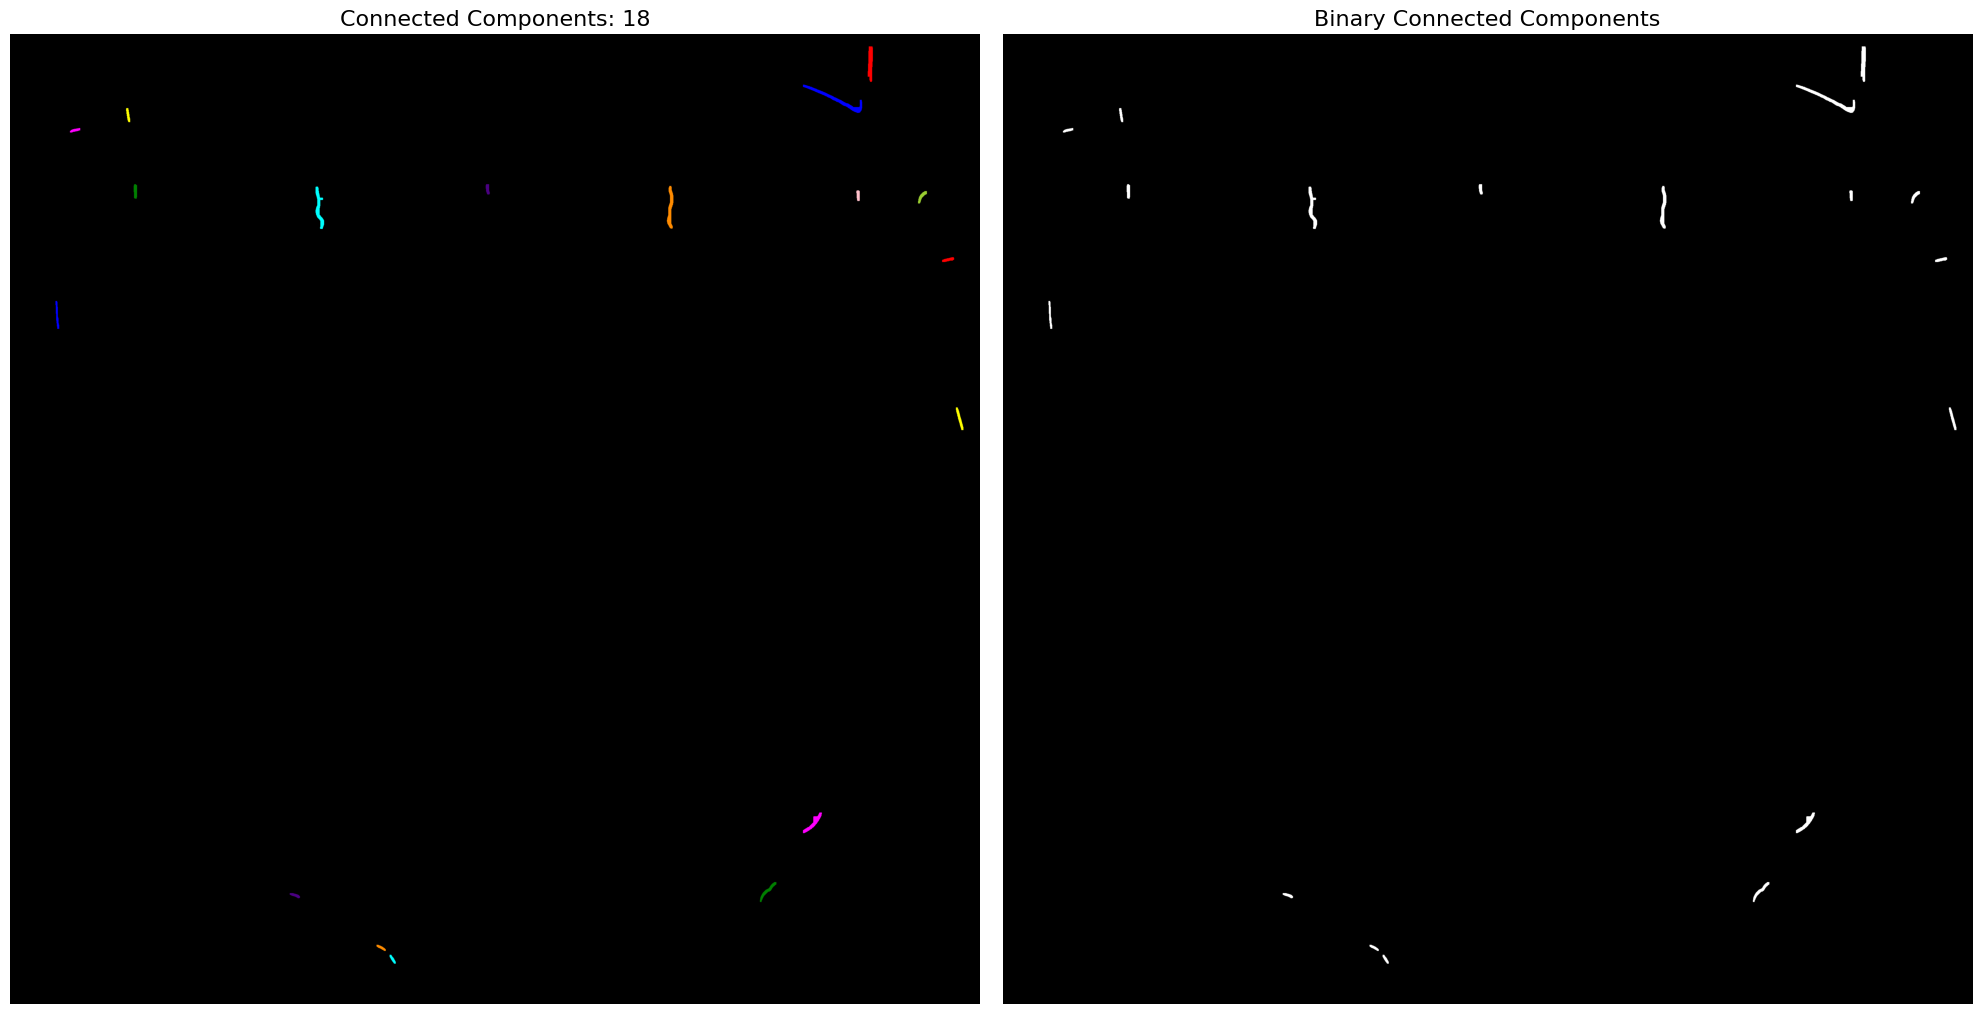

Filename: test_image_15.png | Number of connected components: 14


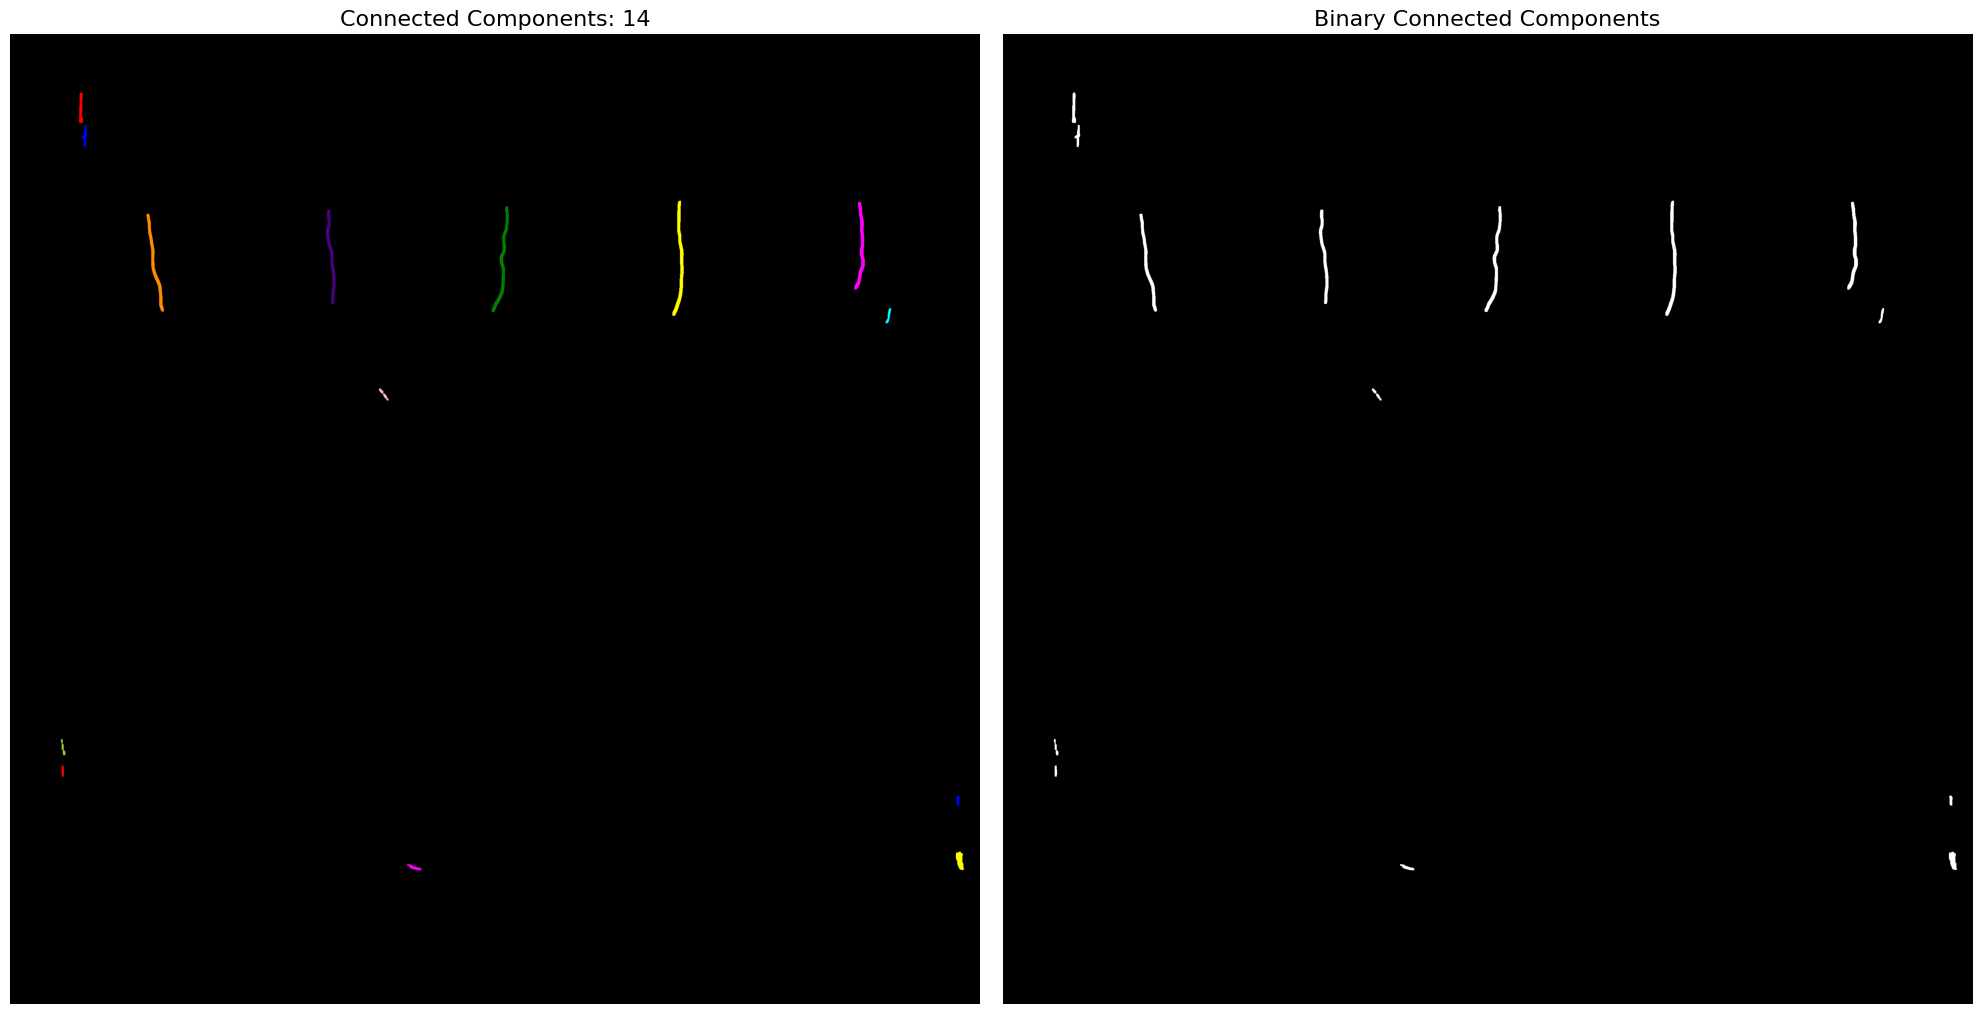

Filename: test_image_16.png | Number of connected components: 7


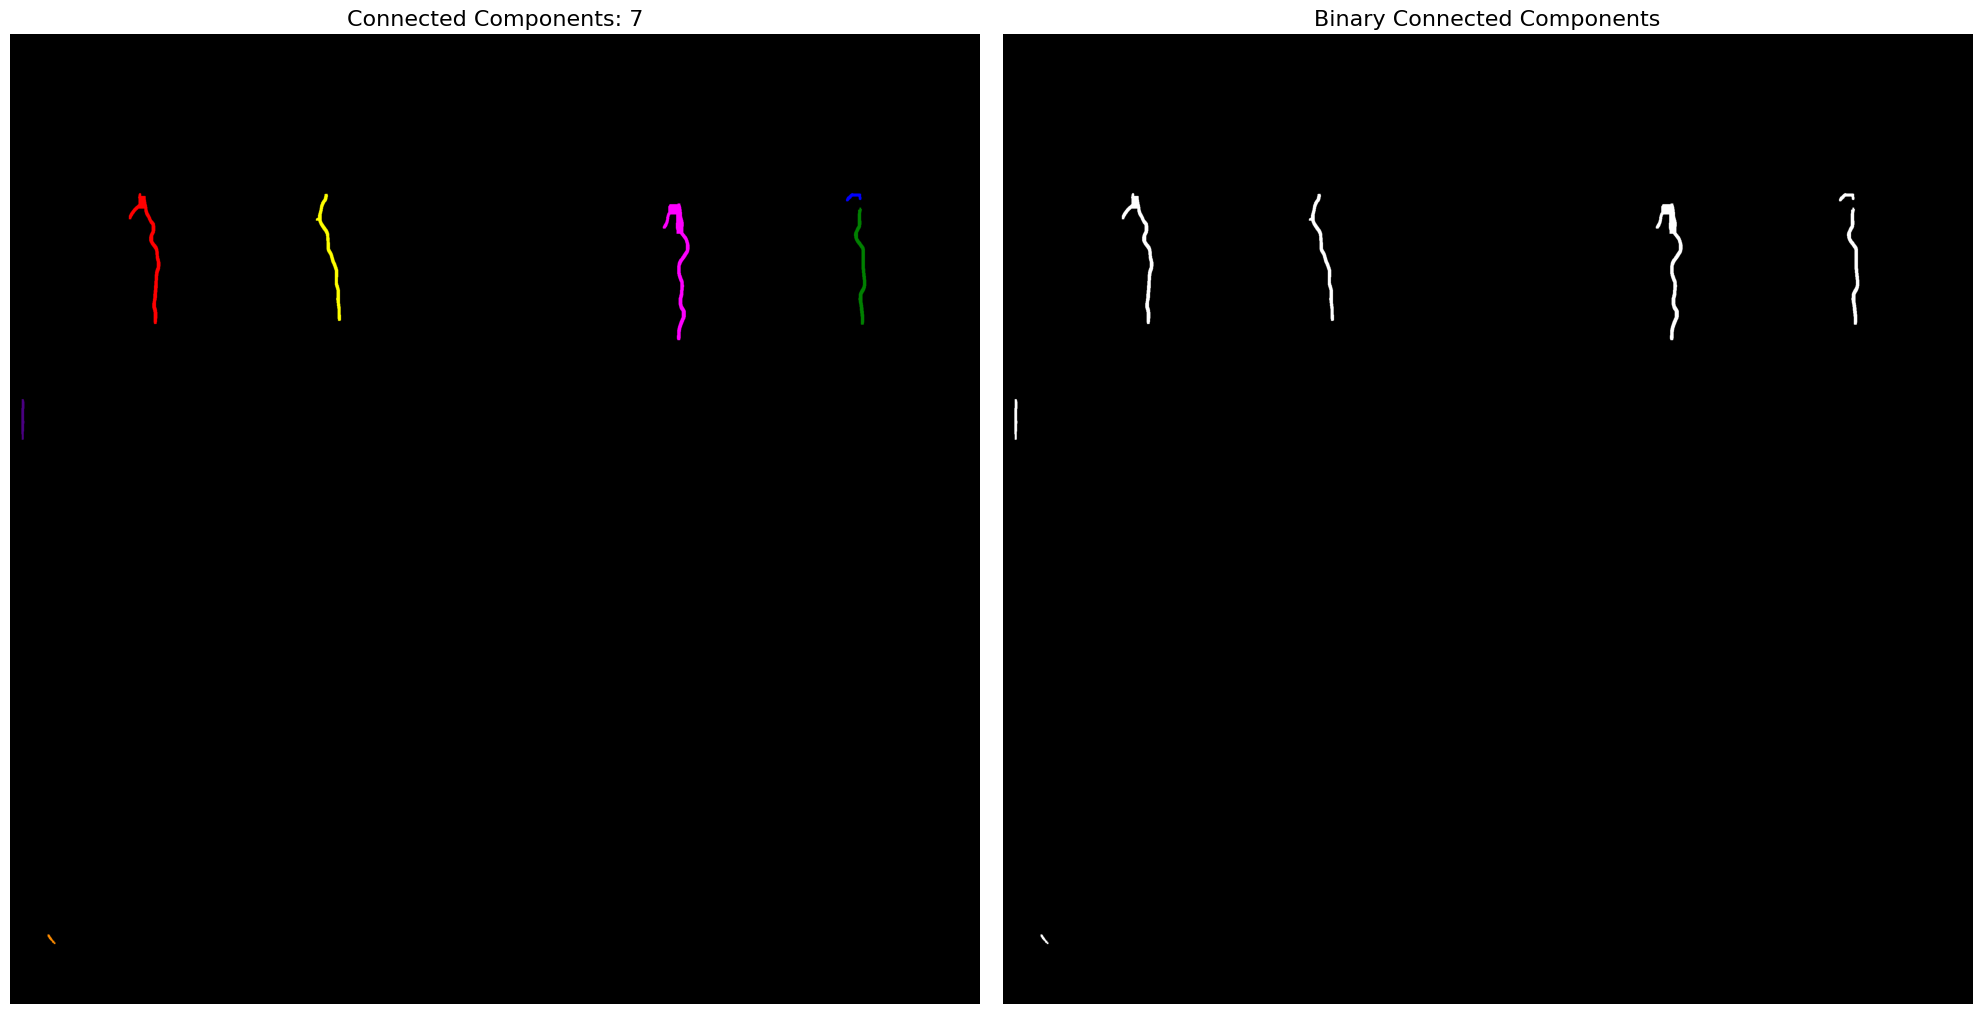

Filename: test_image_17.png | Number of connected components: 10


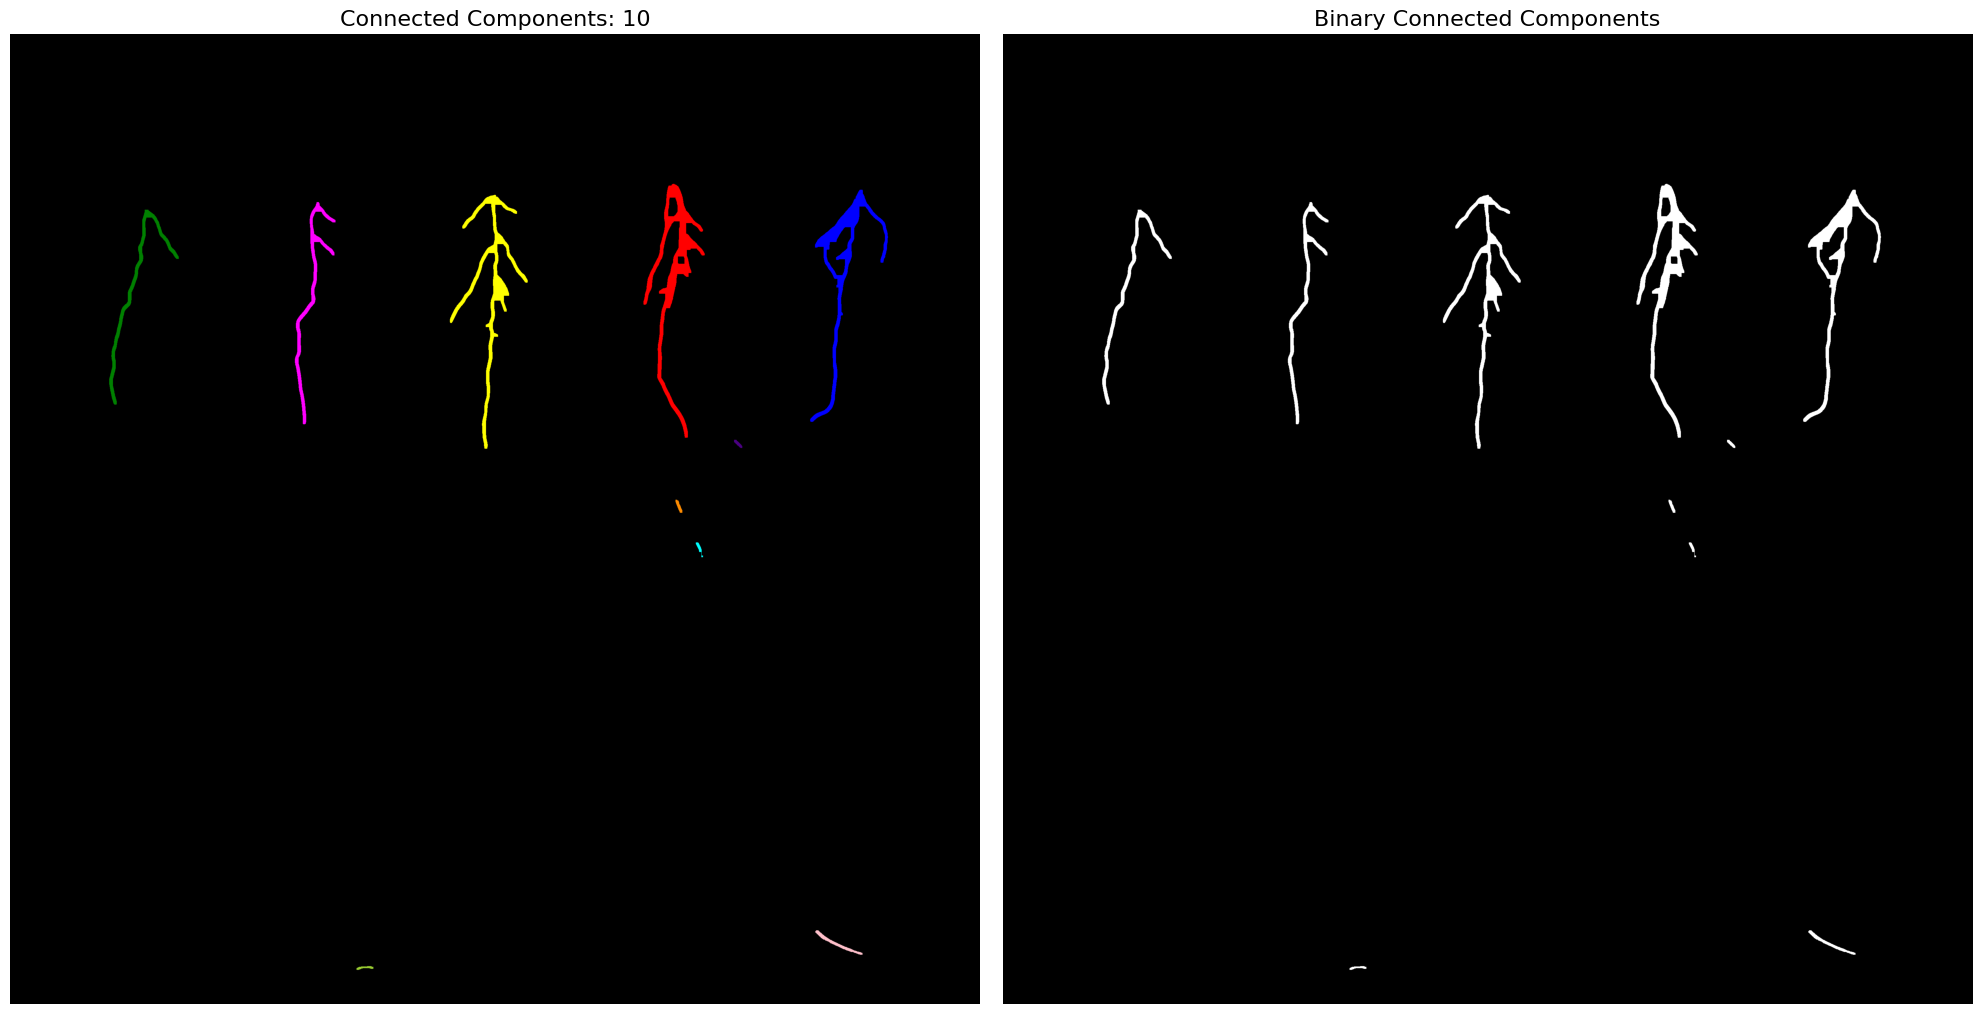

Filename: test_image_18.png | Number of connected components: 6


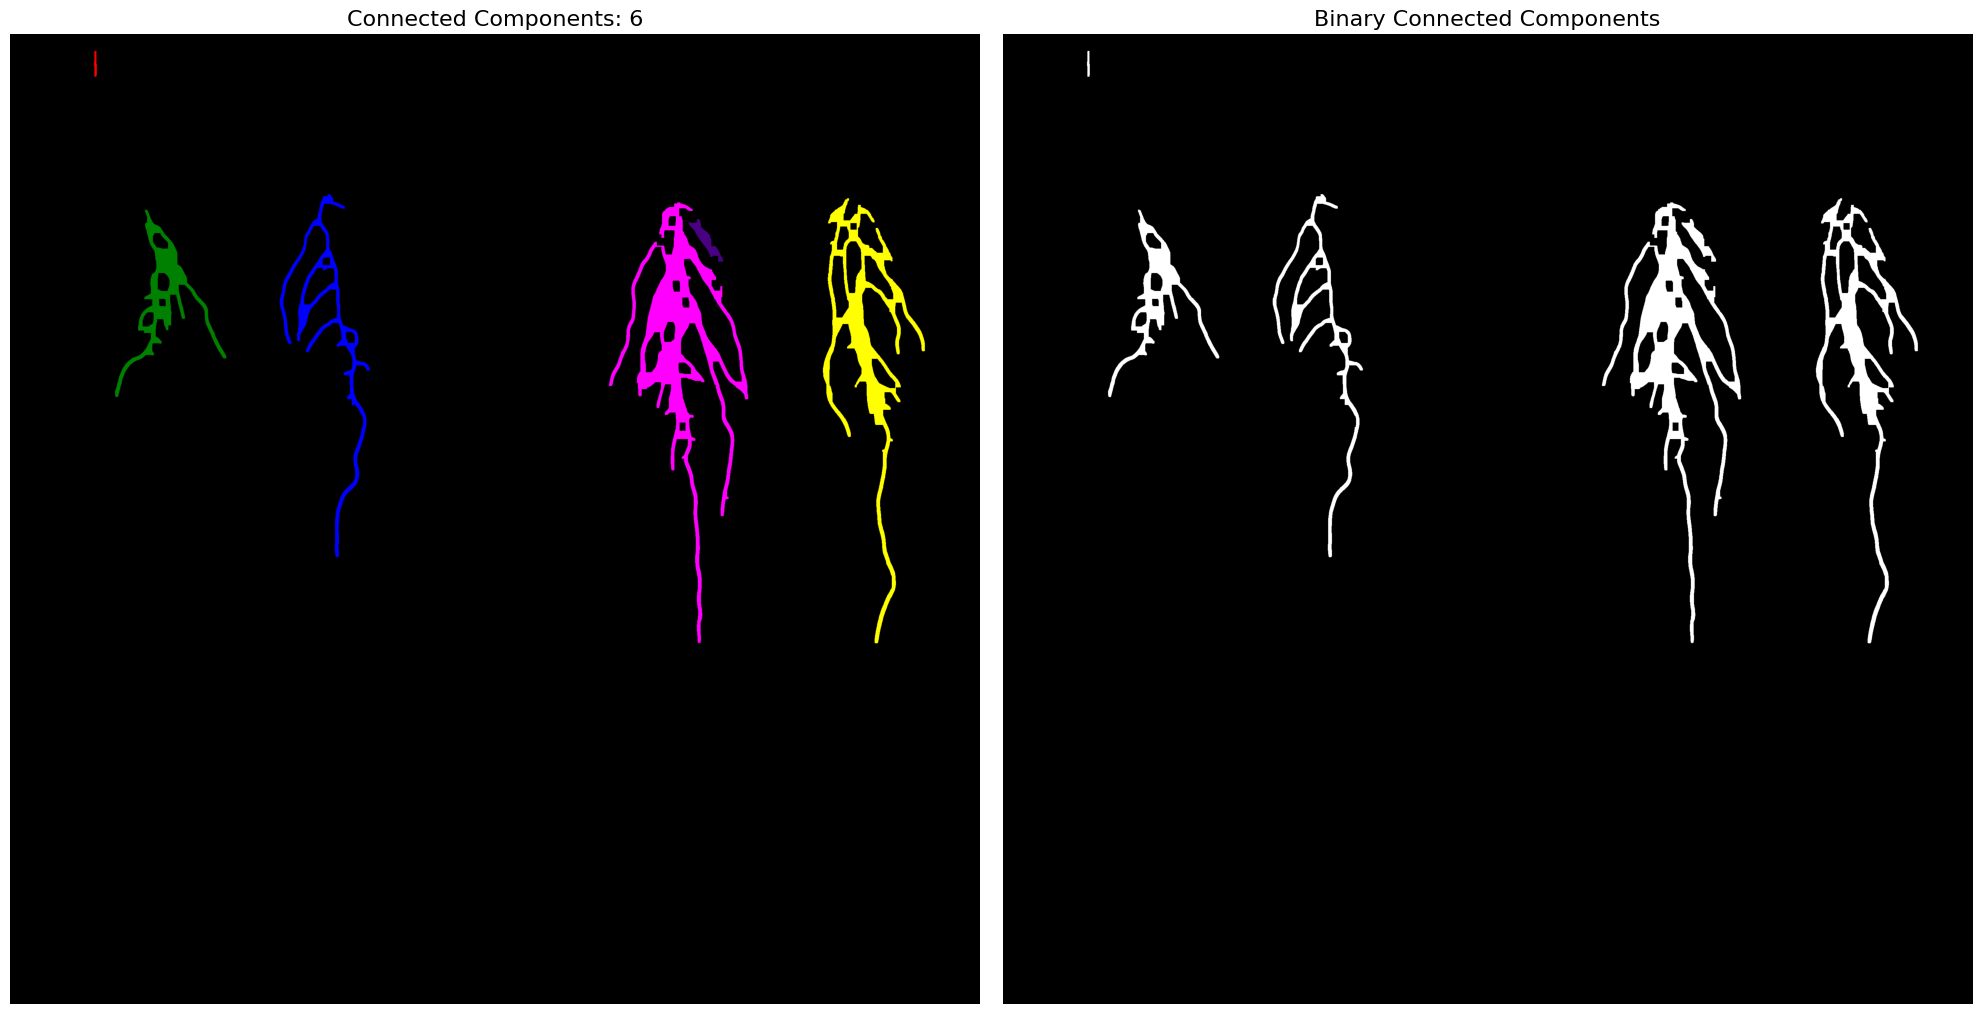

Filename: test_image_2.png | Number of connected components: 8


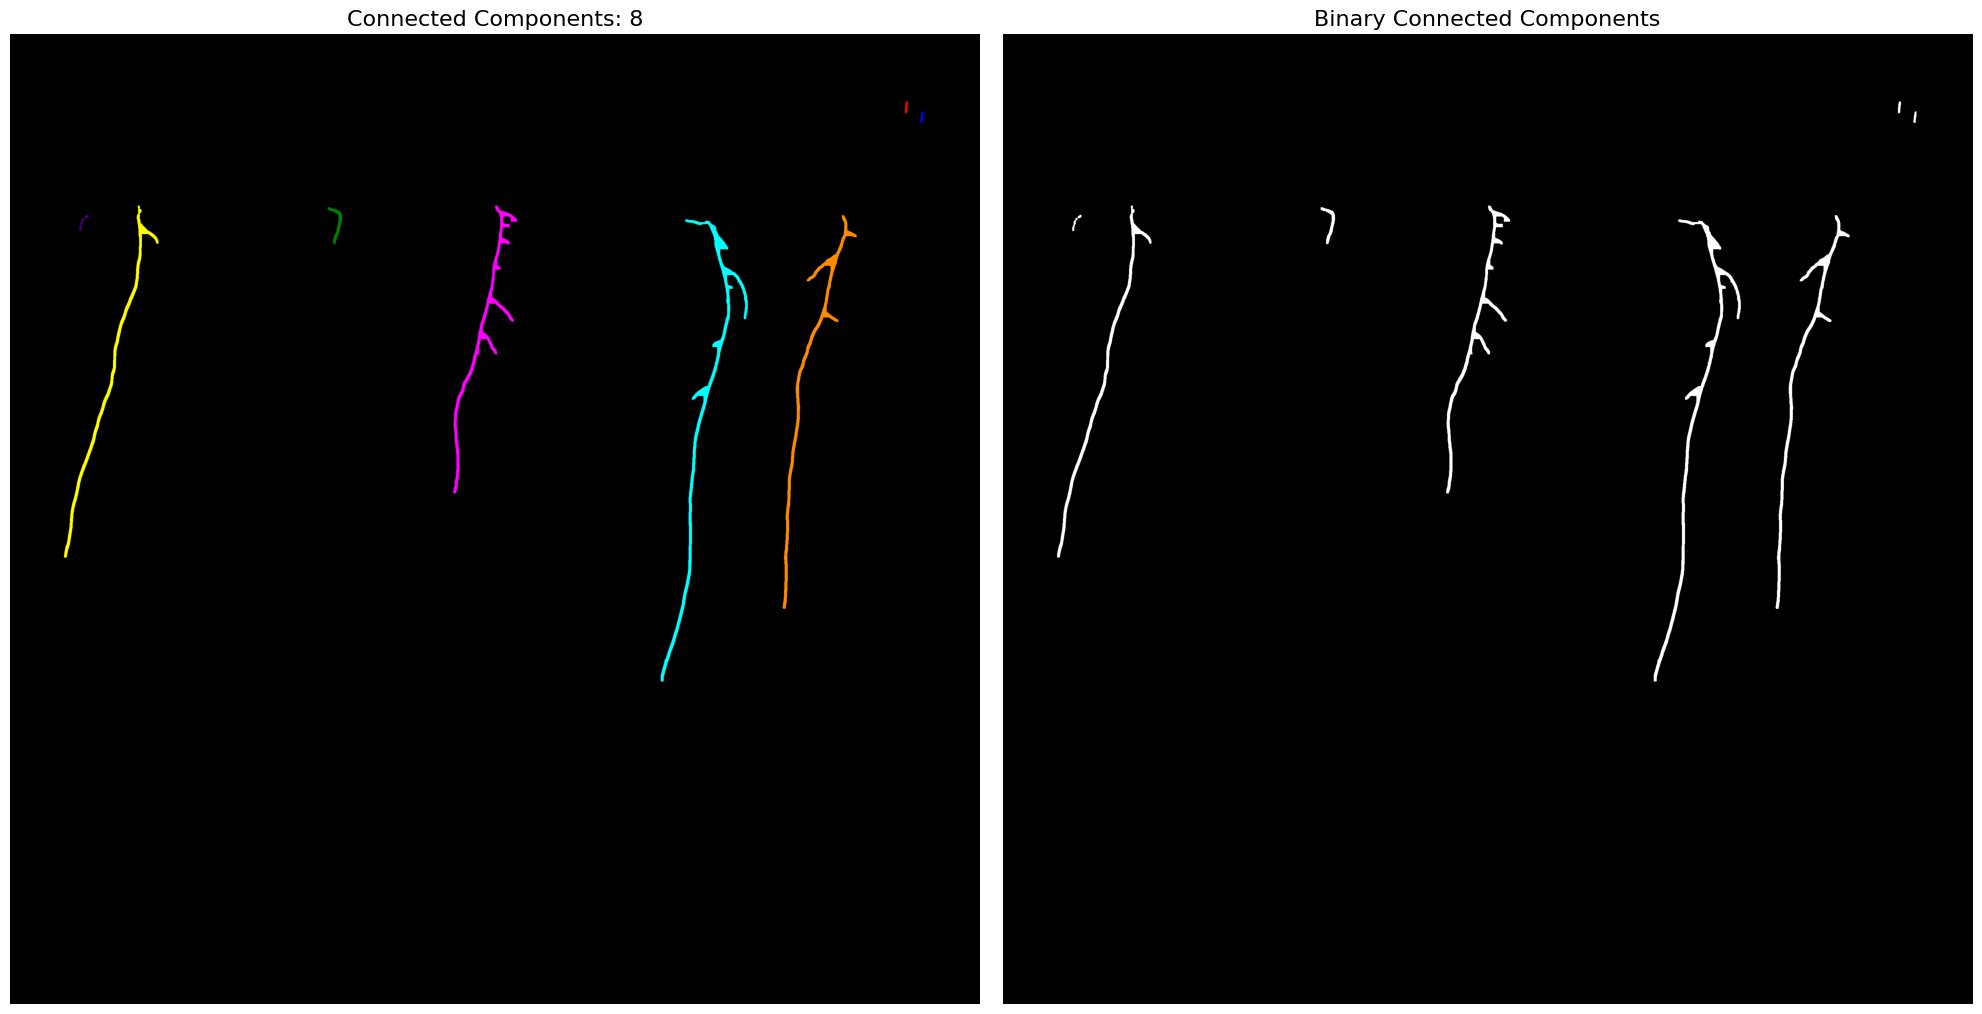

Filename: test_image_3.png | Number of connected components: 8


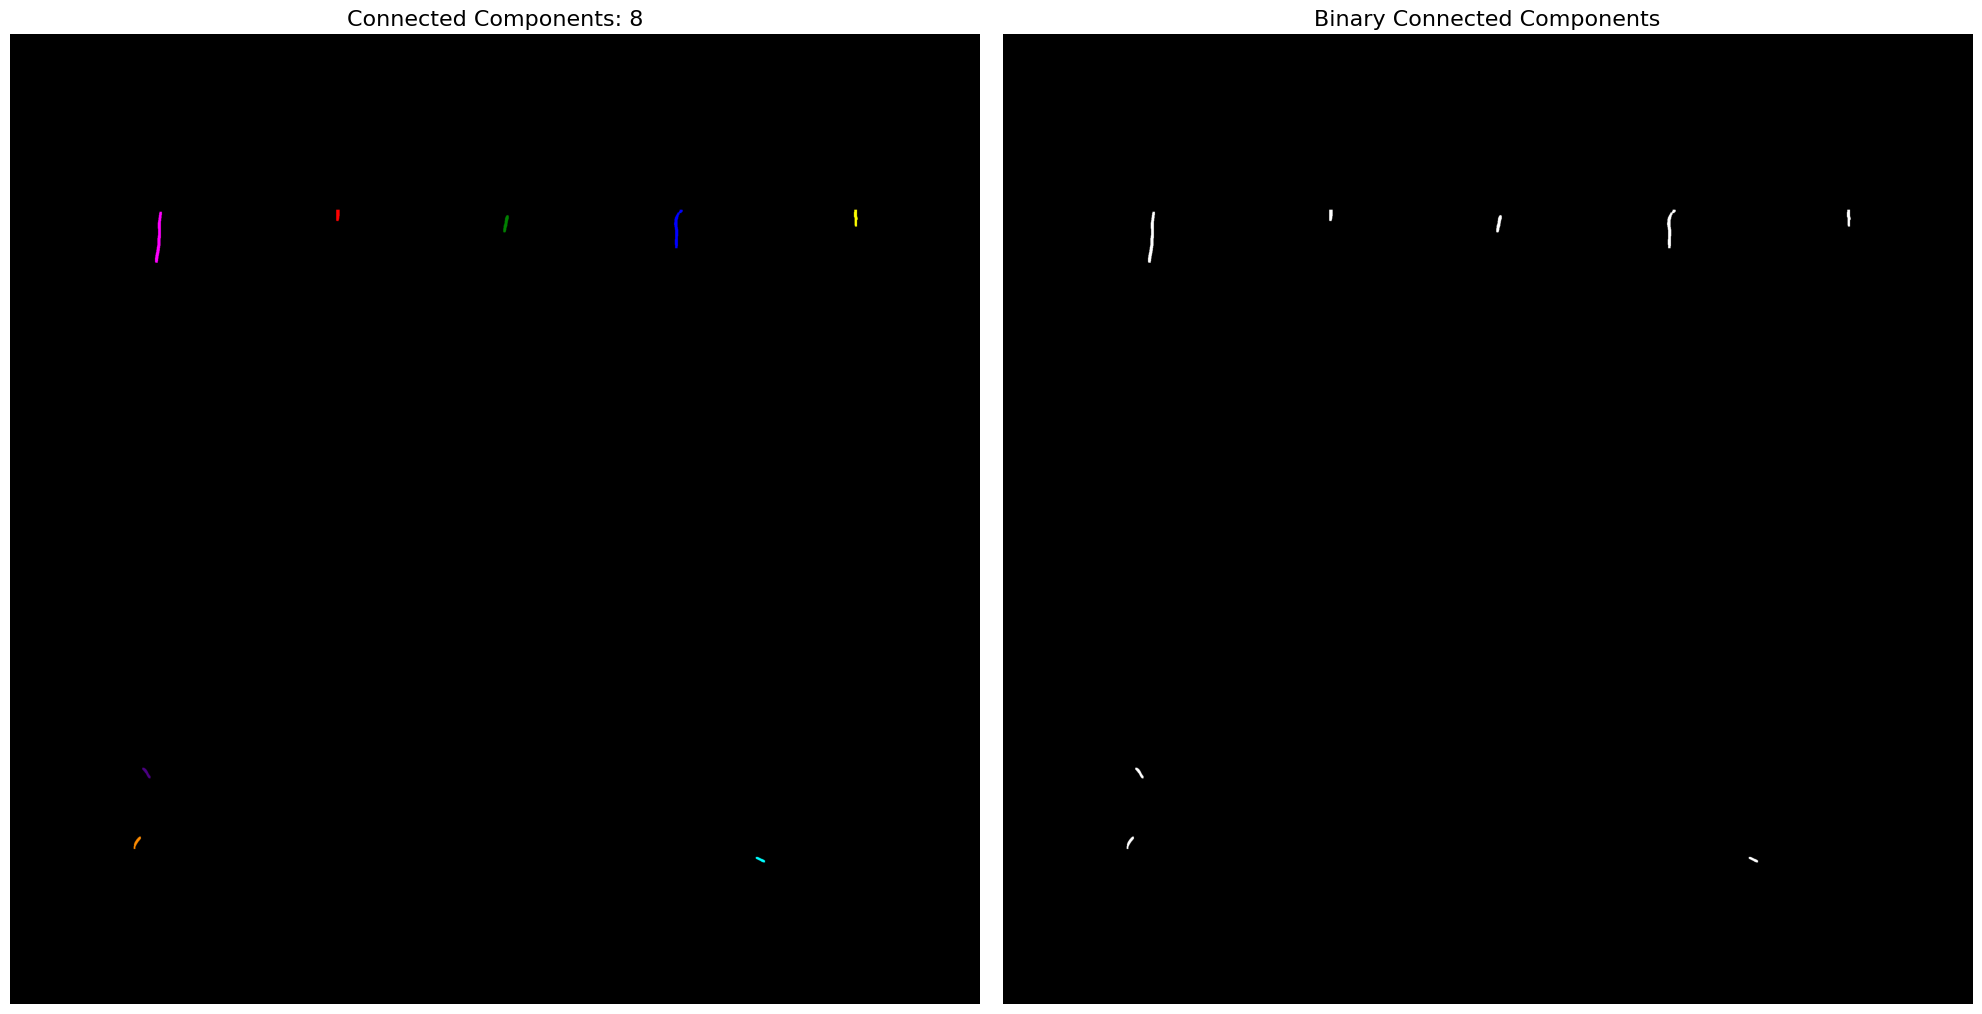

Filename: test_image_4.png | Number of connected components: 6


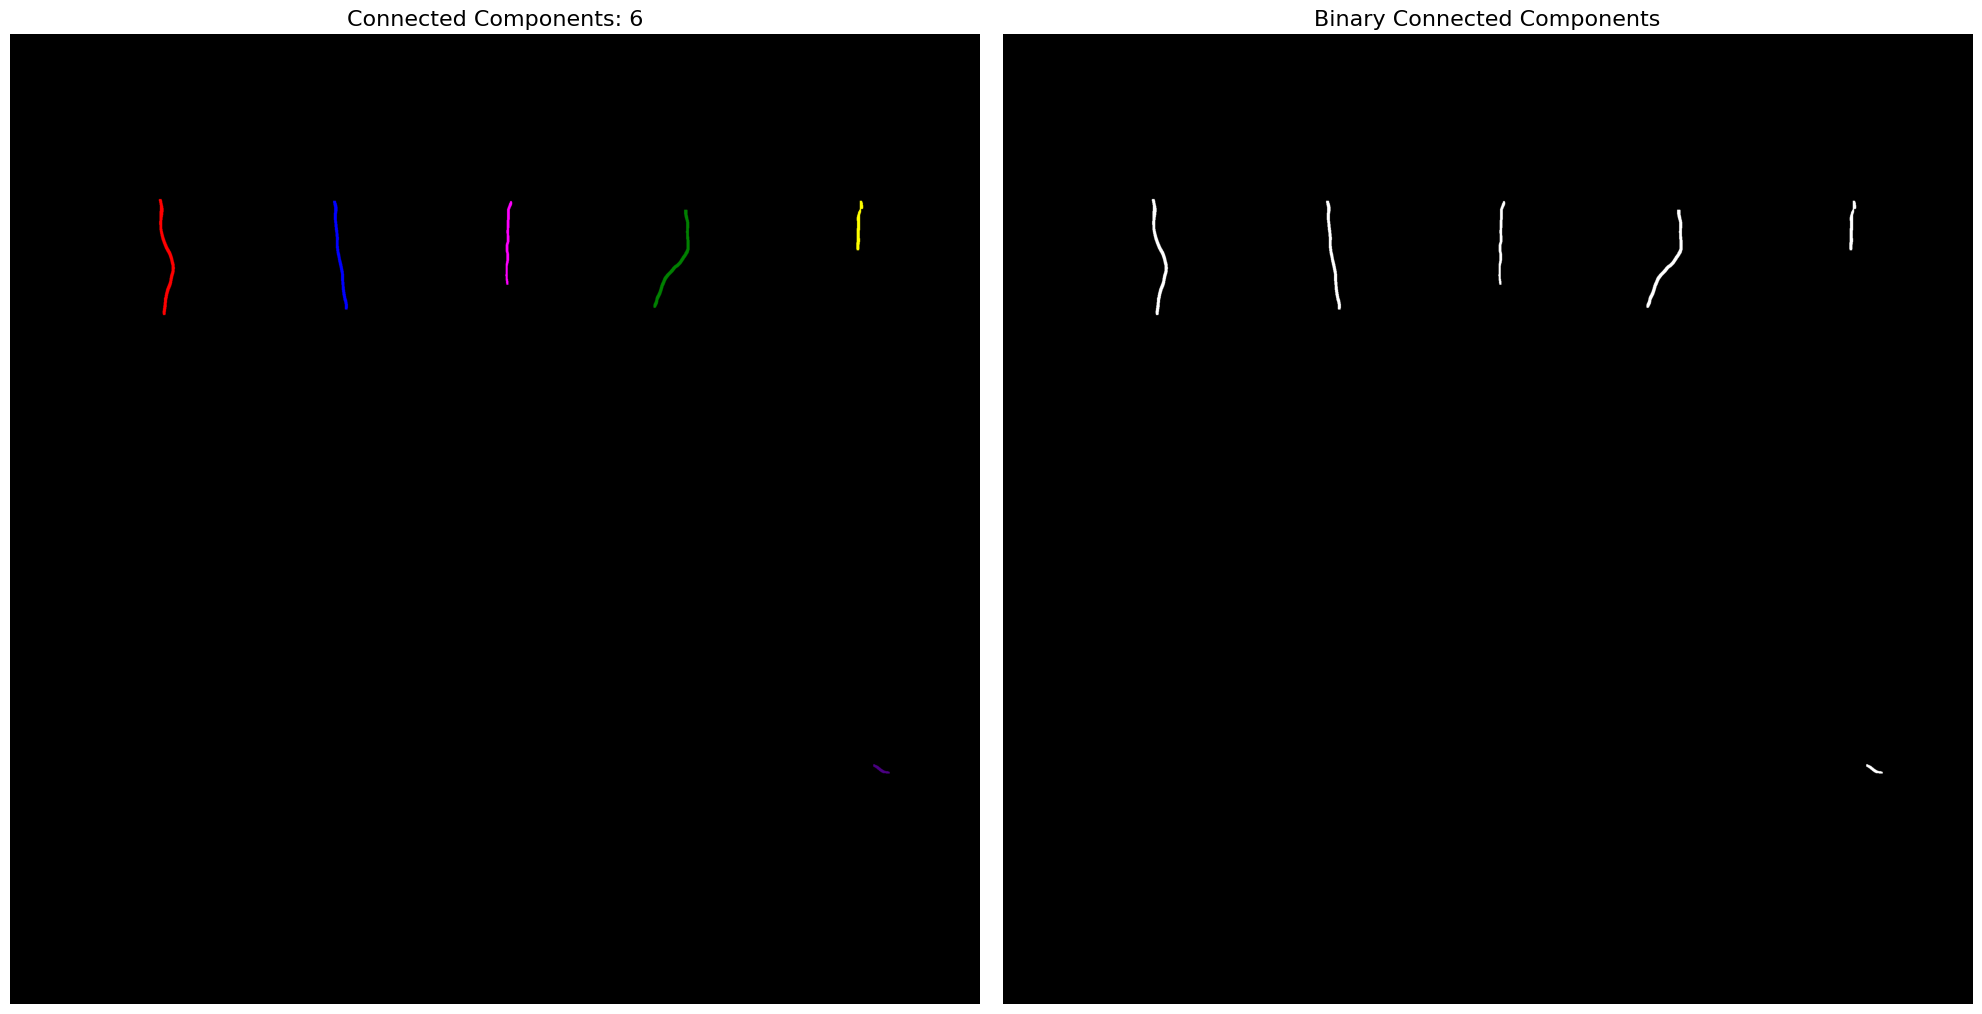

Filename: test_image_5.png | Number of connected components: 5


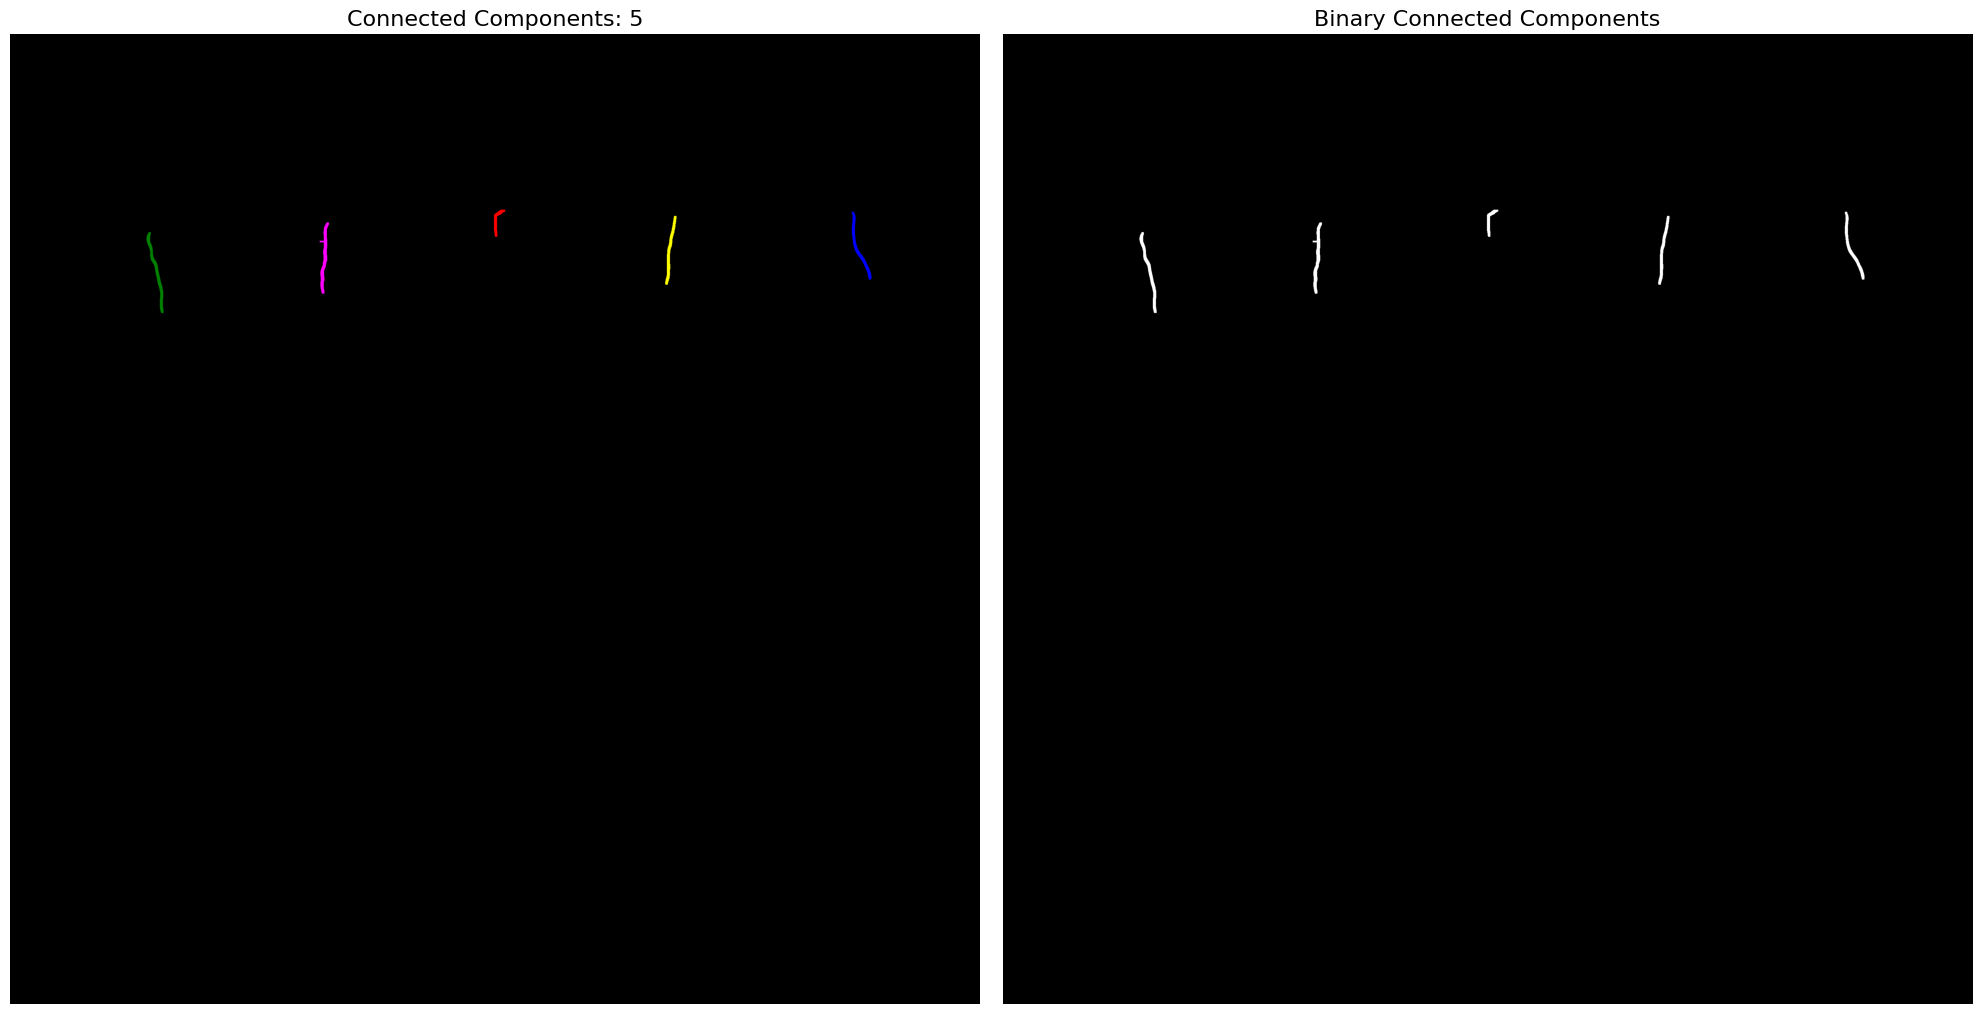

Filename: test_image_6.png | Number of connected components: 7


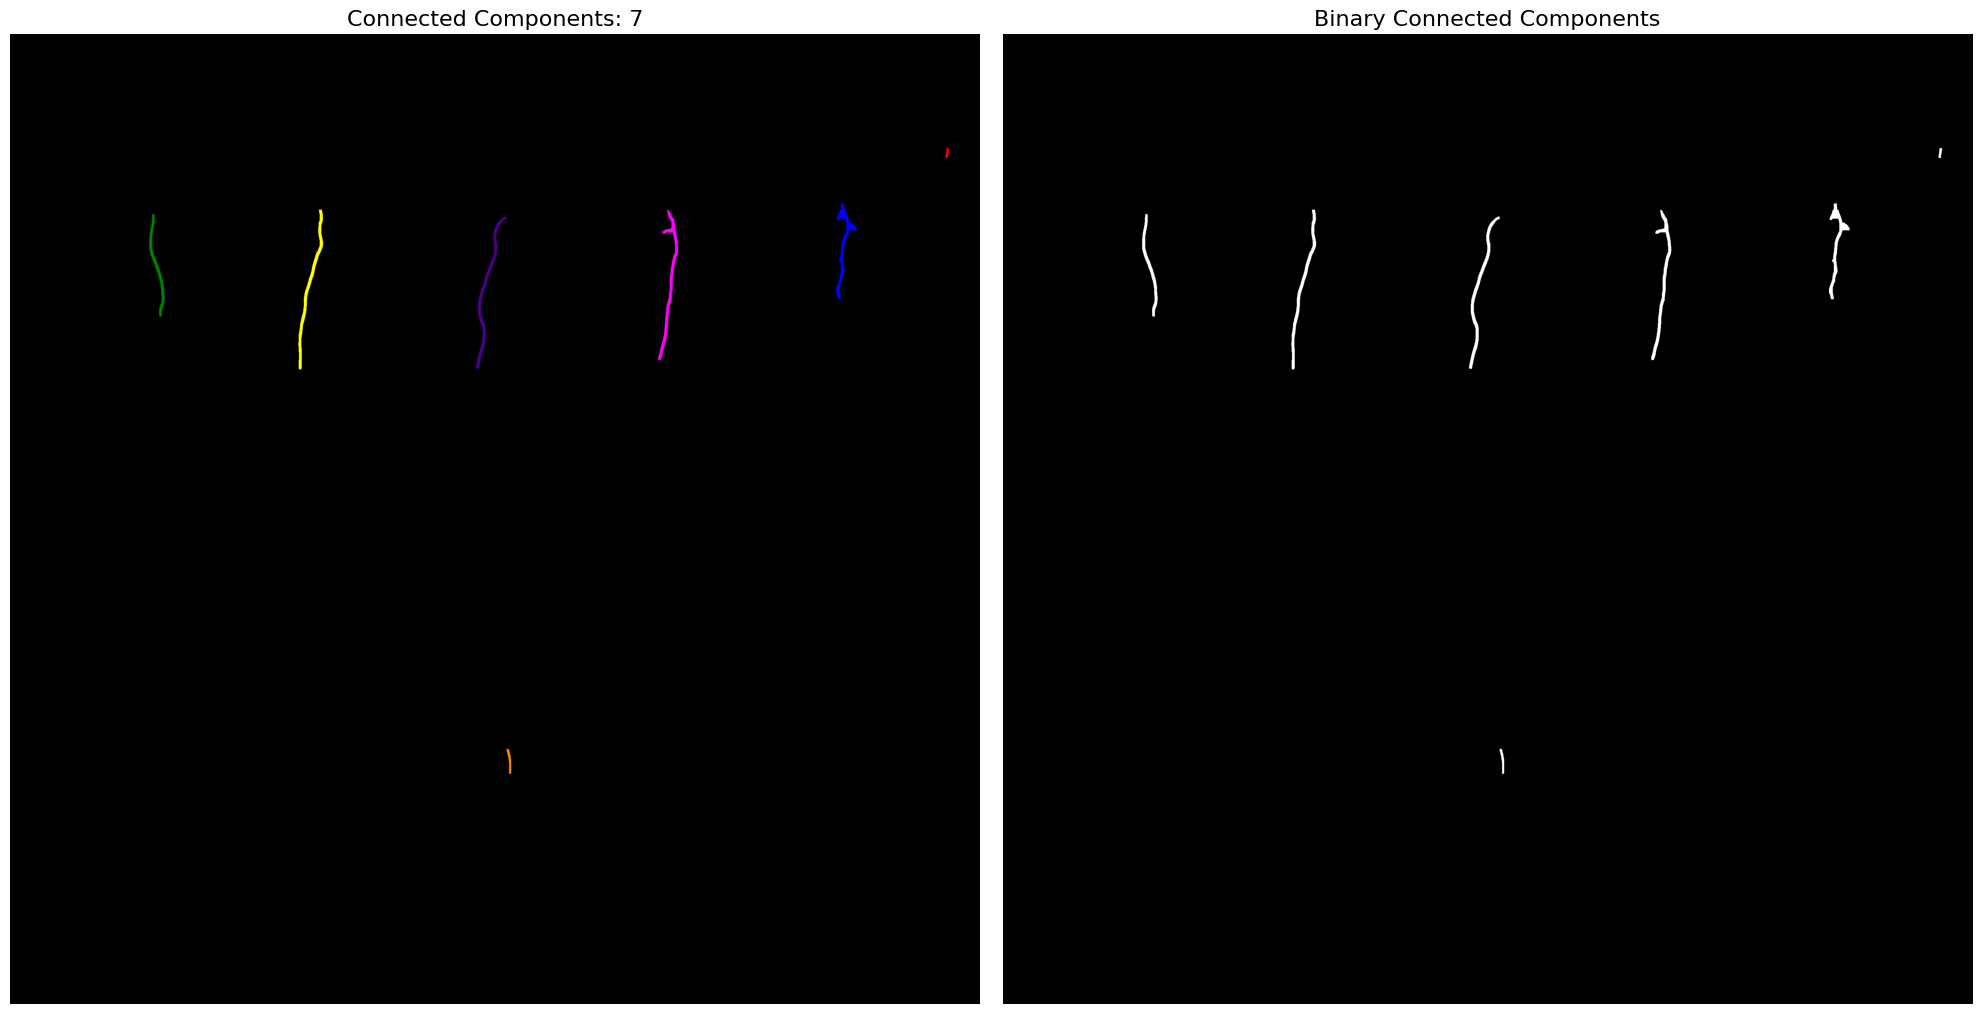

Filename: test_image_7.png | Number of connected components: 7


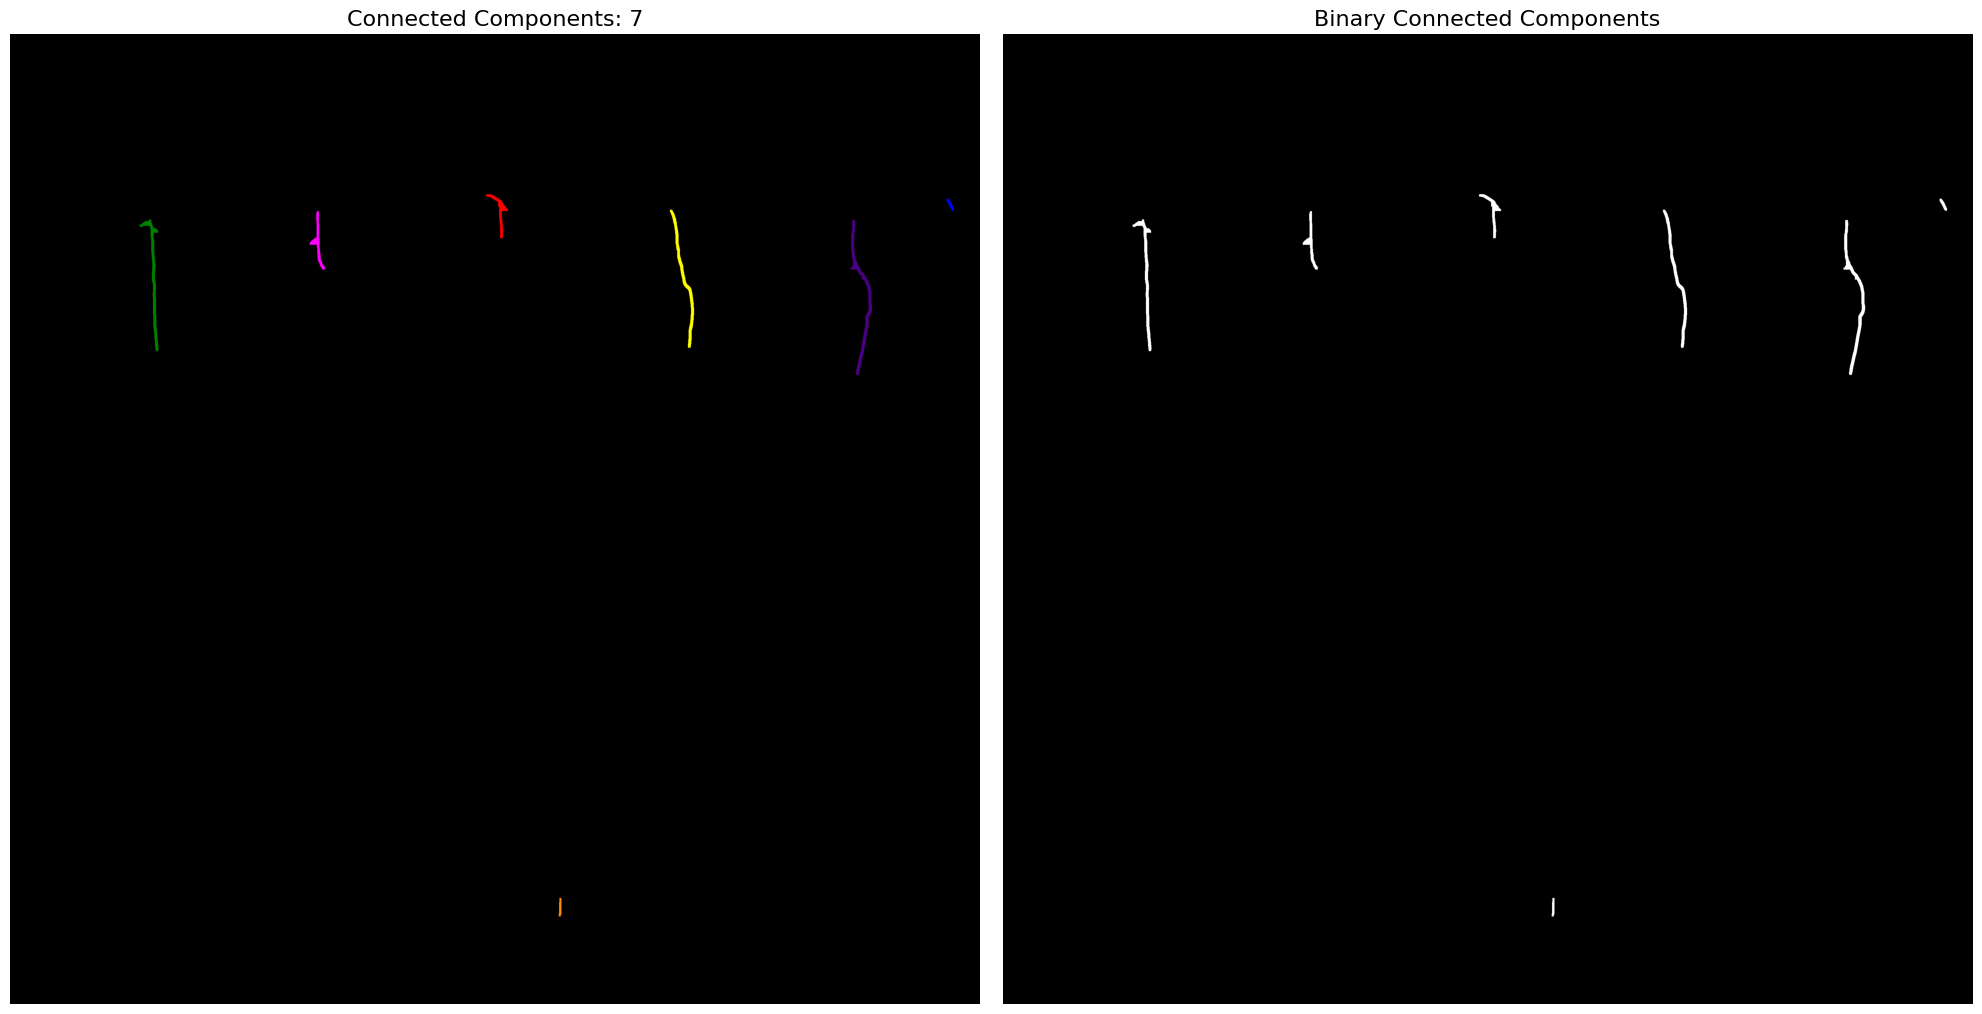

Filename: test_image_8.png | Number of connected components: 7


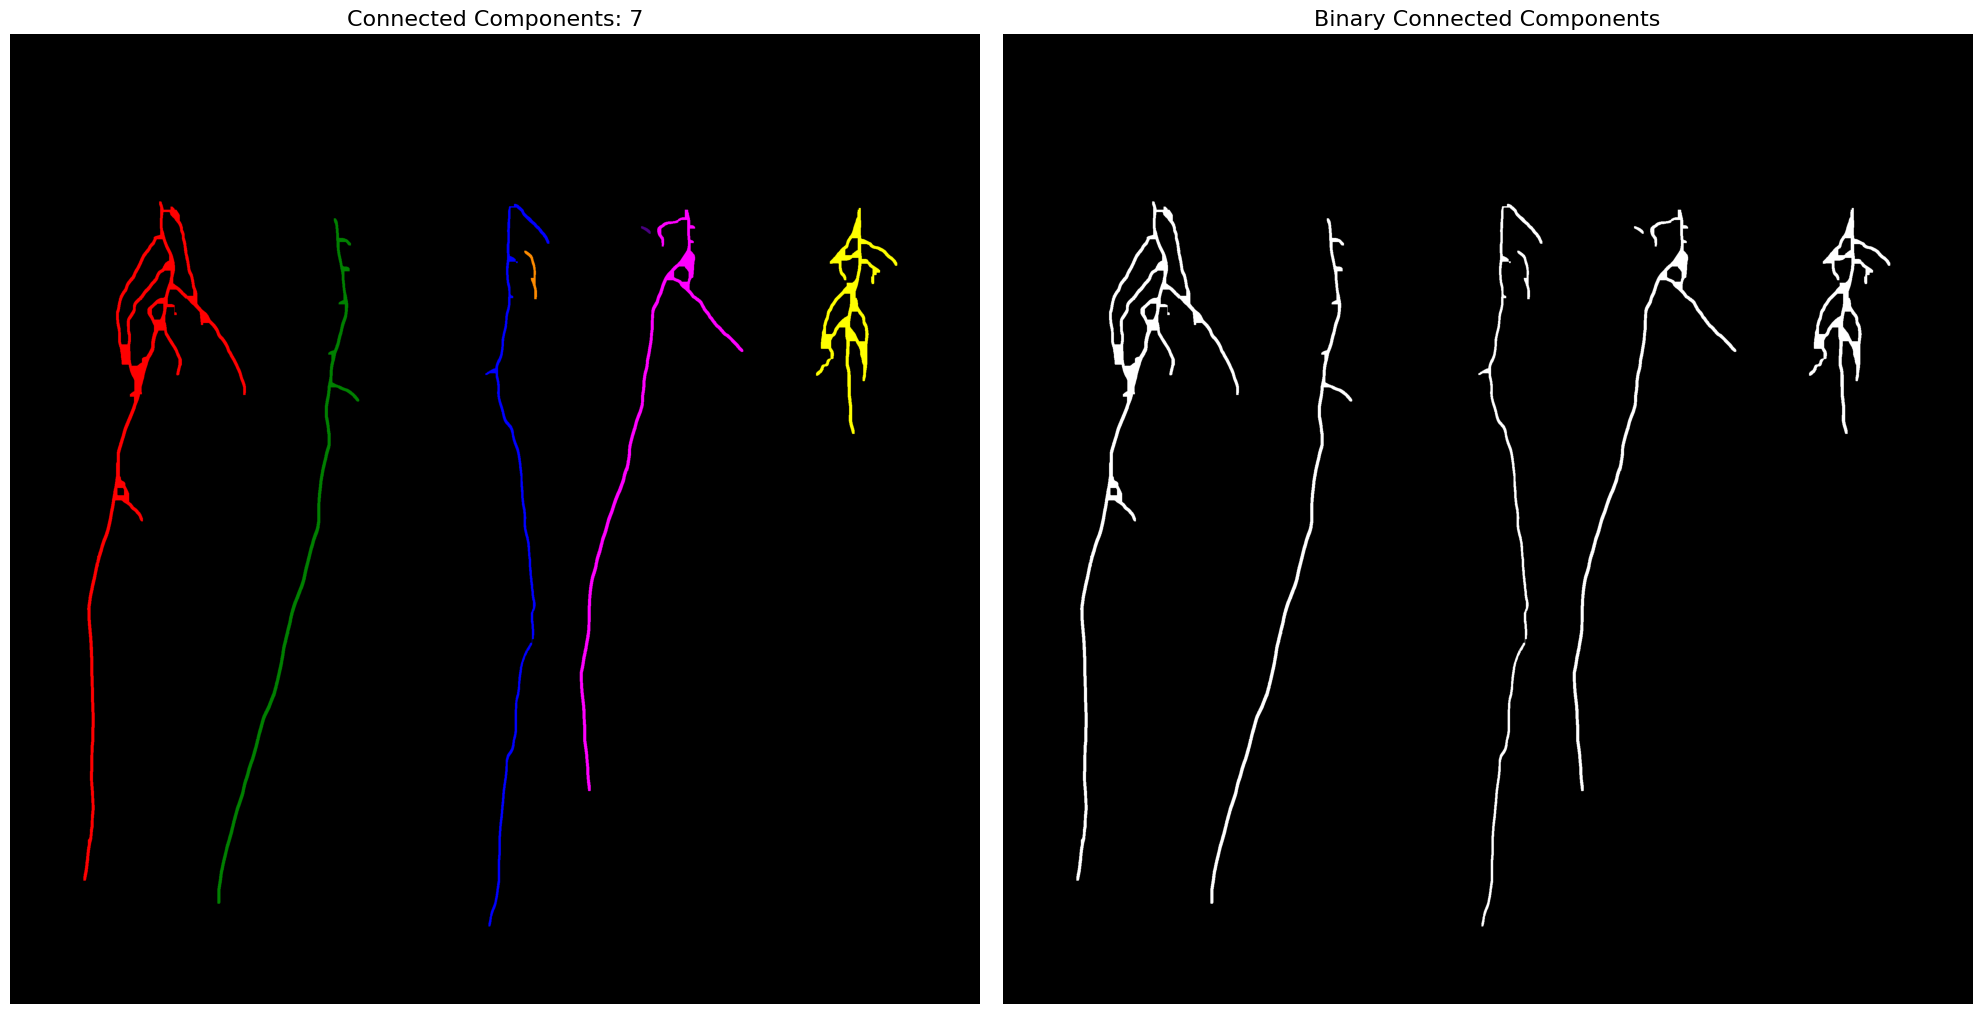

Filename: test_image_9.png | Number of connected components: 10


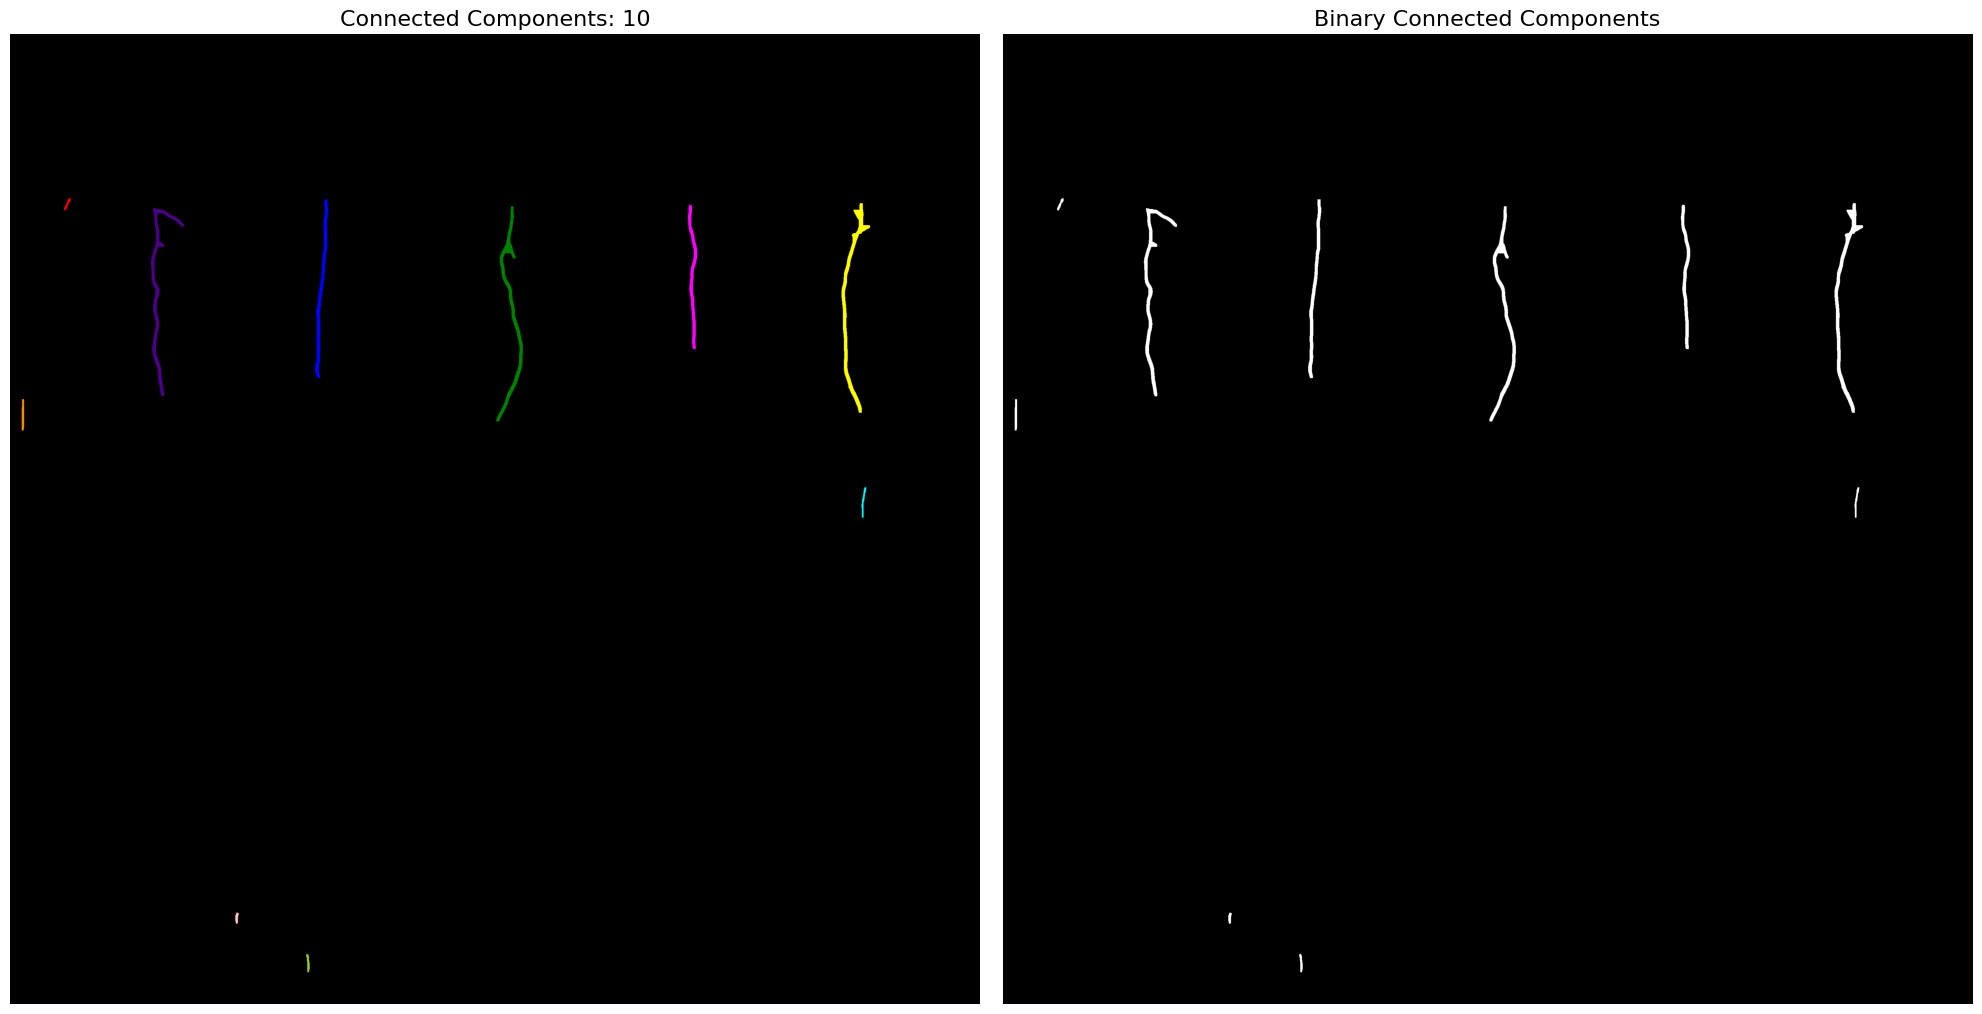

In [51]:
from skimage.measure import label
from skimage.color import label2rgb
import matplotlib.pyplot as plt

# Process connected components for each cleaned mask
for filename, cleaned_mask in processed_masks:
    # Step 1: Label connected components
    labeled_mask = label(cleaned_mask > 0)  # Ensure the mask is binary (True for foreground pixels)

    # Step 2: Count the number of connected components (excluding background)
    num_connected_components = labeled_mask.max()
    print(f"Filename: {filename} | Number of connected components: {num_connected_components}")

    # Step 3: Convert labeled mask to a color image for visualization
    colored_labels = label2rgb(labeled_mask, bg_label=0, bg_color=(0, 0, 0), colors=None)

    # Plot the labeled connected components
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.title(f"Connected Components: {num_connected_components}", fontsize=16)
    plt.imshow(colored_labels)
    plt.axis('off')

    # Step 4: Convert labeled mask back to binary
    binary_labels = (labeled_mask > 0).astype(np.uint8) * 255  # Set all non-zero labels to 255

    # Plot the binary connected components
    plt.subplot(1, 2, 2)
    plt.title("Binary Connected Components", fontsize=16)
    plt.imshow(binary_labels, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


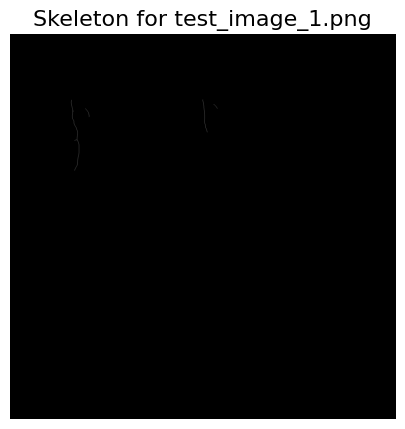

Branch data for test_image_1.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0          580       254.325902            0   
1            1            3          216        86.213203            1   
2            2           71          167        43.941125            0   
3            3          161          355        74.012193            0   
4            1          216          228         6.828427            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                479               1407   
1               1.0                0.0                482                449   
2               1.0                0.0                515               1485   
3               1.0                0.0                544                549   
4               1.0                0.0                562                458   

   image-coord-dst-0  image-coord-dst-1 

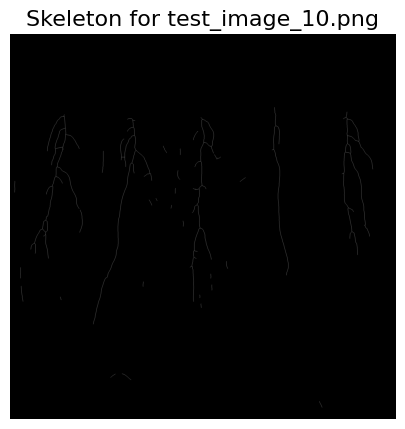

Branch data for test_image_10.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0          738       142.870058            1   
1            1           34          170        44.313708            1   
2            2           73          115        15.485281            1   
3            2          115         3352       314.421356            1   
4            2          115          917        93.899495            2   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                536               1930   
1               1.0                0.0                569               2459   
2               1.0                0.0                589                397   
3               1.0                0.0                602                391   
4               1.0                0.0                602                391   

   image-coord-dst-0  image-coord-dst-1

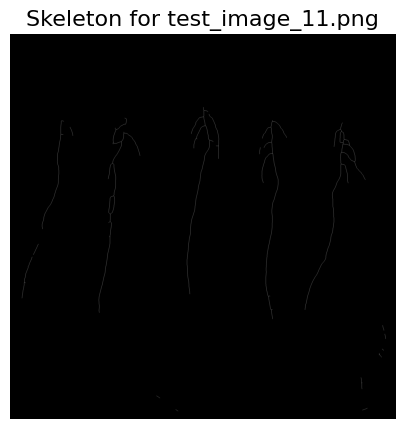

Branch data for test_image_11.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           23        26.313708            1   
1            0           23           65        34.556349            1   
2            0           23          122        49.071068            2   
3            1           81         2725       265.409163            1   
4            0          122         1394       176.338095            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                535               1411   
1               1.0                0.0                558               1415   
2               1.0                0.0                558               1415   
3               1.0                0.0                585               1451   
4               1.0                0.0                605               1412   

   image-coord-dst-0  image-coord-dst-1

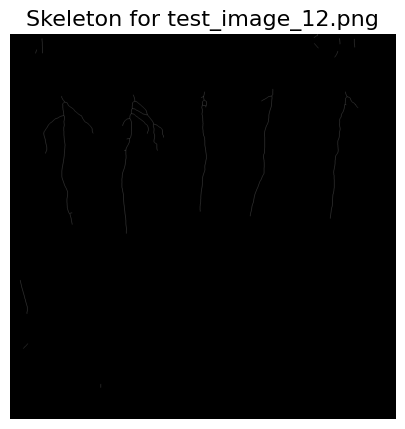

Branch data for test_image_12.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           36        43.455844            0   
1            1           37          166        44.071068            0   
2            2           38          327       109.485281            0   
3            3           46          236        63.485281            0   
4            4          144          248        47.426407            0   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                  1               2245   
1               1.0                0.0                 32               2403   
2               1.0                0.0                 33                234   
3               1.0                0.0                 36               2512   
4               1.0                0.0                 69               2219   

   image-coord-dst-0  image-coord-dst-1

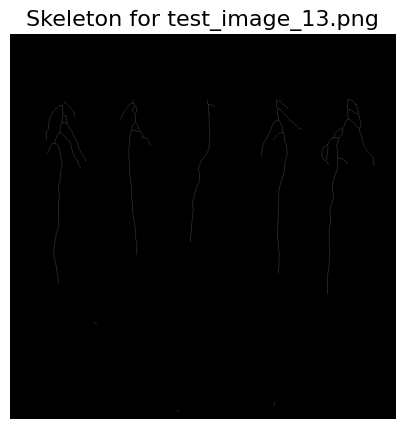

Branch data for test_image_13.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           14         9.656854            1   
1            1            4           78        15.656854            1   
2            0           14          819        79.970563            2   
3            0           14         1244       153.053824            2   
4            2           19          340        41.142136            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                471               2464   
1               1.0                0.0                475               1947   
2               1.0                0.0                479               2468   
3               1.0                0.0                479               2468   
4               1.0                0.0                480               1444   

   image-coord-dst-0  image-coord-dst-1

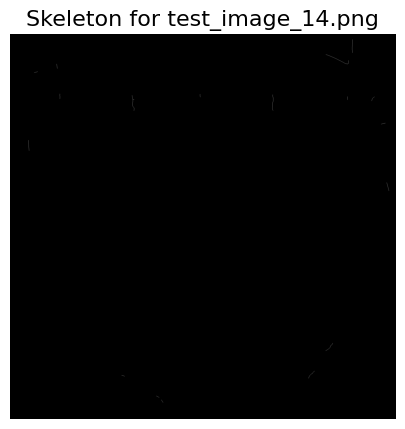

Branch data for test_image_14.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           97        99.899495            0   
1            1           98          285       185.994949            1   
2            1          200          285        32.313708            1   
3            2          283          319        35.485281            0   
4            1          285          287         1.414214            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                 40               2499   
1               1.0                0.0                149               2304   
2               1.0                0.0                193               2470   
3               1.0                0.0                219                340   
4               1.0                0.0                219               2461   

   image-coord-dst-0  image-coord-dst-1

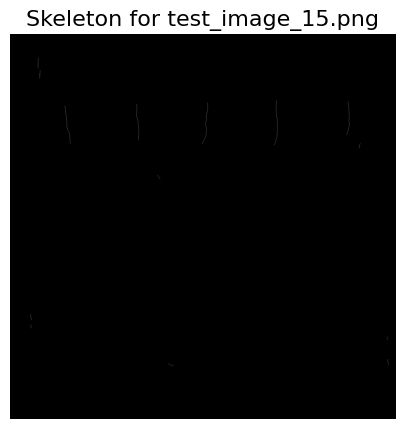

Branch data for test_image_15.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           78        80.071068            0   
1            1           79          114        34.656854            1   
2            1          114          119         7.828427            1   
3            1          114          146        28.242641            1   
4            2          147         1583       343.740115            0   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                174                206   
1               1.0                0.0                265                220   
2               1.0                0.0                298                216   
3               1.0                0.0                298                216   
4               1.0                0.0                486               1945   

   image-coord-dst-0  image-coord-dst-1

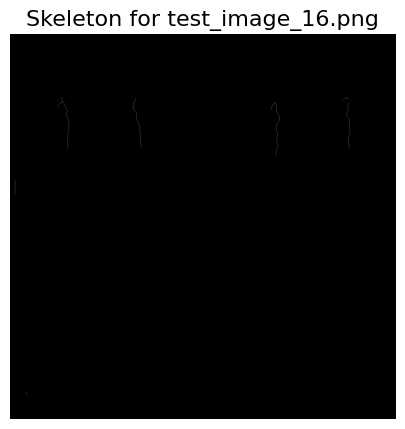

Branch data for test_image_16.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0          112        36.727922            1   
1            1            4          359        79.284271            1   
2            2           65           83        52.213203            0   
3            3          110          176        17.556349            1   
4            0          112          338        57.012193            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                463                378   
1               1.0                0.0                466                919   
2               1.0                0.0                476               2467   
3               1.0                0.0                495               1942   
4               1.0                0.0                496                383   

   image-coord-dst-0  image-coord-dst-1

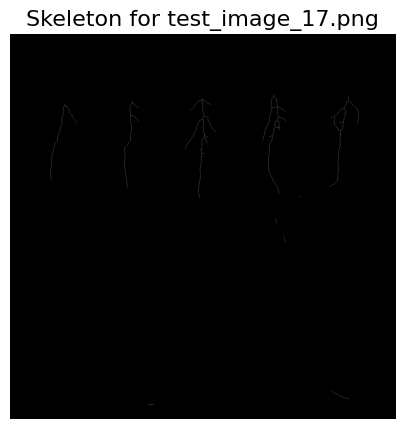

Branch data for test_image_17.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           21        18.242641            1   
1            1           14          165        33.656854            1   
2            0           21          598        84.284271            2   
3            0           21          757        94.526912            2   
4            2           66          116        13.071068            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                442               1926   
1               1.0                0.0                455               2471   
2               1.0                0.0                459               1925   
3               1.0                0.0                459               1925   
4               1.0                0.0                471               1406   

   image-coord-dst-0  image-coord-dst-1

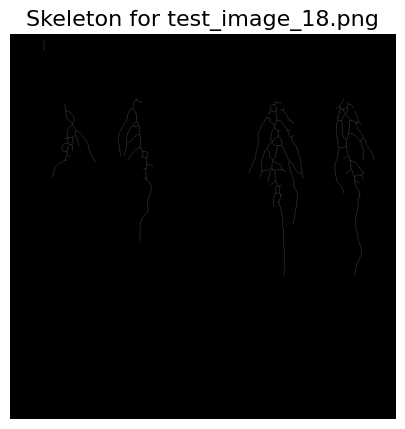

Branch data for test_image_18.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           71        73.071068            0   
1            1           72           92        15.071068            1   
2            2           84          449        67.355339            1   
3            1           92          610        83.284271            2   
4            1           92          230        53.698485            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                 50                249   
1               1.0                0.0                468                925   
2               1.0                0.0                478               2434   
3               1.0                0.0                481                924   
4               1.0                0.0                481                924   

   image-coord-dst-0  image-coord-dst-1

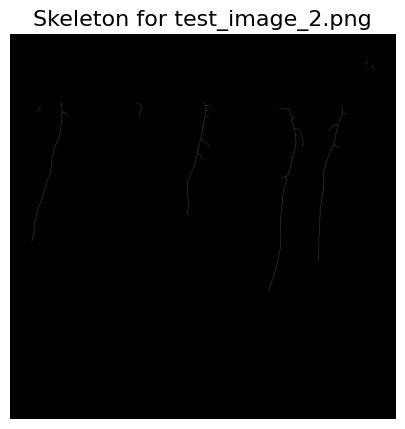

Branch data for test_image_2.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           32        32.071068            0   
1            1           29           60        31.485281            0   
2            2           61          110        14.828427            1   
3            3           63          149        30.213203            1   
4            4           79          818       133.497475            0   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                198               2604   
1               1.0                0.0                226               2650   
2               1.0                0.0                499                375   
3               1.0                0.0                500               1411   
4               1.0                0.0                507                923   

   image-coord-dst-0  image-coord-dst-1 

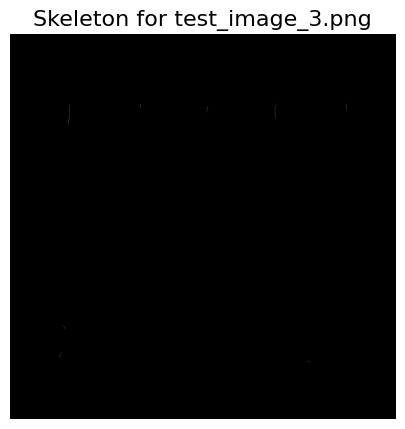

Branch data for test_image_3.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0          323       113.870058            0   
1            1            2          183        44.242641            0   
2            2            3          112        25.828427            0   
3            3           15          365       148.627417            0   
4            4           53          230        49.142136            0   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                512               1948   
1               1.0                0.0                513               2455   
2               1.0                0.0                514                952   
3               1.0                0.0                518                438   
4               1.0                0.0                527               1445   

   image-coord-dst-0  image-coord-dst-1 

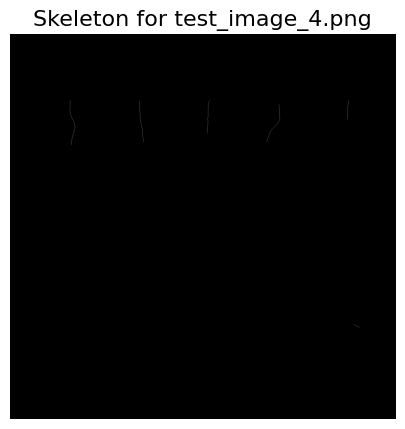

Branch data for test_image_4.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0         1297       360.409163            0   
1            1            6         1075       248.526912            0   
2            2            7          670       143.384776            0   
3            3            9         1280       324.568542            0   
4            4          119         1268       320.078210            0   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                481                437   
1               1.0                0.0                486               1455   
2               1.0                0.0                486               2469   
3               1.0                0.0                487                942   
4               1.0                0.0                514               1961   

   image-coord-dst-0  image-coord-dst-1 

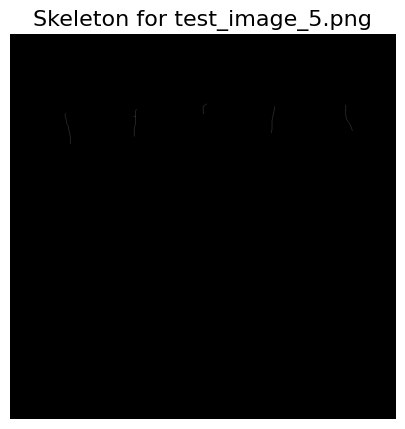

Branch data for test_image_5.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            1          251        92.455844            0   
1            1           15          759       212.781746            0   
2            2           43          807       205.183766            0   
3            3           99          333        56.313708            1   
4            4          219          913       245.468037            0   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                511               1436   
1               1.0                0.0                518               2448   
2               1.0                0.0                530               1932   
3               1.0                0.0                549                923   
4               1.0                0.0                579                405   

   image-coord-dst-0  image-coord-dst-1 

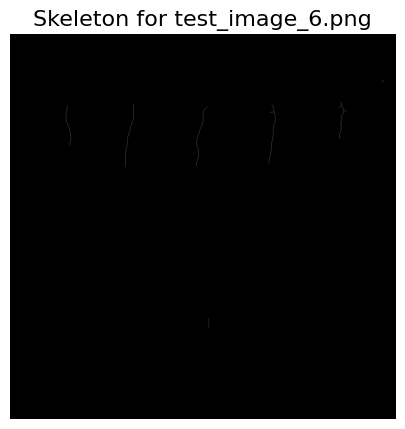

Branch data for test_image_6.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           21        22.656854            0   
1            1           22           53        21.414214            1   
2            2           39         1996       489.066017            0   
3            3           40          342        63.627417            1   
4            1           53           55         2.000000            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                335               2722   
1               1.0                0.0                495               2417   
2               1.0                0.0                512                900   
3               1.0                0.0                512               1911   
4               1.0                0.0                516               2416   

   image-coord-dst-0  image-coord-dst-1 

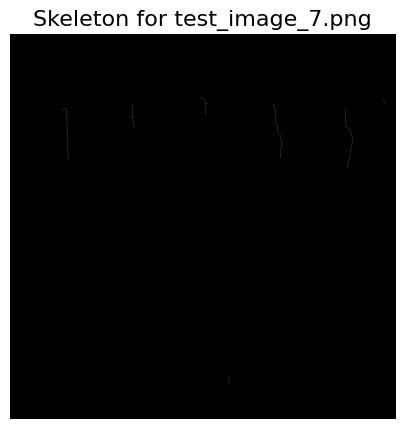

Branch data for test_image_7.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            7           82        67.355339            1   
1            1           32          102        35.627417            0   
2            0           82          109        18.485281            1   
3            0           82          475        88.142136            1   
4            2          111         1554       425.066017            0   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                469               1383   
1               1.0                0.0                480               2721   
2               1.0                0.0                505               1427   
3               1.0                0.0                505               1427   
4               1.0                0.0                512               1919   

   image-coord-dst-0  image-coord-dst-1 

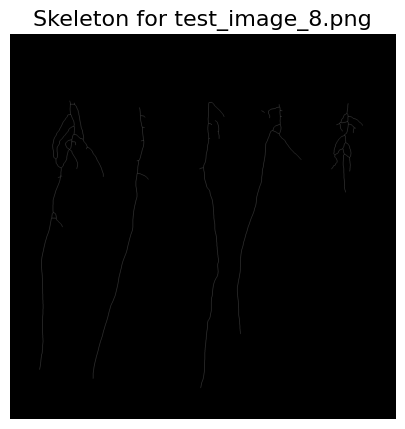

Branch data for test_image_8.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           87        27.071068            1   
1            0           41          123        12.242641            1   
2            2           61          717        77.727922            1   
3            0           87          123        31.414214            2   
4            0           87          792        78.071068            2   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                488                435   
1               1.0                0.0                503                468   
2               1.0                0.0                507               2467   
3               1.0                0.0                513                440   
4               1.0                0.0                513                440   

   image-coord-dst-0  image-coord-dst-1 

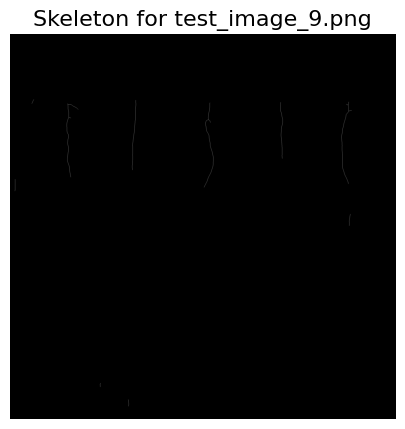

Branch data for test_image_9.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           87        37.627417            0   
1            1            6         2592       526.740115            0   
2            2           33          185        24.656854            1   
3            3           42         2257       429.225397            0   
4            4           54          805       129.798990            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                478                174   
1               1.0                0.0                483                918   
2               1.0                0.0                496               2471   
3               1.0                0.0                499               1975   
4               1.0                0.0                502               1459   

   image-coord-dst-0  image-coord-dst-1 

In [52]:
from skimage.morphology import skeletonize
from skan import Skeleton, summarize
import matplotlib.pyplot as plt

# Process skeletonization for each binary connected component
skeleton_results = []
for filename, binary_labels in processed_masks:
    # Step 1: Skeletonize the binary mask
    skeleton_object = skeletonize(binary_labels > 0)  # Ensure mask is binary (True for foreground)

    # Step 2: Convert the skeletonized object into a skan Skeleton object
    skeleton_data = Skeleton(skeleton_object)

    # Step 3: Summarize the skeleton's branch data
    branch_data = summarize(skeleton_data)

    # Append results for further use
    skeleton_results.append((filename, skeleton_object, branch_data))

    # Plot the skeletonized mask
    plt.figure(figsize=(10, 5))
    plt.title(f"Skeleton for {filename}", fontsize=16)
    plt.imshow(skeleton_object, cmap='gray')
    plt.axis('off')
    plt.show()

    # Display branch data
    print(f"Branch data for {filename}:")
    print(branch_data.head())  # Display the first few rows of branch data

Processing test_image_1.png...


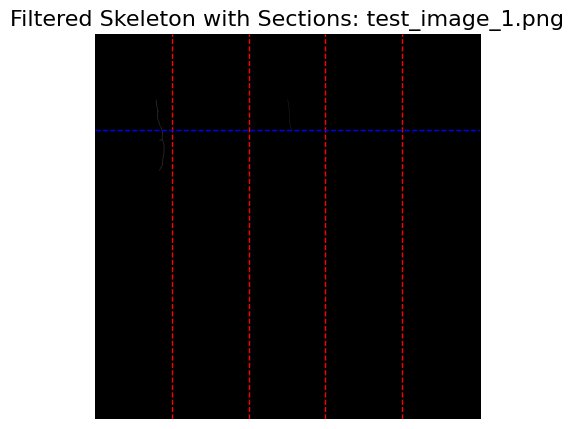

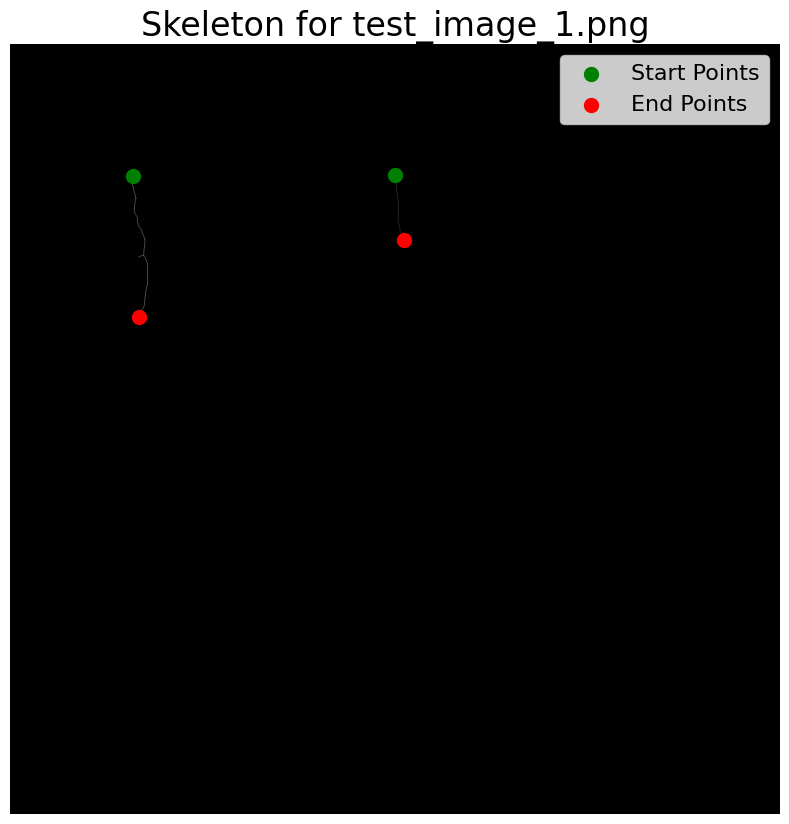

Processing test_image_10.png...


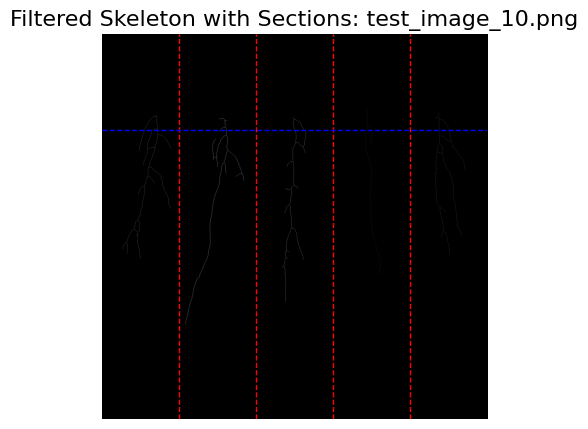

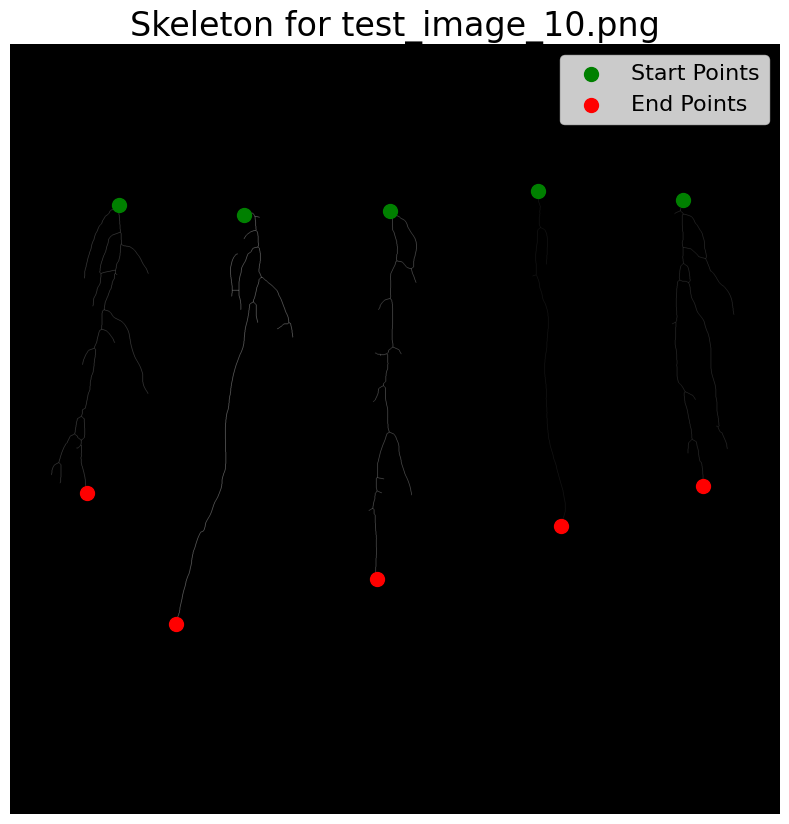

Processing test_image_11.png...


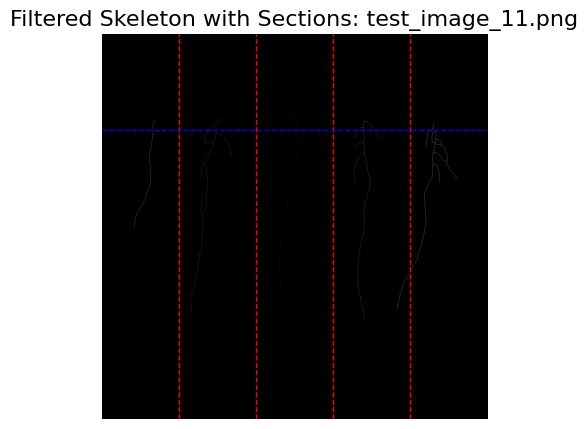

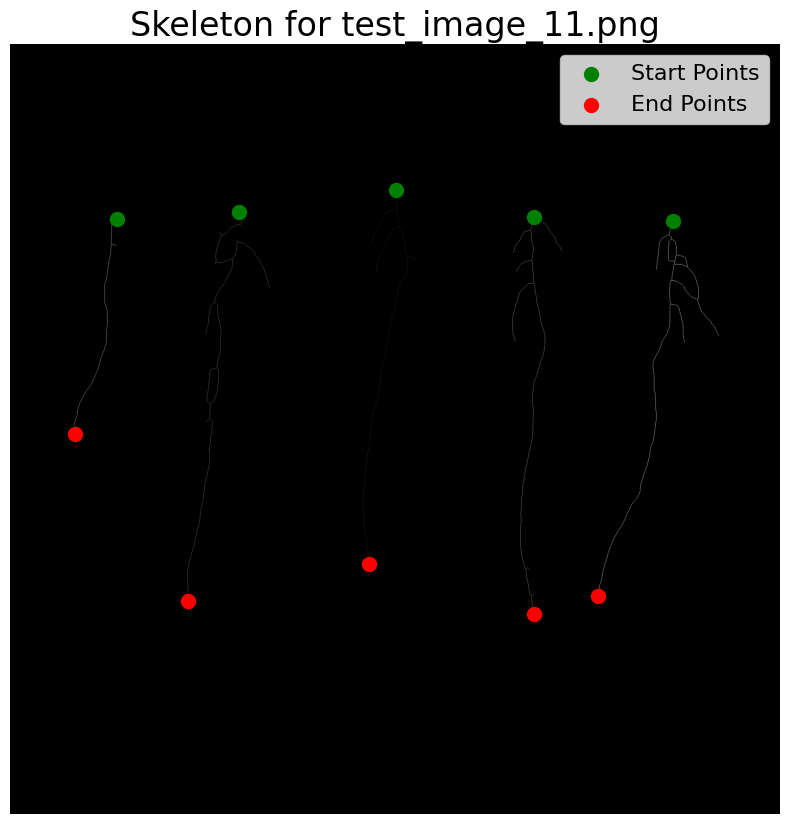

Processing test_image_12.png...


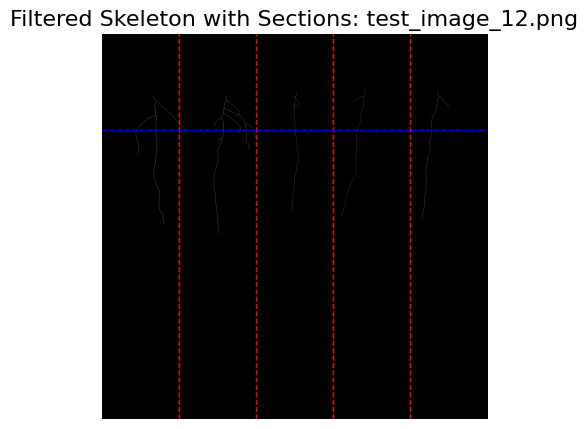

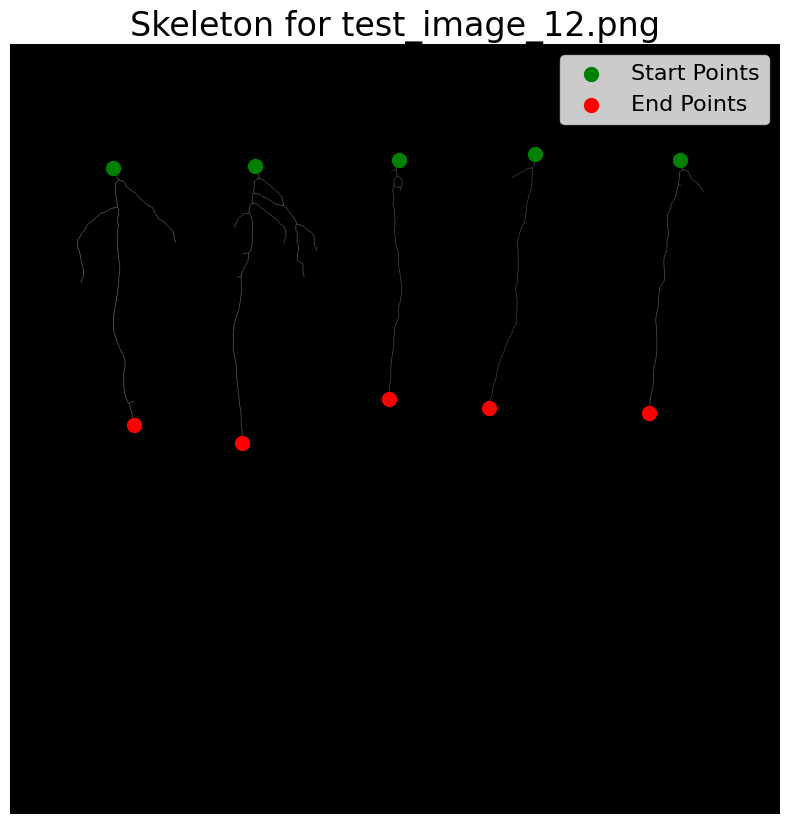

Processing test_image_13.png...


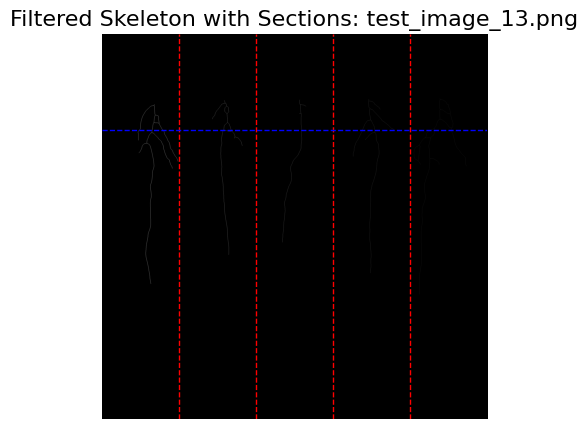

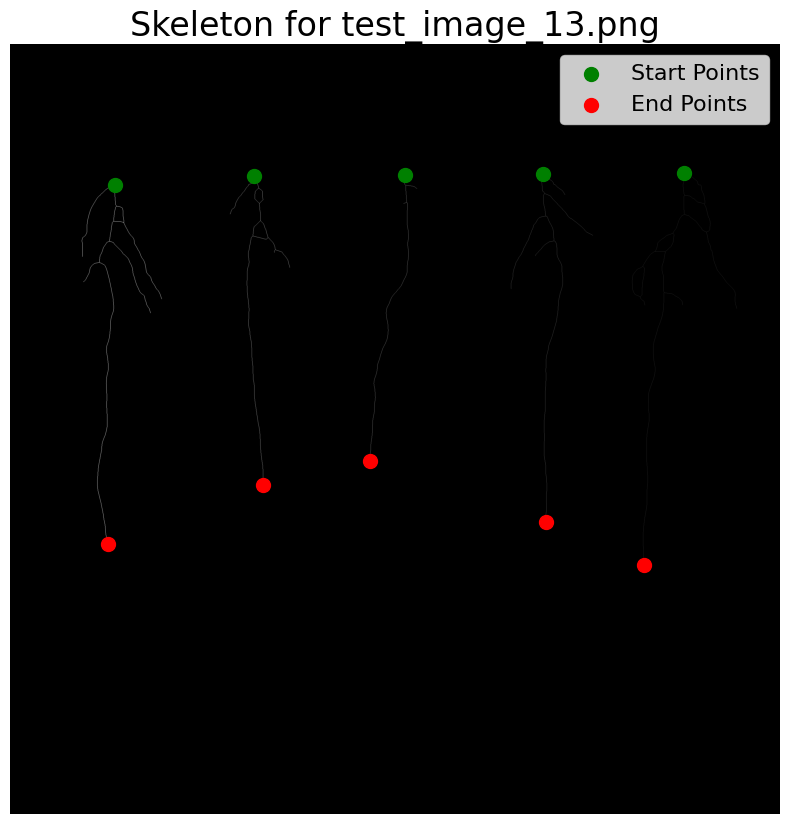

Processing test_image_14.png...


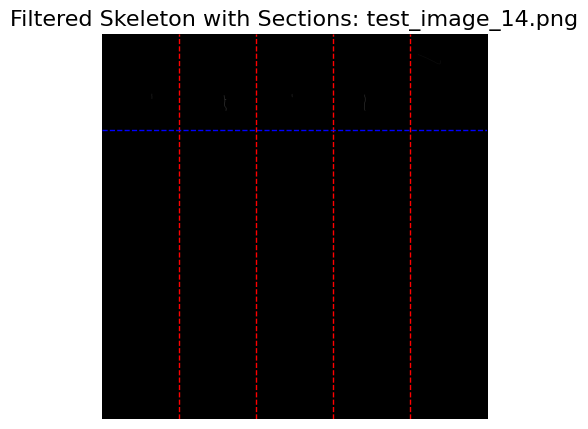

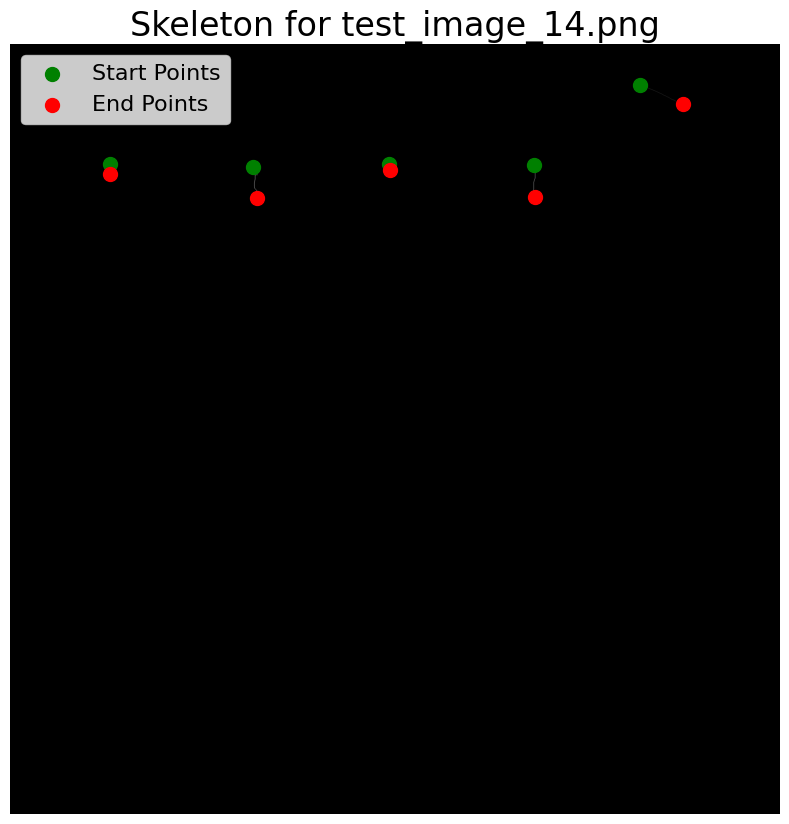

Processing test_image_15.png...


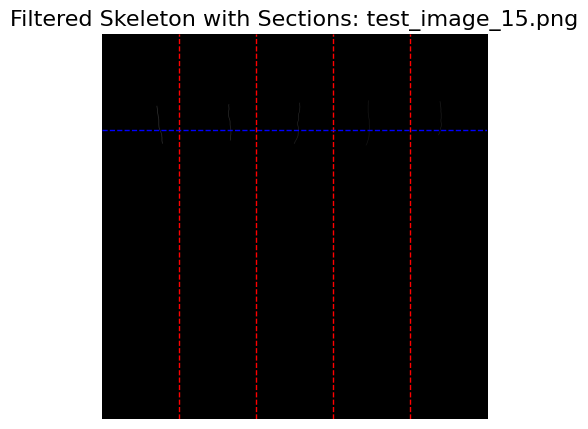

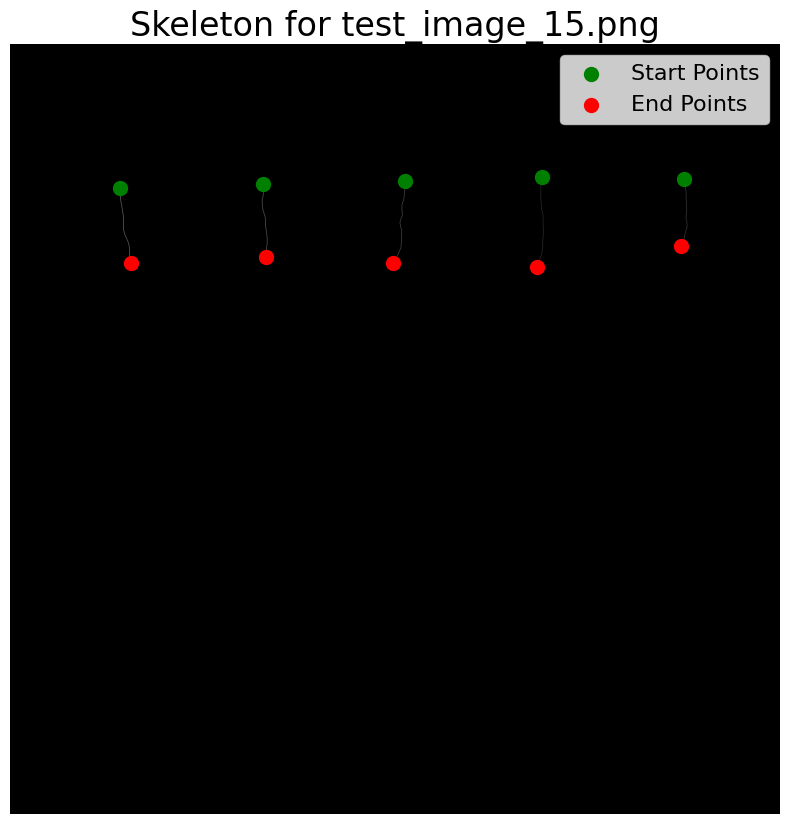

Processing test_image_16.png...


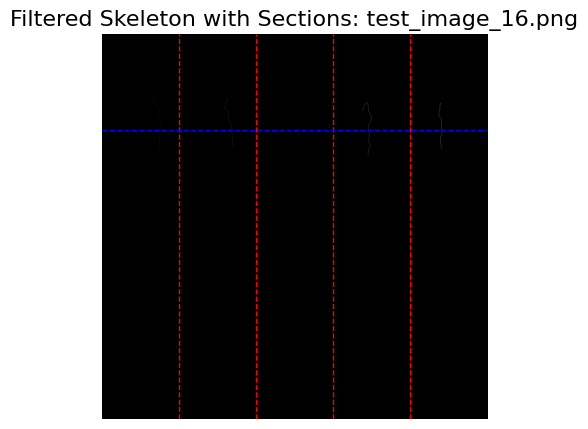

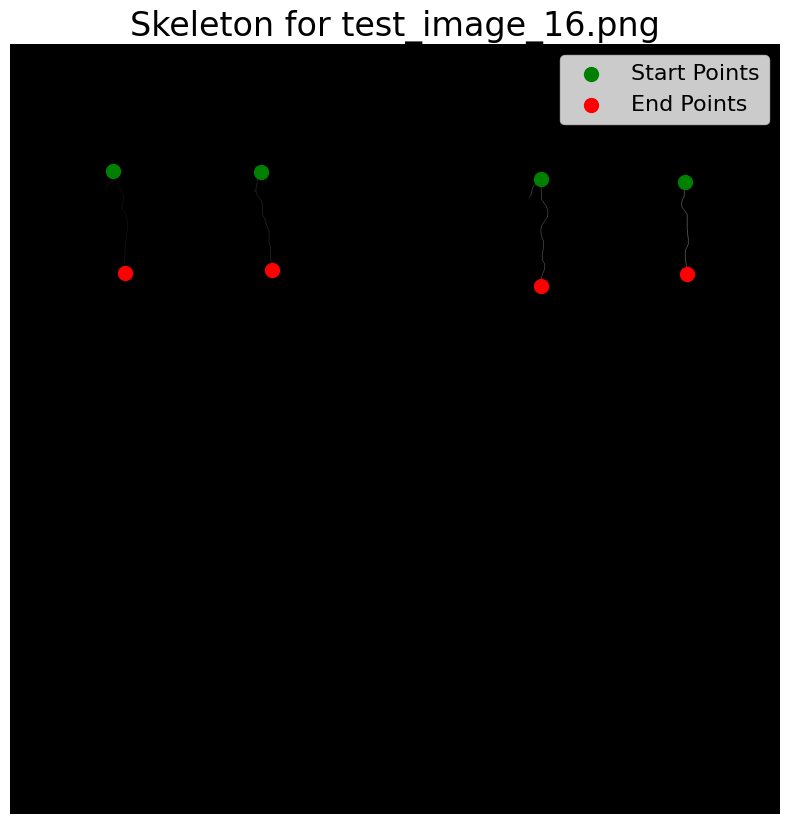

Processing test_image_17.png...


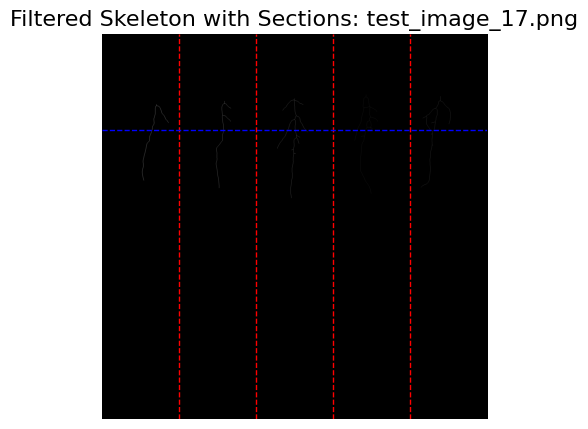

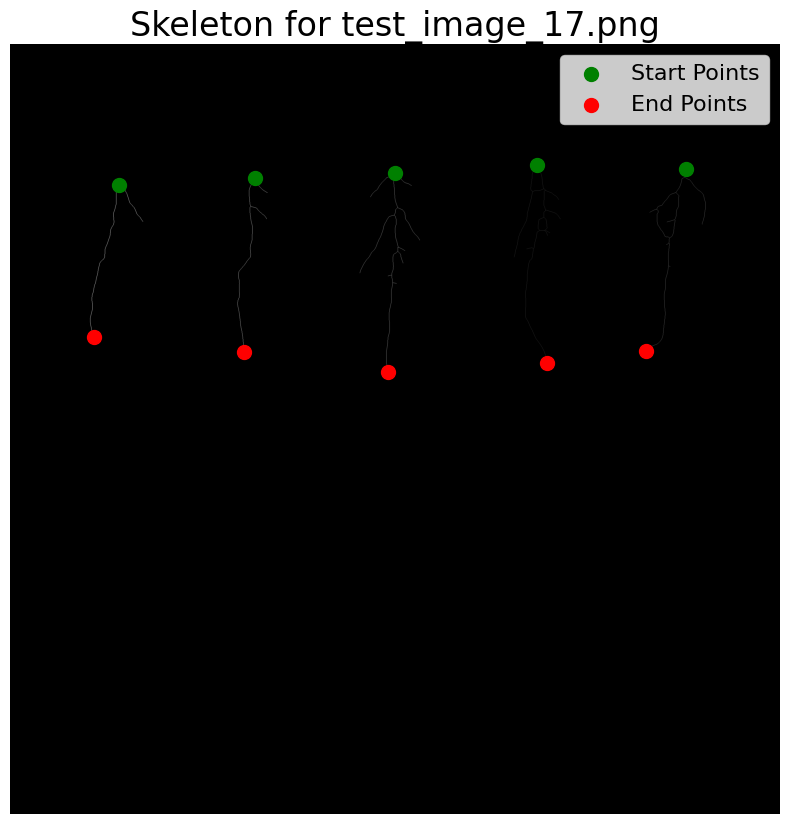

Processing test_image_18.png...


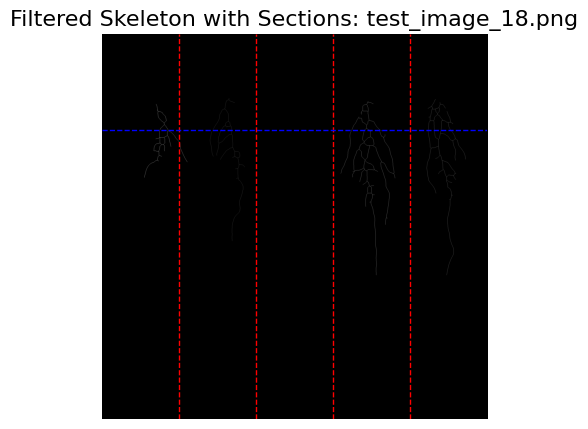

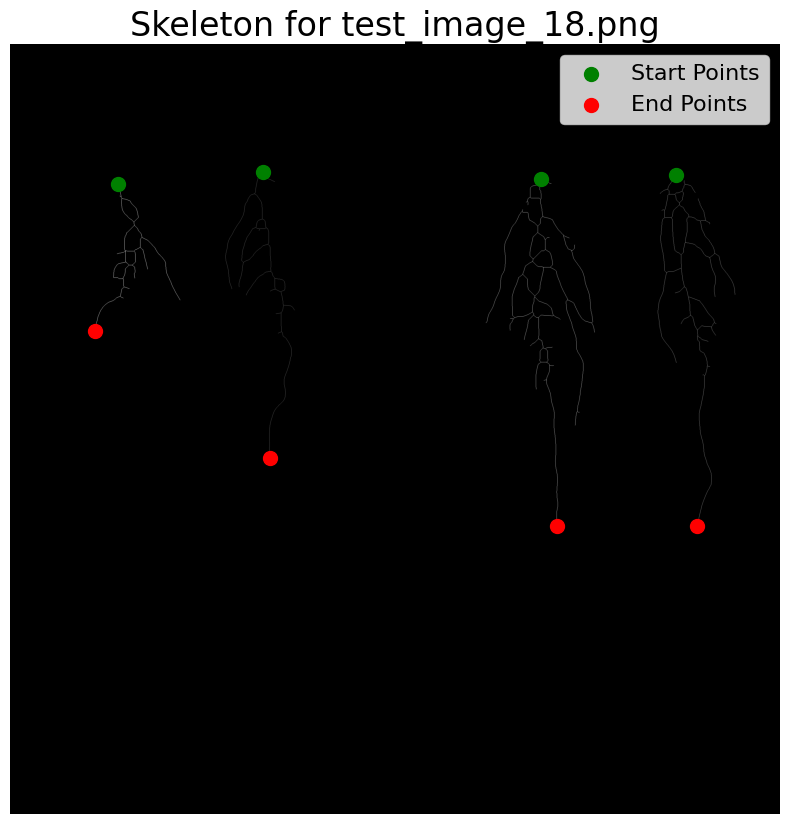

Processing test_image_2.png...


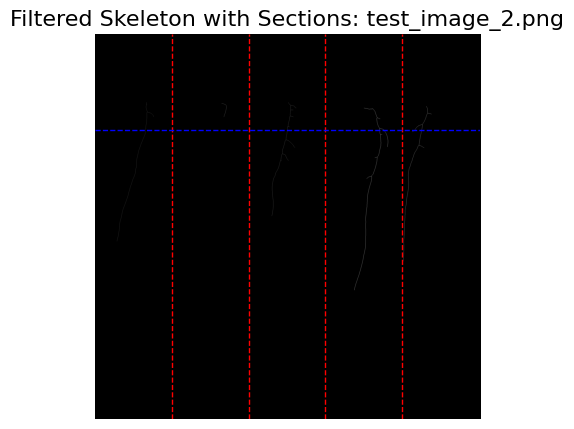

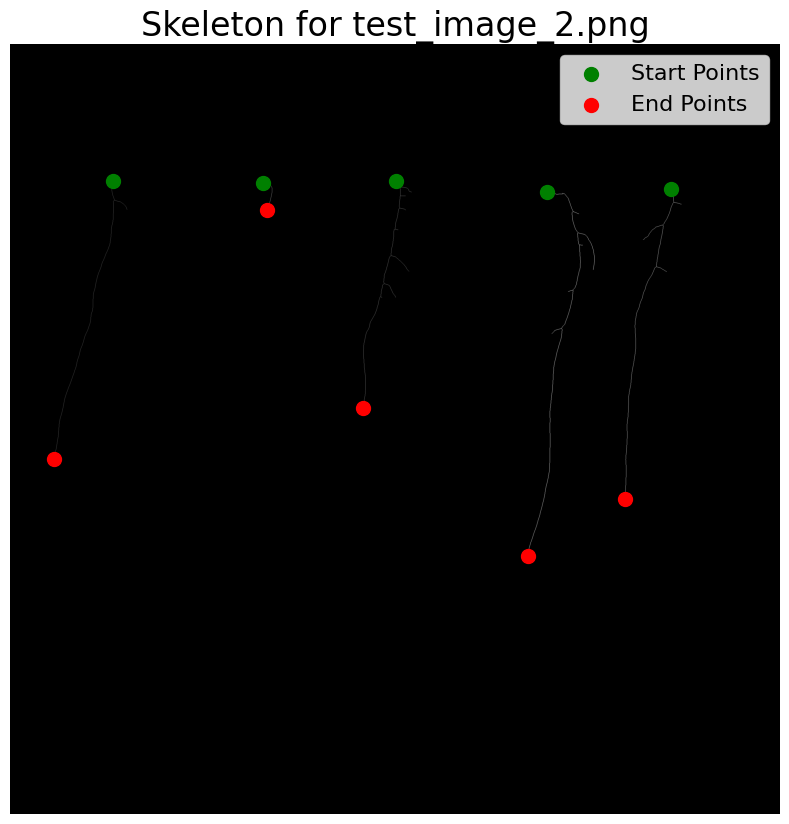

Processing test_image_3.png...


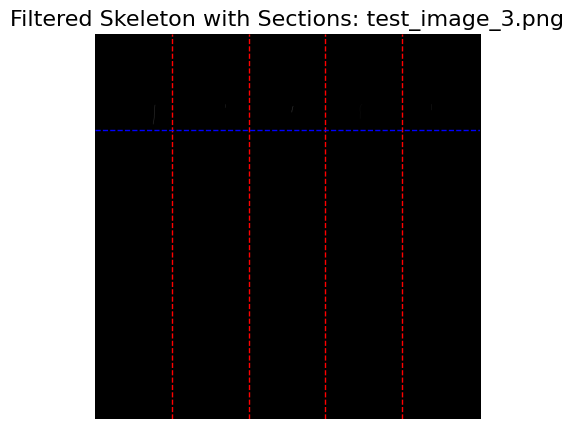

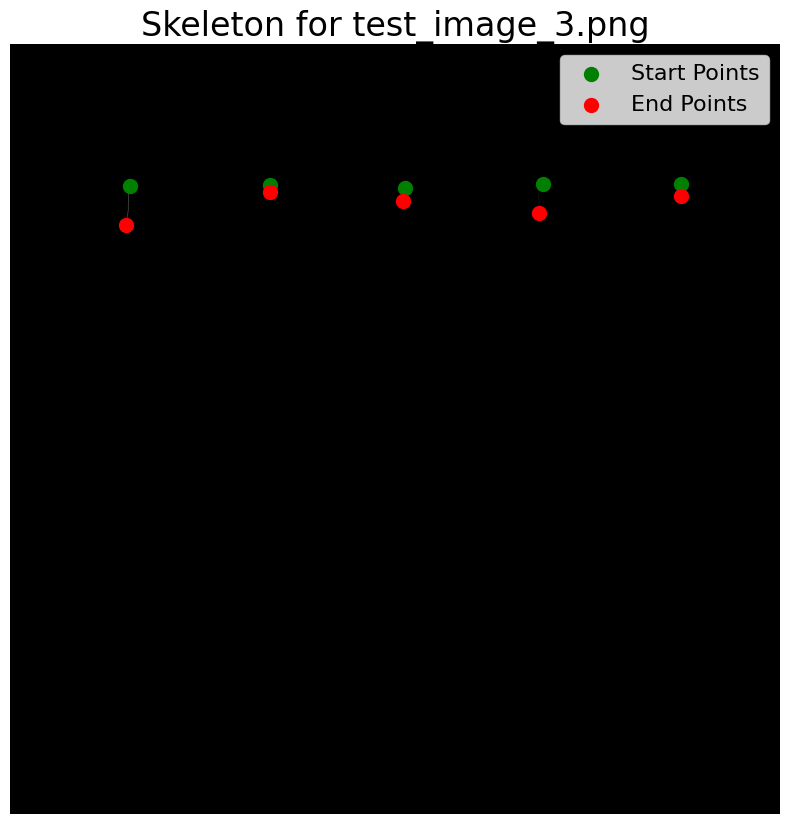

Processing test_image_4.png...


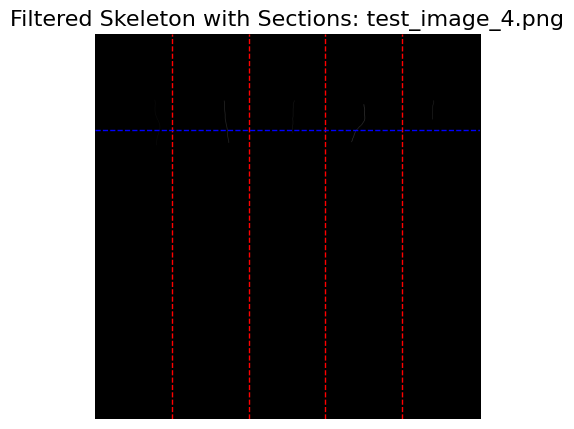

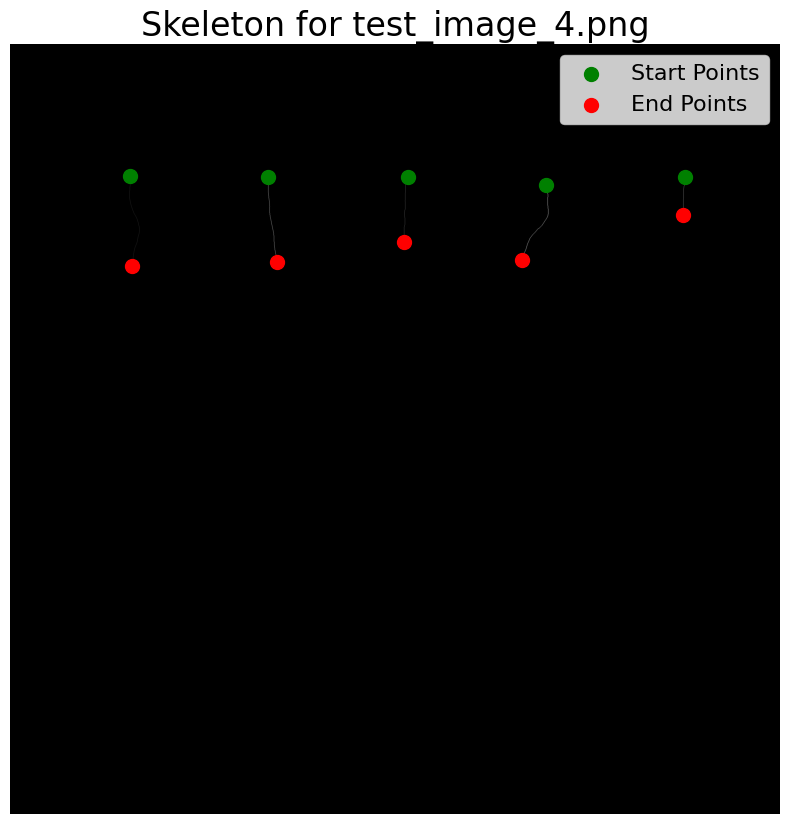

Processing test_image_5.png...


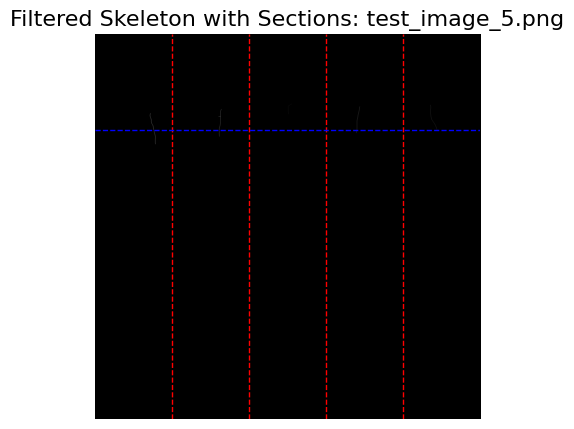

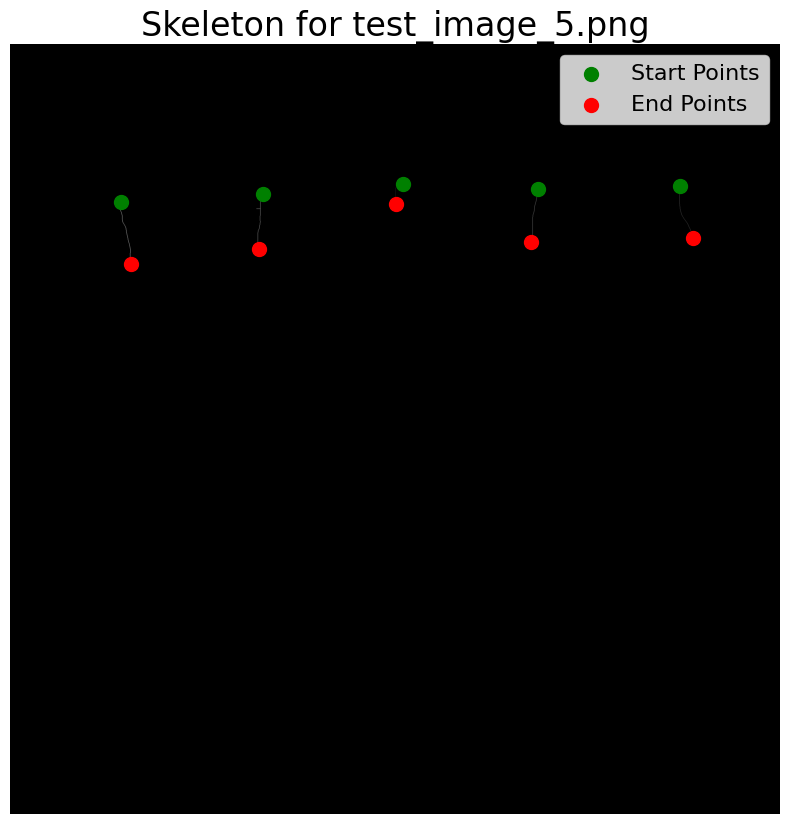

Processing test_image_6.png...


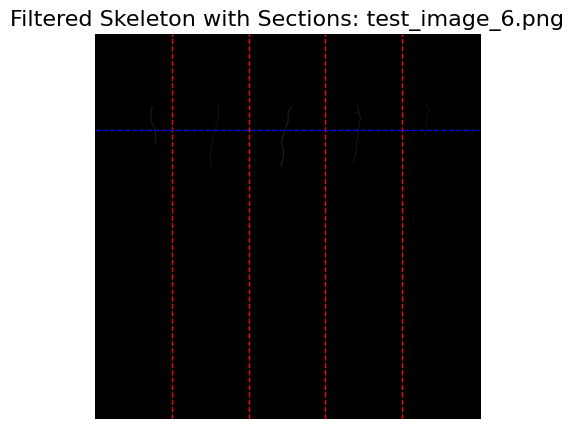

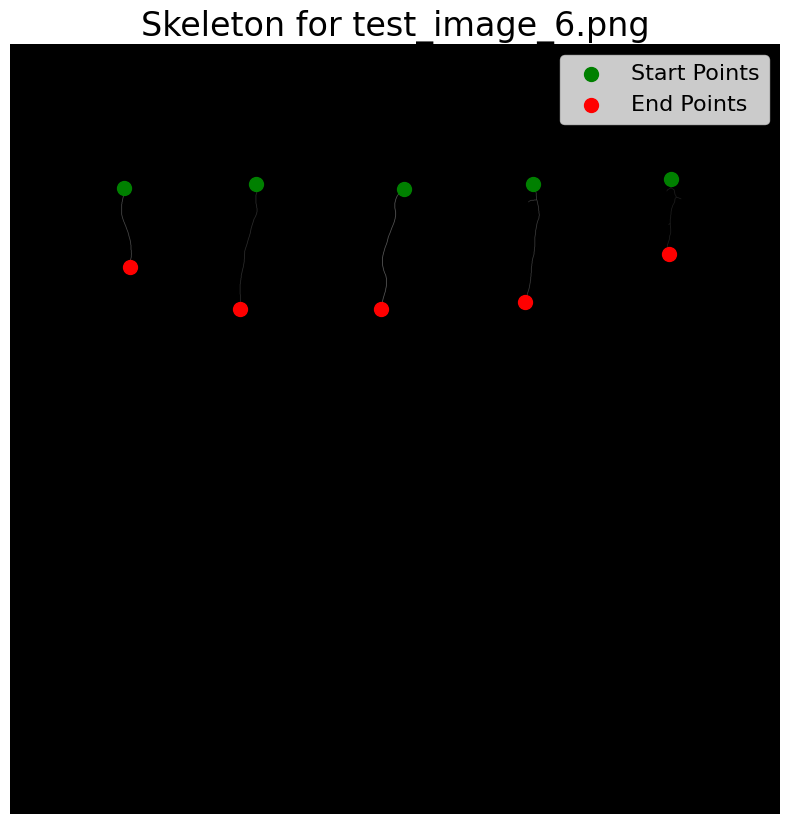

Processing test_image_7.png...


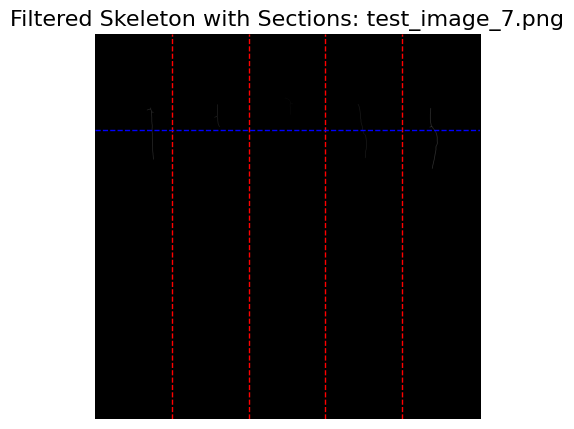

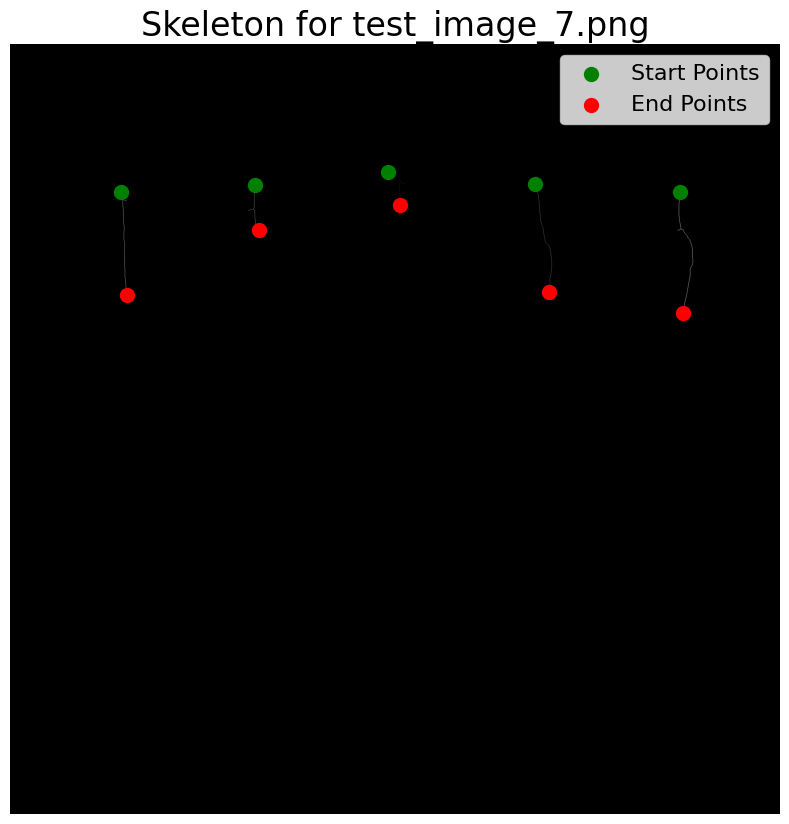

Processing test_image_8.png...


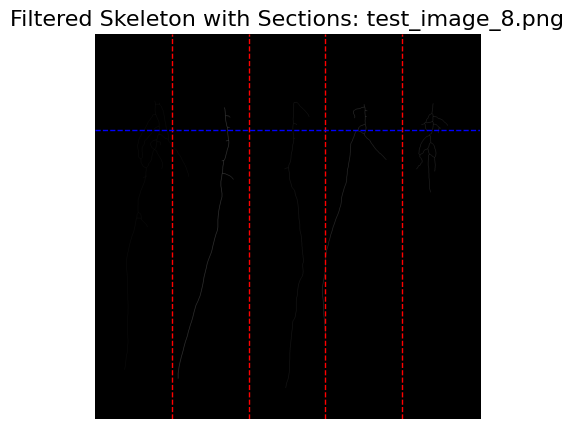

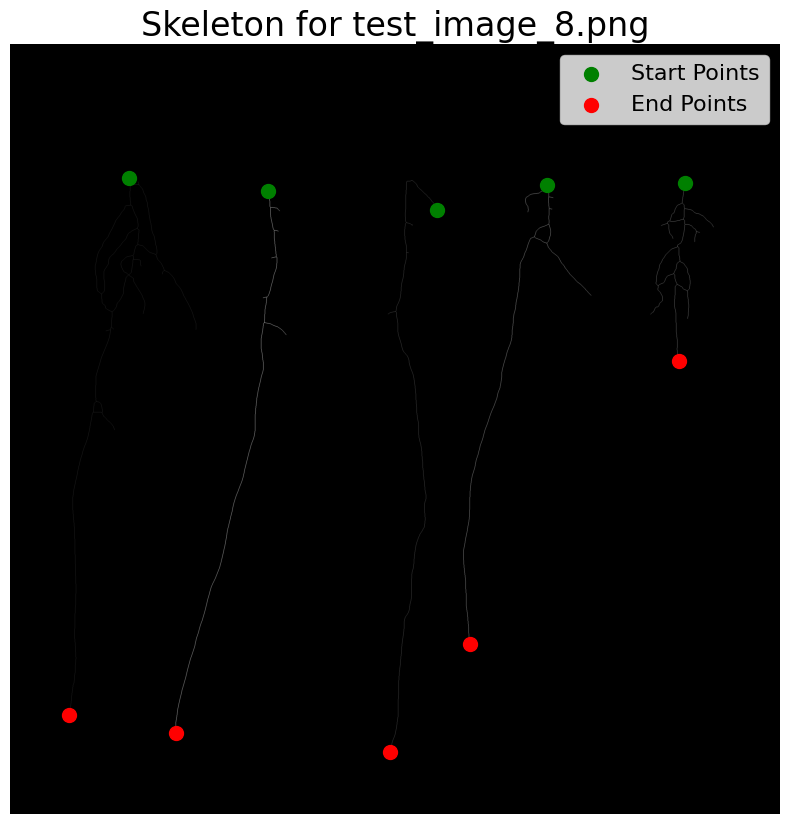

Processing test_image_9.png...


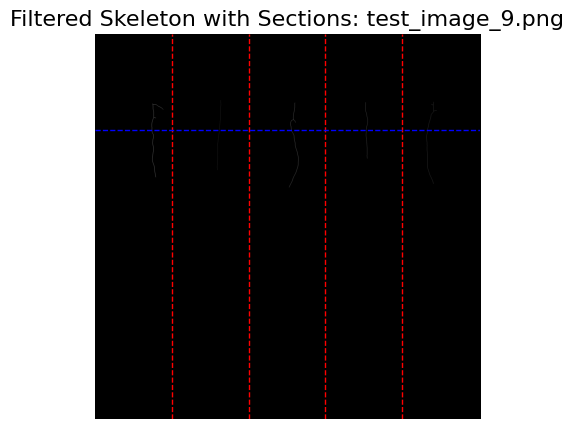

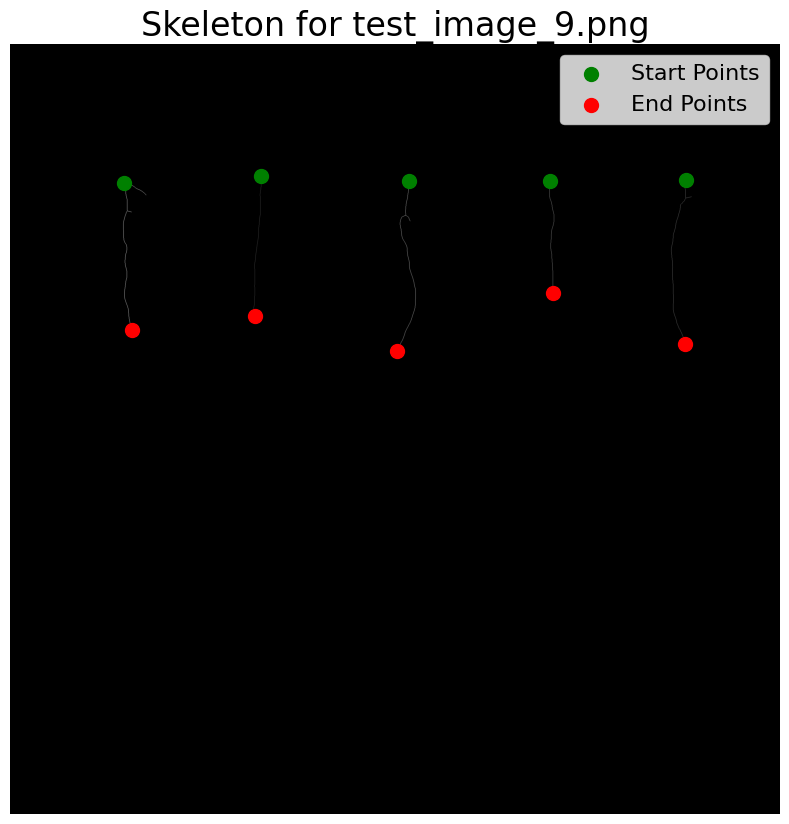

    skeleton-id           filename  start_y  start_x   end_y   end_x  \
0             0   test_image_1.png    479.0   1407.0   718.0  1440.0   
1             1   test_image_1.png    482.0    449.0   998.0   470.0   
2             0  test_image_10.png    536.0   1930.0  1764.0  2016.0   
3             1  test_image_10.png    569.0   2459.0  1615.0  2535.0   
4             2  test_image_10.png    589.0    397.0  1641.0   280.0   
..          ...                ...      ...      ...     ...     ...   
80            0   test_image_9.png    483.0    918.0   994.0   894.0   
81            1   test_image_9.png    496.0   2471.0  1095.0  2469.0   
82            2   test_image_9.png    499.0   1975.0   910.0  1987.0   
83            3   test_image_9.png    502.0   1459.0  1121.0  1415.0   
84            4   test_image_9.png    509.0    418.0  1047.0   444.0   

    path_length  
0    254.325902  
1    562.563492  
2   1308.114790  
3   1133.144228  
4   1161.055916  
..          ...  
80   526.

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.morphology import skeletonize
from skan import Skeleton, summarize
import networkx as nx

# Process skeletonization and extract data for each binary connected component
all_start_end_data = []

for filename, binary_labels in processed_masks:
    print(f"Processing {filename}...")

    # Step 1: Skeletonize the binary mask
    skeleton_object = skeletonize(binary_labels > 0)

    # Step 2: Label connected components
    labeled_roots = label(skeleton_object)

    # Step 3: Define the horizontal line at the top 25% of the height
    top_limit_y = int(binary_labels.shape[0] * 0.25)

    # Step 4: Divide the image into 5 vertical sections and retain the largest component in the top part of each sector
    section_width = binary_labels.shape[1] // 5
    filtered_roots = np.zeros_like(labeled_roots)

    for sector_id in range(5):
        x_start = sector_id * section_width
        x_end = (sector_id + 1) * section_width if sector_id < 4 else binary_labels.shape[1]

        # Get the components in the top 25% of the sector
        sector_mask_top = labeled_roots[:top_limit_y, x_start:x_end]
        sector_labels_top = np.unique(sector_mask_top[sector_mask_top > 0])  # Exclude background

        # Find the largest component in the top part of the sector
        max_area = 0
        largest_label_top = 0
        for label_id in sector_labels_top:
            area = np.sum(labeled_roots[:top_limit_y, :] == label_id)  # Count all pixels for the label in the top part
            if area > max_area:
                max_area = area
                largest_label_top = label_id

        # Retain the largest component in the top part of this sector
        if largest_label_top > 0:
            filtered_roots[labeled_roots == largest_label_top] = largest_label_top

    # Step 5: Remove neighboring roots on the x and y axes within specified thresholds and retain the larger one
    unique_labels = np.unique(filtered_roots[filtered_roots > 0])
    to_remove = set()

    # Define thresholds for proximity in x and y axes
    x_threshold = 100
    y_threshold = 200

    for label_id in unique_labels:
        coords = np.column_stack(np.where(filtered_roots == label_id))
        for other_label in unique_labels:
            if label_id == other_label or other_label in to_remove:
                continue

            other_coords = np.column_stack(np.where(filtered_roots == other_label))
            if any(abs(coord1[1] - coord2[1]) <= x_threshold and abs(coord1[0] - coord2[0]) <= y_threshold \
                   for coord1 in coords for coord2 in other_coords):
                # Compare the areas of the two labels
                area_label_id = np.sum(filtered_roots == label_id)
                area_other_label = np.sum(filtered_roots == other_label)

                if area_label_id >= area_other_label:
                    to_remove.add(other_label)
                else:
                    to_remove.add(label_id)
                    break

    for label_id in to_remove:
        filtered_roots[filtered_roots == label_id] = 0

    # Step 6: Plot filtered roots with sections and the horizontal line
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(filtered_roots, cmap="gray")

    # Draw vertical lines to indicate sections
    for i in range(1, 5):  # 4 lines divide into 5 sections
        x = i * section_width
        ax.axvline(x=x, color="red", linestyle="--", linewidth=1)

    # Draw the horizontal line at 35% of the height
    ax.axhline(y=top_limit_y, color="blue", linestyle="--", linewidth=1)

    ax.set_title(f"Filtered Skeleton with Sections: {filename}", fontsize=16)
    ax.axis("off")
    plt.show()

    # Step 7: Summarize the skeleton
    skeleton_data = Skeleton(filtered_roots)
    branch_data = summarize(skeleton_data)

    # Step 8: Create a NetworkX graph from the skeleton branch data
    G = nx.from_pandas_edgelist(
        branch_data, 
        source='node-id-src', 
        target='node-id-dst', 
        edge_attr='branch-distance'
    )

    # Step 9: Extract start and end points of the skeleton
    results = []
    for skeleton_id, group in branch_data.groupby("skeleton-id"):
        # Start point (minimum y-coordinate)
        start_branch = group.loc[group[["image-coord-src-0", "image-coord-dst-0"]].min(axis=1).idxmin()]
        start_y = start_branch[["image-coord-src-0", "image-coord-dst-0"]].min()
        start_x = start_branch[["image-coord-src-1", "image-coord-dst-1"]].iloc[start_branch[["image-coord-src-0", "image-coord-dst-0"]].argmin()]

        # End point (maximum y-coordinate)
        end_branch = group.loc[group[["image-coord-src-0", "image-coord-dst-0"]].max(axis=1).idxmax()]
        end_y = end_branch[["image-coord-src-0", "image-coord-dst-0"]].max()
        end_x = end_branch[["image-coord-src-1", "image-coord-dst-1"]].iloc[end_branch[["image-coord-src-0", "image-coord-dst-0"]].argmax()]

        results.append({
            "skeleton-id": skeleton_id,
            "filename": filename,
            "start_y": start_y,
            "start_x": start_x,
            "end_y": end_y,
            "end_x": end_x
        })

    # Convert results to a DataFrame
    start_end_df = pd.DataFrame(results)

    # Step 10: Map coordinates to nodes and compute shortest paths
    coordinate_to_node = {}
    for _, row in branch_data.iterrows():
        coordinate_to_node[(row['image-coord-src-0'], row['image-coord-src-1'])] = row['node-id-src']
        coordinate_to_node[(row['image-coord-dst-0'], row['image-coord-dst-1'])] = row['node-id-dst']

    path_lengths = []
    for _, row in start_end_df.iterrows():
        src_node = coordinate_to_node.get((row['start_y'], row['start_x']), None)
        dst_node = coordinate_to_node.get((row['end_y'], row['end_x']), None)

        if src_node is not None and dst_node is not None and src_node in G.nodes and dst_node in G.nodes:
            try:
                path_len = nx.dijkstra_path_length(G, src_node, dst_node, weight='branch-distance')
                path_lengths.append(path_len)
            except nx.NetworkXNoPath:
                path_lengths.append(None)
        else:
            path_lengths.append(None)

    start_end_df['path_length'] = path_lengths
    all_start_end_data.append(start_end_df)

    # Visualize skeleton with start and end points
    plt.figure(figsize=(15, 10))
    plt.title(f"Skeleton for {filename}", fontsize=24)
    plt.imshow(filtered_roots, cmap='gray')  # Updated to display filtered_roots
    plt.scatter(start_end_df["start_x"], start_end_df["start_y"], color='green', label='Start Points', s=100)
    plt.scatter(start_end_df["end_x"], start_end_df["end_y"], color='red', label='End Points', s=100)
    plt.legend(fontsize=16)
    plt.axis("off")
    plt.show()

# Combine all results into a single DataFrame
final_data = pd.concat(all_start_end_data, ignore_index=True)

# Display the final results
print(final_data)


In [1]:
final_data.head()

NameError: name 'final_data' is not defined

In [12]:
iuhofahiohifoa 

NameError: name 'iuhofahiohifoa' is not defined

In [55]:
import numpy as np
import pandas as pd

# Initialize results
results = []

# Define the number of sectors (5) and calculate sector boundaries
num_sectors = 5
image_width = final_data["start_x"].max() + 1  # Assuming start_x represents horizontal pixel positions
sector_width = image_width // num_sectors

# Group by filename and process each group
for filename, group in final_data.groupby("filename"):
    # Create an array to store lengths for each sector
    sector_lengths = [0] * num_sectors

    # Assign roots to sectors based on their start_x position
    for _, row in group.iterrows():
        sector_index = int(row["start_x"] // sector_width)  # Determine the sector based on start_x
        sector_index = min(sector_index, num_sectors - 1)  # Ensure it's within bounds (sector 0 to 4)
        path_length = round(row["path_length"])
        sector_lengths[sector_index] = path_length  # Store the length for the corresponding sector

    # Add results for each sector (plant ID 1 to 5)
    for plant_id in range(1, num_sectors + 1):
        results.append([f"{filename[:-4]}_plant_{plant_id}", sector_lengths[plant_id - 1]])

# Convert results to DataFrame for submission
submission_df = pd.DataFrame(results, columns=["Plant ID","Length (px)"])

# Save to CSV
submission_df.to_csv("Final_submission_1.csv", index=False, header=False)

# Print a preview of the submission file
print(submission_df.head())


               Plant ID  Length (px)
0  test_image_1_plant_1          563
1  test_image_1_plant_2            0
2  test_image_1_plant_3          254
3  test_image_1_plant_4            0
4  test_image_1_plant_5            0
